# Find genes different between acclimation and adaptation

In [562]:
import os 
import gc
import re
import csv
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from scipy import stats, special
from numba import njit, prange, set_num_threads


ModuleNotFoundError: No module named 'umap'

In [2]:
import sys
sys.path.append('../repo-armbrust-metat-search')

In [3]:
import functions.fn_metat_files as fnf
import functions.fn_correlation as fc

In [4]:
ncbi = NCBITaxa()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [7]:
workdir = '/scratch/bgrodner/p_calceolata_enterobactin'
os.chdir(workdir)


In [8]:
os.getcwd()

'/scratch/bgrodner/p_calceolata_enterobactin'

In [9]:
os.listdir()

['file_table.240210.kofam_filt.csv',
 'nb_enterobactin.ipynb',
 '.DS_Store',
 'nb_pelagophycae.ipynb',
 '.snakemake',
 'file_table.240307.pelagophyceae_taxids.csv',
 '._.DS_Store',
 'pelagophyceae_taxids.txt',
 'config.yaml',
 'metat_search_results',
 '._file_table.240307.pelagophyceae_taxids.csv',
 'sc_run_snakemake.sh',
 '._file_table.240210.kofam_filt.csv',
 'tidytable_enterobactin_kos.csv']

Plotting

In [10]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)


def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o'
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def get_colors_from_stringlist(stringlist, order="", cmap_name="viridis"):
    if not order:
        order = list(set(stringlist))
    n_strings = len(order)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / n_strings) for i in range(n_strings)]
    dict_str_col = {s: c for s, c in zip(order, colors)}
    return [dict_str_col[s] for s in stringlist], dict_str_col


def plot_legend(color_dict, figsize=(2, 4)):
    fig, ax = general_plot(dims=figsize)
    # Create legend handles manually
    legend_handles = []
    for value, color in color_dict.items():
        patch = mpatches.Patch(color=color, label=value)
        legend_handles.append(patch)

    # Add legend to the plot
    ax.legend(handles=legend_handles)
    return fig, ax


def taxon_legend(
    taxon_names,
    taxon_colors,
    label_color="k",
    taxon_counts=[],
    text_shift_vh=(6, 0.15),
    ft=20,
    dims=(6, 10),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    vals = np.repeat(10, len(taxon_names))
    y_pos = np.arange(len(taxon_names))
    ax.barh(y_pos, vals, align="center", color=taxon_colors)
    if len(taxon_counts) > 0:
        # Label the legend with counts
        for i, (v, c) in enumerate(zip(vals, taxon_counts)):
            ax.text(
                v - text_shift_vh[0],
                i + text_shift_vh[1],
                str(c),
                color="k",
                fontsize=ft,
            )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis
    ax.set_yticks(y_pos)
    ax.set_xticks([])
    ax.set_yticklabels(taxon_names)
    ax.invert_yaxis()
    return (fig, ax)


def marker_legend(
    names,
    markers,
    label_color="k",
    text_shift_hv=(0.5, 0),
    markersize=50,
    ft=20,
    dims=(3, 3),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    for i, (n, m) in enumerate(zip(names, markers)):
        ax.scatter(0, i, marker=m, c=label_color, s=markersize)
        # ax.text(
        #     0 - text_shift_hv[0],
        #     i + text_shift_hv[1],
        #     str(n),
        #     color=label_color,
        #     fontsize=ft,
        #     va="center",
        # )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, i + 1])

    ax.set_yticks(np.arange(i+1))
    ax.set_xticks([])
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.invert_yaxis()
    return fig, ax

#### Get KO dict

Get dataframe

In [11]:
ko_fn = "../iron_ko_contigs/ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


(61993, 4)

In [12]:
ld = df_kegg['Level_D'].values
ld[:5]

array(['K00844  HK; hexokinase [EC:2.7.1.1]',
       'K12407  GCK; glucokinase [EC:2.7.1.2]',
       'K00845  glk; glucokinase [EC:2.7.1.2]',
       'K25026  glk; glucokinase [EC:2.7.1.2]',
       'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'],
      dtype=object)

In [13]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

Get metadata table

In [14]:
metadata_path = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-metadata.csv"  # input('Enter the filepath of your batch metadata file:')
metadata = pd.read_csv(metadata_path)
metadata.iloc[[1,100,200],:]

assembly sample  latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1       NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.57deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1  39.76deg        NaN           NaN  15.0m  0.2um   B   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806

Correct G1 S11C1 latitudes

In [15]:
lats_new = []
for i, row in metadata.iterrows():
    if (row['sample'] == 'S11C1') & ('G1' in row['assembly']):
        lats_new.append('36.569deg')
    else:
        lats_new.append(row.latitude)
metadata['latitude'] = lats_new
metadata.iloc[[1,100,200],:]

assembly sample   latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1        NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.569deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1   39.76deg        NaN           NaN  15.0m  0.2um   B   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806

Get cruise column

In [16]:
# skp = ['D1PA','G3PA.diel','G3PA.PM','G5']
# metadata['cruise'] = [assm[:2] if assm not in skp else assm for assm in metadata.assembly]
# metadata['selection'] = [assm[-2:] if assm not in skp else '' for assm in metadata.assembly]
# metadata.cruise.unique(), metadata.selection.unique()

In [17]:
skp = ['D1PA','G3PA.diel','G3PA.PM','G5']
metadata['cruise'] = [assm[:2] if assm not in skp else assm for assm in metadata.assembly]
sels = []
for assm in metadata.assembly:
    if 'NS' in assm:
        sels.append('NS')
    elif assm == 'G5':
        sels.append('NS')
    else:
        sels.append('PA')

metadata['selection'] = sels
metadata.cruise.unique(), metadata.selection.unique()

(array(['D1PA', 'G1', 'G2', 'G3', 'G3PA.diel', 'G3PA.PM', 'G5'],
       dtype=object),
 array(['PA', 'NS'], dtype=object))

Batch column

In [18]:
batchs = []
for i, row in metadata.iterrows():
    cruise, sel, size = [row[v] for v in ['cruise','selection','size']]
    batchs.append(f'{cruise}_{sel}_{size}')

metadata['batch'] = batchs

Map fnsamplecounts to metadata

In [19]:
dict_meta = {}
for i, row in metadata.iterrows():
    dict_meta[row['fn_sample_counts']] = row.to_dict()

In [20]:
dict_assam_meta = {}
for i, row in metadata.iterrows():
    dict_assam_meta[row['assm_sample']] = row.to_dict()

In [21]:
dict_batch_meta = {}
for i, row in metadata.iterrows():
    dict_batch_meta[row['batch']] = row.to_dict()

In [22]:
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))


Get tzdf info

In [23]:
dict_cruise_trans_sal_chl = {
    'G1': [32.15, 33.0],
    'G2': [32.5, 36.2],
    'G3': [32.34, 35],
    'G3PA.PM': [32.34, 35],
}

## Load data

Load dict of u test at TZCF for different size fractions

In [85]:
fn_dict_udir = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/tzcf_mann_whitney'
    + '/dict_udirection_size_taxa_same_across_cruises.json'
)

with open(fn_dict_udir, 'r') as f:
    dict_udir_size_taxa = json.load(f)

print('size', '\t', 'len(taxa)', '\t', 'udir')
for udir, dict_size_taxa in dict_udir_size_taxa.items():
    for size, taxa in dict_size_taxa.items():
        print(size, '\t', len(taxa), '\t', udir)

size 	 len(taxa) 	 udir
0.2um 	 90 	 frac - S < N, trl - S < N
3.0um 	 69 	 frac - S < N, trl - S < N
0.2um 	 1 	 frac - S < N, trl - other
3.0um 	 3 	 frac - S < N, trl - other
0.2um 	 0 	 frac - S > N, trl - S < N
3.0um 	 38 	 frac - S > N, trl - S < N
0.2um 	 12 	 frac - S > N, trl - S > N
3.0um 	 2 	 frac - S > N, trl - S > N
0.2um 	 3 	 frac - S > N, trl - S ~= N
3.0um 	 1 	 frac - S > N, trl - S ~= N
0.2um 	 6 	 frac - S > N, trl - other
3.0um 	 2 	 frac - S > N, trl - other
0.2um 	 37 	 frac - S ~= N, trl - S < N
3.0um 	 42 	 frac - S ~= N, trl - S < N
0.2um 	 618 	 frac - S ~= N, trl - S ~= N
3.0um 	 840 	 frac - S ~= N, trl - S ~= N
0.2um 	 49 	 frac - S ~= N, trl - other
3.0um 	 58 	 frac - S ~= N, trl - other
0.2um 	 16 	 frac - other, trl - S < N
3.0um 	 52 	 frac - other, trl - S < N
0.2um 	 0 	 frac - other, trl - S > N
3.0um 	 0 	 frac - other, trl - S > N
0.2um 	 27 	 frac - other, trl - S ~= N
3.0um 	 35 	 frac - other, trl - S ~= N
0.2um 	 58 	 frac - other, trl - oth

Get dict mapping taxid to total estcounts for each 'batch'

In [145]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_batch_tax_assam_vals = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
        batch = f'{cruise}_{sel}_{size}'
        assm_sam = row_meta['assm_sample']
        norm_factor = row_meta['norm_factor']
        valtypes = ['frac','trl']
        vals = [float(frac_total_estcounts), float(estcounts) * norm_factor]
        # Append taxon fraction of counts and transcripts per liter to separate dicts
        for vt, v in zip(valtypes, vals):
            dict_valtype_batch_tax_assam_vals[vt][batch][taxid][assm_sam].append(v)




In [146]:
list(dict_valtype_batch_tax_assam_vals['frac'].keys())

['D1PA_PA_nan',
 'G1_PA_3.0um',
 'G1_PA_0.2um',
 'G1_NS_3.0um',
 'G1_NS_0.2um',
 'G2_PA_3.0um',
 'G2_PA_0.2um',
 'G2_NS_0.2um',
 'G2_NS_3.0um',
 'G3_PA_3.0um',
 'G3_PA_0.2um',
 'G3PA.diel_PA_0.2um',
 'G3_NS_3.0um',
 'G3_NS_0.2um',
 'G3PA.PM_PA_0.2um',
 'G3PA.PM_PA_3.0um',
 'G5_NS_nan']

Get median value for each sample

In [147]:
dict_valtype_batch_tax_assam_medval = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for vt, dict_batch_tax_assam_vals in dict_valtype_batch_tax_assam_vals.items():
    for batch, dict_tax_assam_vals in dict_batch_tax_assam_vals.items():
        for tax, dict_assam_vals in dict_tax_assam_vals.items():
            for assam, vals in dict_assam_vals.items():
                dict_valtype_batch_tax_assam_medval[vt][batch][tax][assam] = (
                    np.median(vals)
                )


Get array of taxon x sample for Tr/l and fraction of taxon estcounts 

In [148]:
dict_valtype_batch_dfs = defaultdict(dict)
for vt, dict_batch_tax_assam_medval in dict_valtype_batch_tax_assam_medval.items():
    for batch, dict_tax_assam_medval in dict_batch_tax_assam_medval.items():
        df = pd.DataFrame(dict_tax_assam_medval).fillna(0)
        dict_valtype_batch_dfs[vt][batch] = df


In [67]:
metadata.loc[metadata['assembly'] == 'G1PA', 'latitude'].sort_values().unique()

array(['23.5deg', '26.28deg', '28.14deg', '29.7deg', '32.58deg',
       '33.09deg', '35.46deg', '36.569deg', '36.57deg', '37.3deg'],
      dtype=object)

In [66]:
metadata['assembly'].unique()

array(['D1PA', 'G1PA', 'G1NS', 'G2PA', 'G2NS', 'G3PA', 'G3PA.diel',
       'G3.UW.NS', 'G3PA.PM', 'G5'], dtype=object)

## Inspect types of S - N differential abundance

### Which taxa have increased abundance as much as the rest of the community in the north?

Tree of taxa

In [123]:
udir = 'frac - S ~= N, trl - S < N'
dict_size_taxa = dict_udir_size_taxa[udir]
for size, taxa in dict_size_taxa.items():
    print('****',udir,'****')
    print('******', size,'****')
    taxa_trans = []
    if taxa:
        for t in taxa:
            n = ncbi.get_taxid_translator([t]).get(int(t))
            if n:
                tn = ncbi.get_name_translator([n])[n][0]
                taxa_trans.append(tn)
        tree = ncbi.get_topology(taxa_trans)
        print(tree.to_str(props=['sci_name'], compact=True))

**** frac - S ~= N, trl - S < N ****
****** 0.2um ****
                                                                 ╭╴Gammaproteobacteria╶╌╴Cellvibrionales╶┬╴marine gamma proteobacterium HTCC2148
                                                                 │                                       ╰╴gamma proteobacterium HTCC2207
                                                ╭╴Pseudomonadota╶┤                                       ╭╴Roseobacteraceae╶┬╴Sulfitobacter mediterraneus
                                                │                │                     ╭╴Rhodobacterales╶┤                  ╰╴Ruegeria lacuscaerulensis ITI-1157
                                                │                ╰╴Alphaproteobacteria╶┤                 ╰╴Rhodobacteraceae bacterium HIMB11
                               ╭╴Pseudomonadati╶┤                                      ╰╴Candidatus Pelagibacterales╶┬╴Candidatus Fonsibacter ubiquis
                               │                │       

Plot all profiles

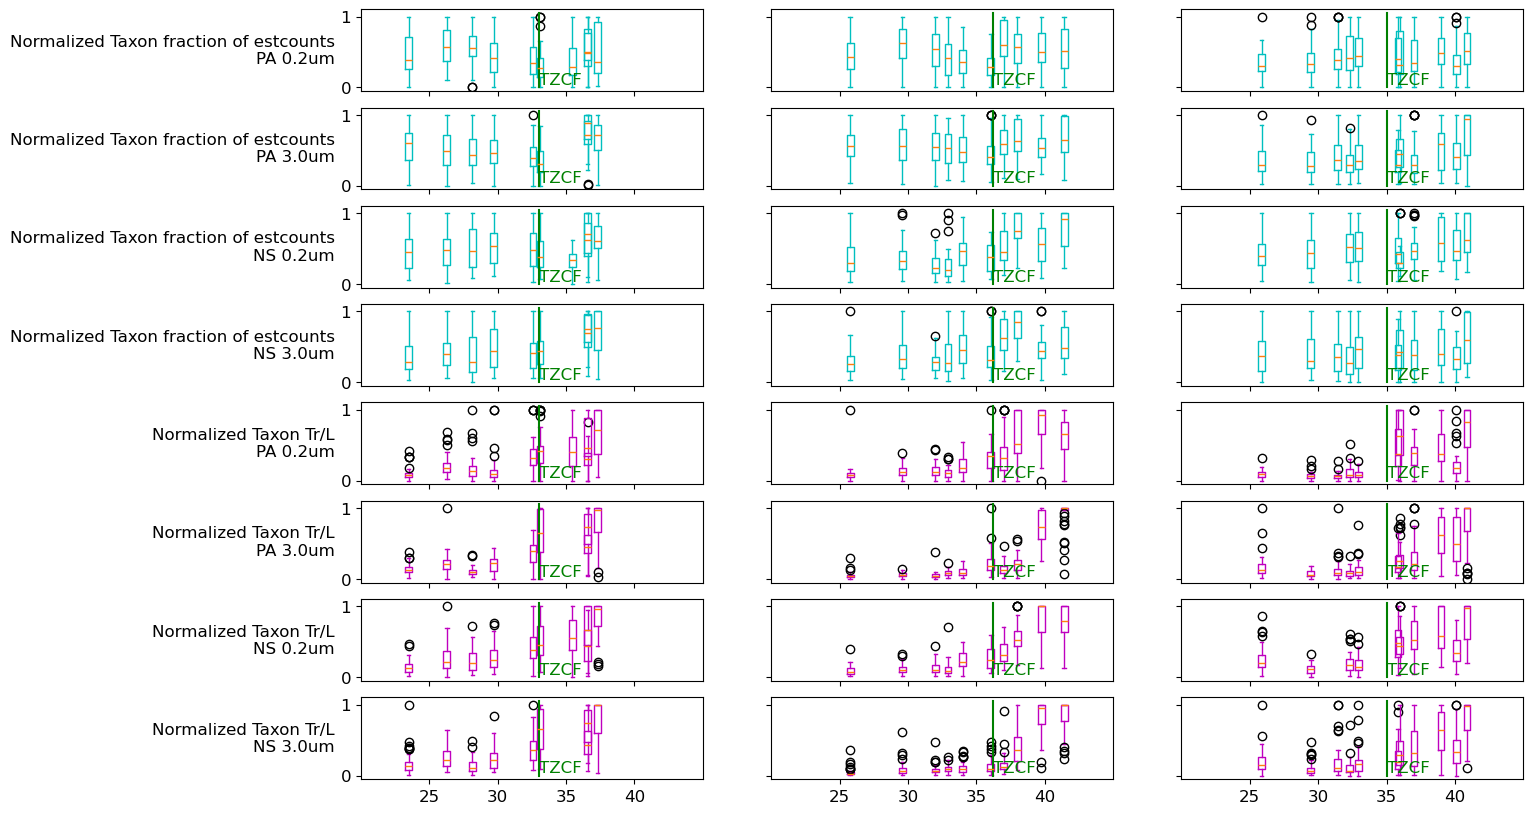

In [124]:
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':2,
    '0.2um':0,
    '3.0um':1
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 4
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,10))

for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
    for batch, df in dict_batch_df.items():
        row_meta = dict_batch_meta[batch]
        cruise = row_meta['cruise']
        df = df.copy()
        if cruise in dict_cruise_j:
            j = dict_cruise_j[cruise]
            sel = row_meta['selection']
            size = row_meta['size']
            seli = dict_selsz_i[sel]
            sizei = dict_selsz_i[size]
            i = i_ * 4 + (seli + sizei)
            ax = axes[i,j]
            lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
            salf, tzcf = dict_cruise_trans_sal_chl[cruise]
            taxa = dict_udir_size_taxa[udir][size]
            bool_tax = df.columns.astype(int).isin(taxa)
            vals = df.loc[:,bool_tax].values
            vals /= np.max(vals, axis=0)
            bp = ax.boxplot(vals.T, positions=lats)
            color = dict_vt_color[vt]
            for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                plt.setp(bp[item], color=color)
            ylims = ax.get_ylim()
            ax.plot([tzcf]*2, (0,ylims[1]), 'g')
            ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
            xticks = np.arange(25,45,5).astype(int)
            ax.set_xlim(20,45)
            ax.set_xticks(xticks)
            xticklab = xticks if i == nrows - 1 else []
            ax.set_xticklabels(xticklab) 
            ylab = dict_vt_ylab[vt]
            if j == 0:
                ax.set_ylabel(f'Normalized {ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
            else:
                ax.set_yticklabels([])

Plot specific profiles

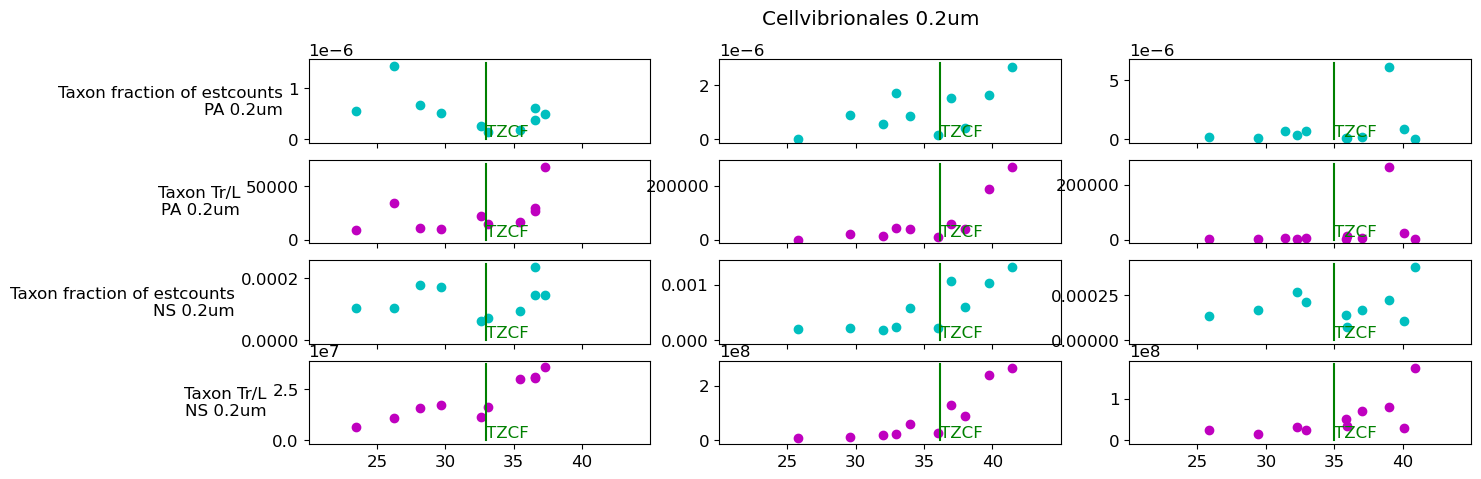

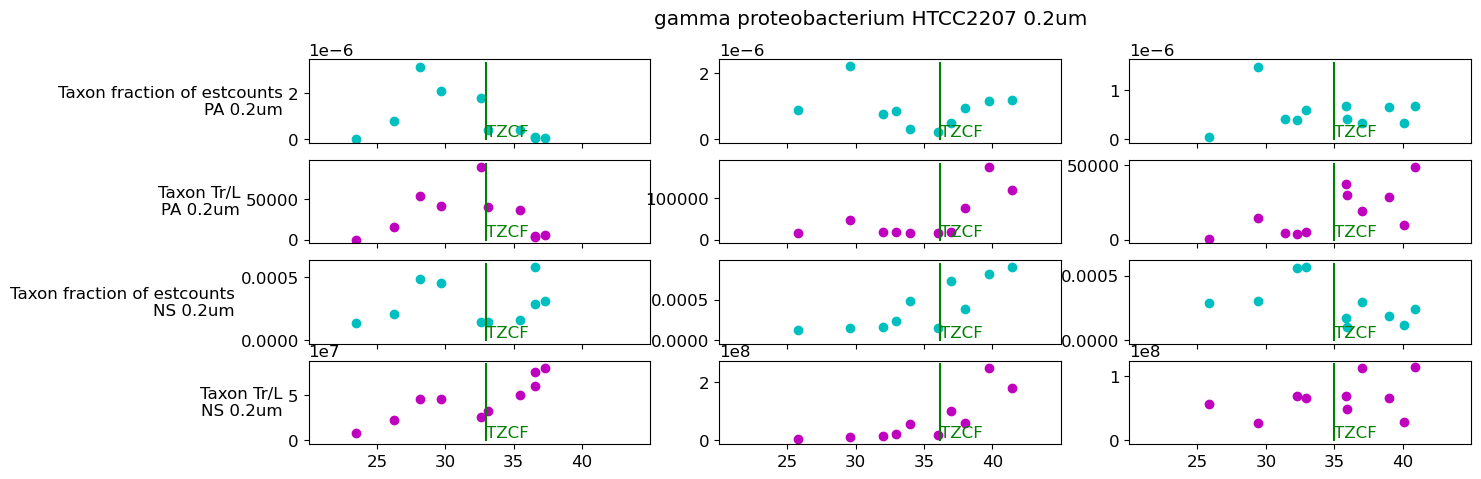

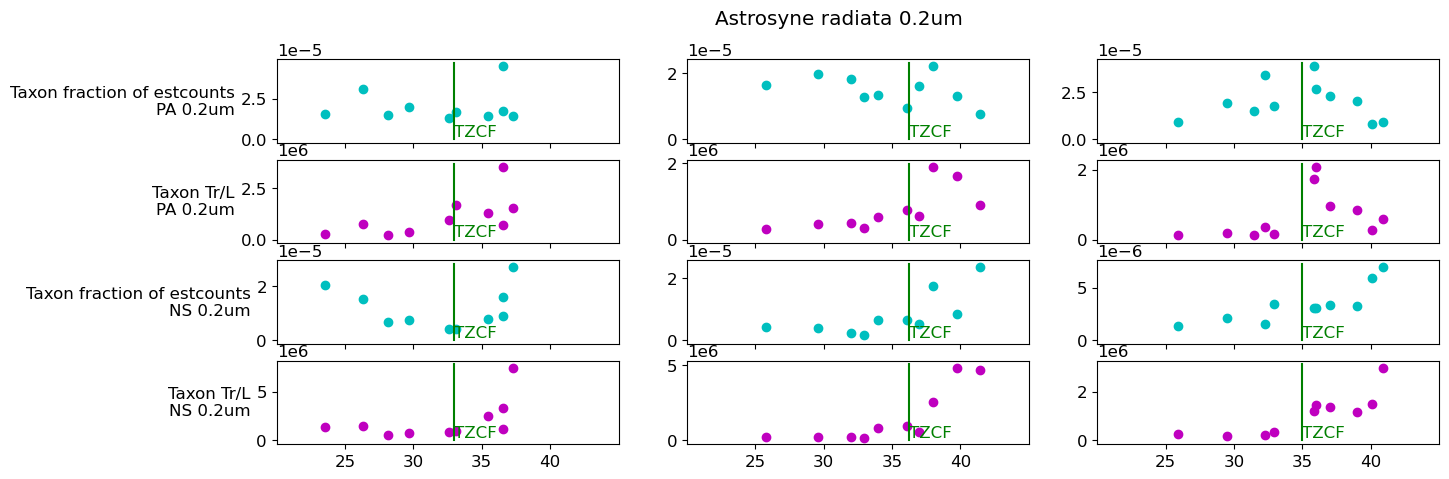

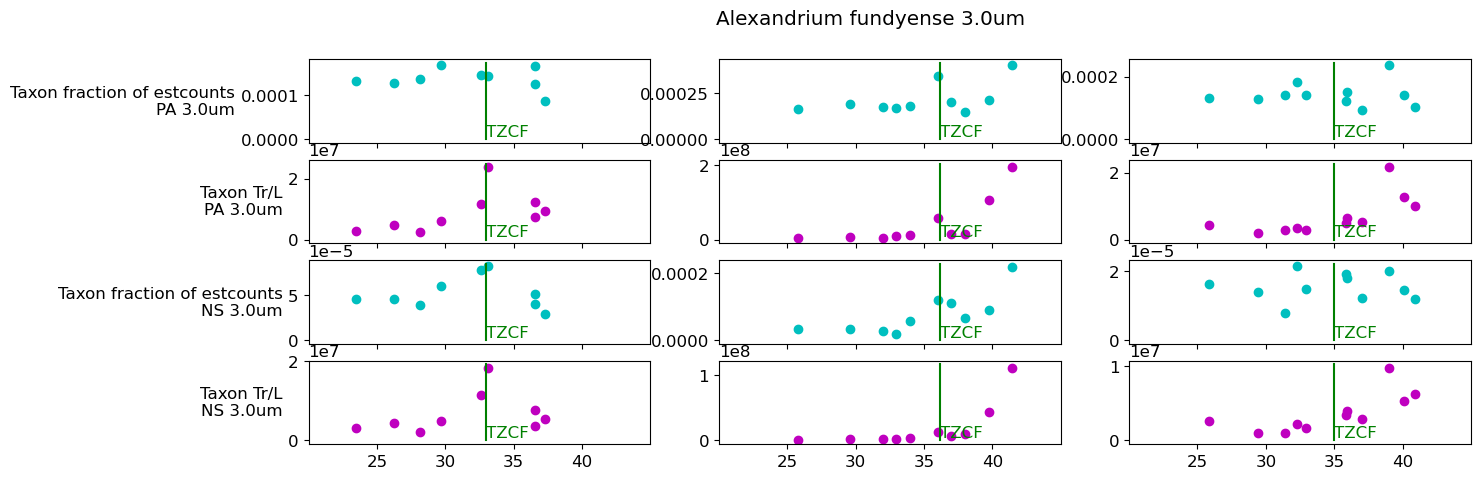

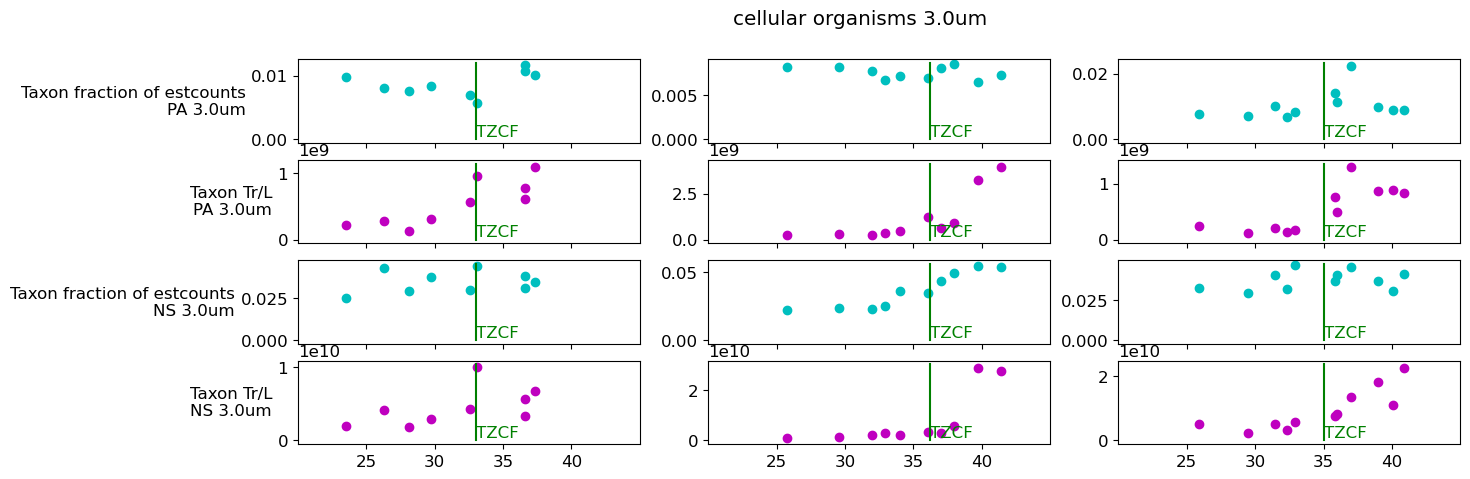

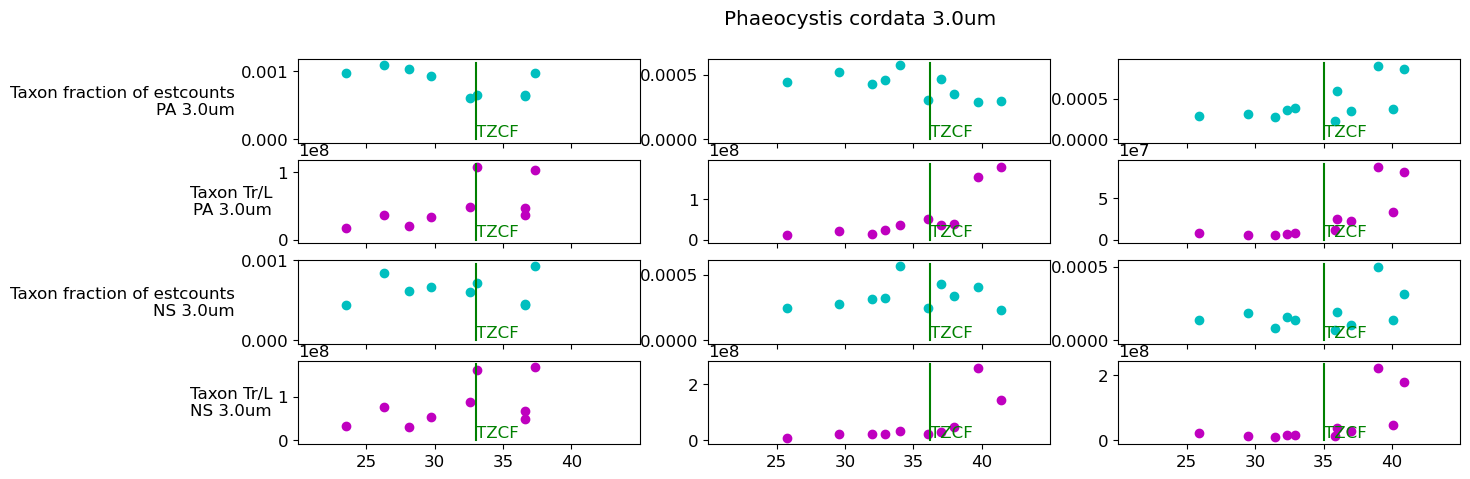

In [125]:
nplots = 3

dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':1,
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 2
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)

dict_size_taxa = dict_udir_size_taxa[udir]
for tsize, taxa in dict_size_taxa.items():
    dict_tax_name = ncbi.get_taxid_translator(taxa)
    for t in np.random.choice(taxa, nplots, replace=False):
        fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))
        tname = dict_tax_name.get(int(t))
        tname = tname if tname else t
        fig.suptitle(f'{tname} {tsize}')
        for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
            for batch, df in dict_batch_df.items():
                df = df.copy()
                row_meta = dict_batch_meta[batch]
                cruise = row_meta['cruise']
                size = row_meta['size']
                if cruise in dict_cruise_j:
                    if size == tsize:
                        j = dict_cruise_j[cruise]
                        sel = row_meta['selection']
                        seli = dict_selsz_i[sel]
                        i = i_ + 2 * seli
                        ax = axes[i,j]
                        lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
                        salf, tzcf = dict_cruise_trans_sal_chl[cruise]
                        if str(t) in df.columns:
                            vals = df[str(t)].values
                            color = dict_vt_color[vt]
                            ax.scatter(lats, vals, color=color)
                        ylims = ax.get_ylim()
                        ax.plot([tzcf]*2, (0,ylims[1]), 'g')
                        ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
                        xticks = np.arange(25,45,5).astype(int)
                        ax.set_xlim(20,45)
                        ax.set_xticks(xticks)
                        xticklab = xticks if i == nrows - 1 else []
                        ax.set_xticklabels(xticklab) 
                        ylab = dict_vt_ylab[vt]
                        if j == 0:
                            ax.set_ylabel(f'{ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
                        # else:
                            # ax.set_yticklabels([])
        plt.show()

### Which taxa have increased abundance more than the rest of the community in the north?

Tree of taxa

In [119]:
udir = 'frac - S < N, trl - S < N'
dict_size_taxa = dict_udir_size_taxa[udir]
for size, taxa in dict_size_taxa.items():
    print('****',udir,'****')
    print('******', size,'****')
    taxa_trans = []
    if taxa:
        for t in taxa:
            n = ncbi.get_taxid_translator([t]).get(int(t))
            if n:
                tn = ncbi.get_name_translator([n])[n][0]
                taxa_trans.append(tn)
        tree = ncbi.get_topology(taxa_trans)
        print(tree.to_str(props=['sci_name'], compact=True))

**** frac - S < N, trl - S < N ****
****** 0.2um ****
                                                                                                          ╭╴Nitratireductor
                                                                                       ╭╴Hyphomicrobiales╶┼╴unclassified Rhizobium
                                                                                       │                  ╰╴Ahrensia sp. 13_GOM-1096m
                                                                                       │                                 ╭╴Limimaricola hongkongensis
                                                                                       │                 ╭╴Paracoccaceae╶┼╴Planktomarina temperata RCA23
                                                                                       │                 │               ╰╴Marivivens sp. JLT3646
                                                                                       ├╴Rhodobacterales╶┼╴R

Plot all profiles

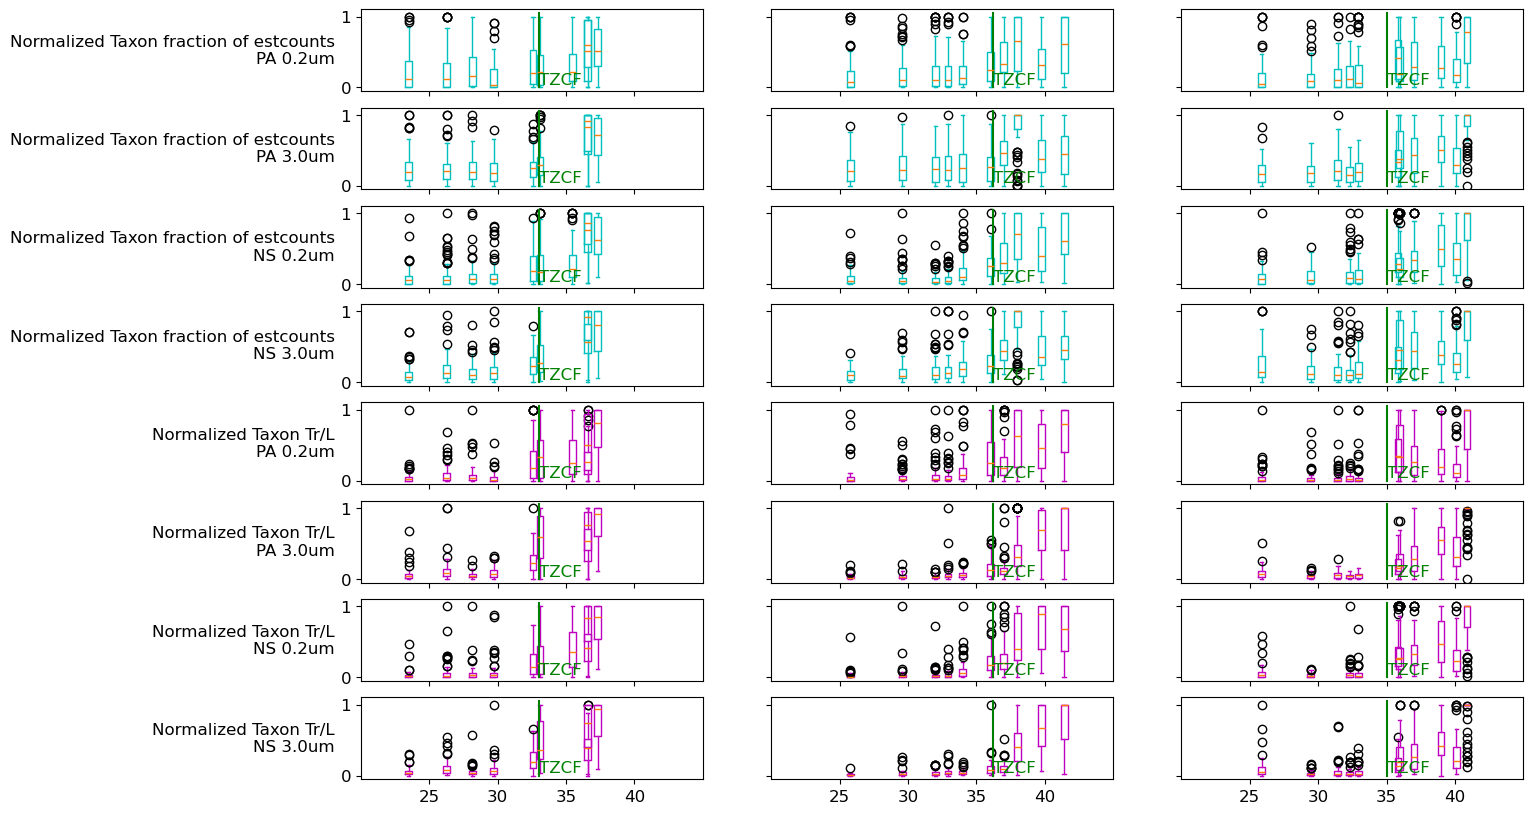

In [120]:
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':2,
    '0.2um':0,
    '3.0um':1
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 4
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,10))

for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
    for batch, df in dict_batch_df.items():
        row_meta = dict_batch_meta[batch]
        cruise = row_meta['cruise']
        df = df.copy()
        if cruise in dict_cruise_j:
            j = dict_cruise_j[cruise]
            sel = row_meta['selection']
            size = row_meta['size']
            seli = dict_selsz_i[sel]
            sizei = dict_selsz_i[size]
            i = i_ * 4 + (seli + sizei)
            ax = axes[i,j]
            lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
            salf, tzcf = dict_cruise_trans_sal_chl[cruise]
            taxa = dict_udir_size_taxa[udir][size]
            bool_tax = df.columns.astype(int).isin(taxa)
            vals = df.loc[:,bool_tax].values
            vals /= np.max(vals, axis=0)
            bp = ax.boxplot(vals.T, positions=lats)
            color = dict_vt_color[vt]
            for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                plt.setp(bp[item], color=color)
            ylims = ax.get_ylim()
            ax.plot([tzcf]*2, (0,ylims[1]), 'g')
            ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
            xticks = np.arange(25,45,5).astype(int)
            ax.set_xlim(20,45)
            ax.set_xticks(xticks)
            xticklab = xticks if i == nrows - 1 else []
            ax.set_xticklabels(xticklab) 
            ylab = dict_vt_ylab[vt]
            if j == 0:
                ax.set_ylabel(f'Normalized {ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
            else:
                ax.set_yticklabels([])

Plot specific profiles

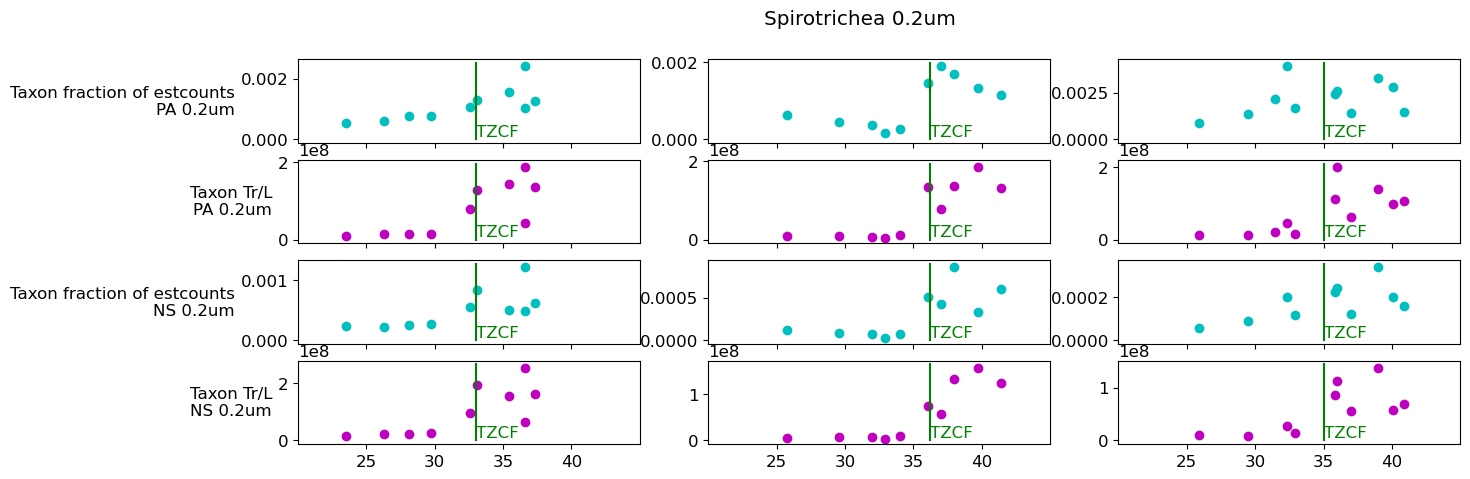

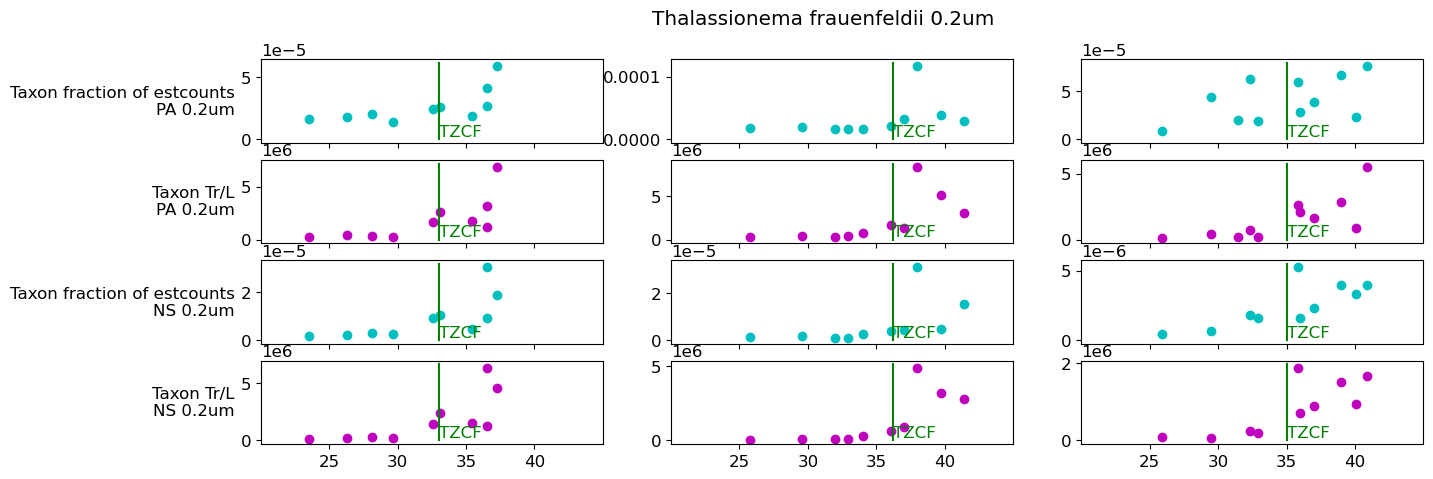

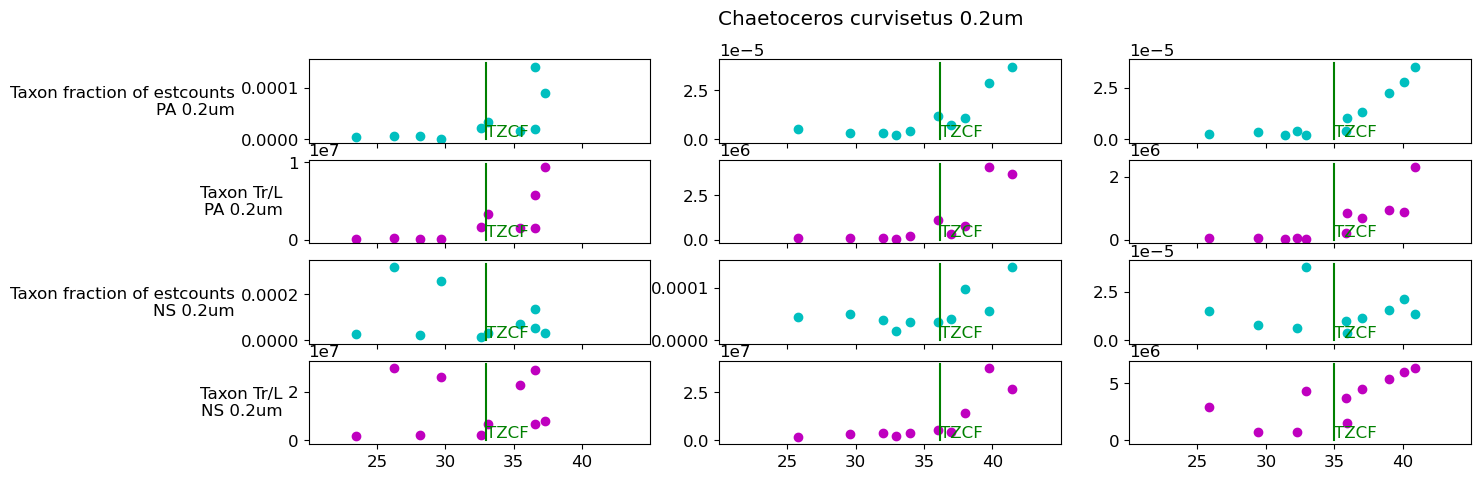

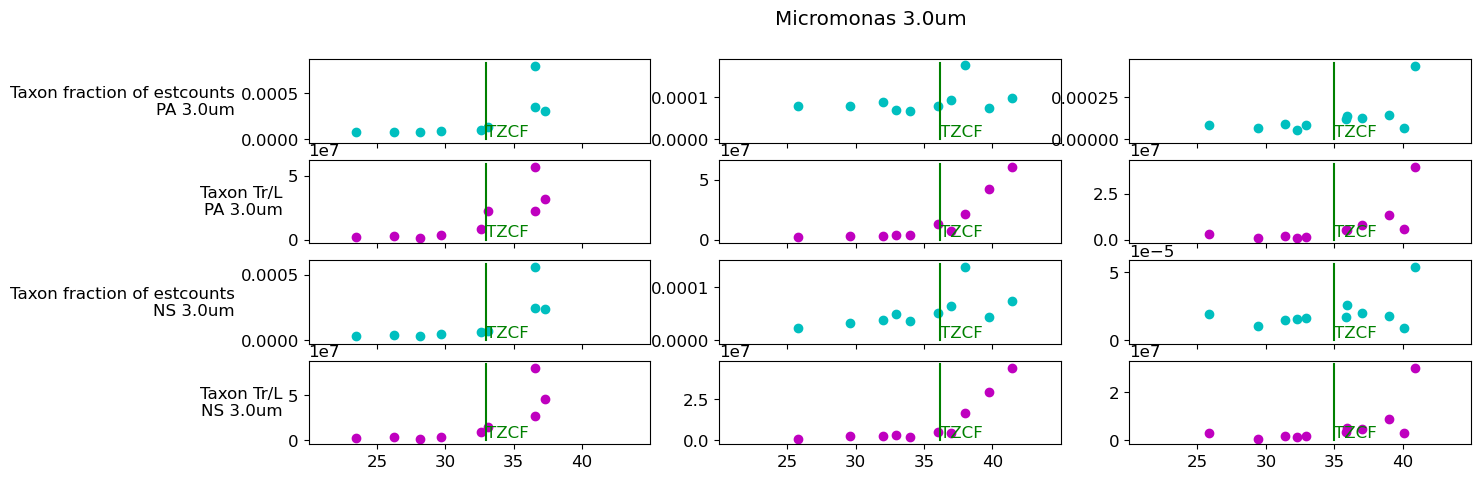

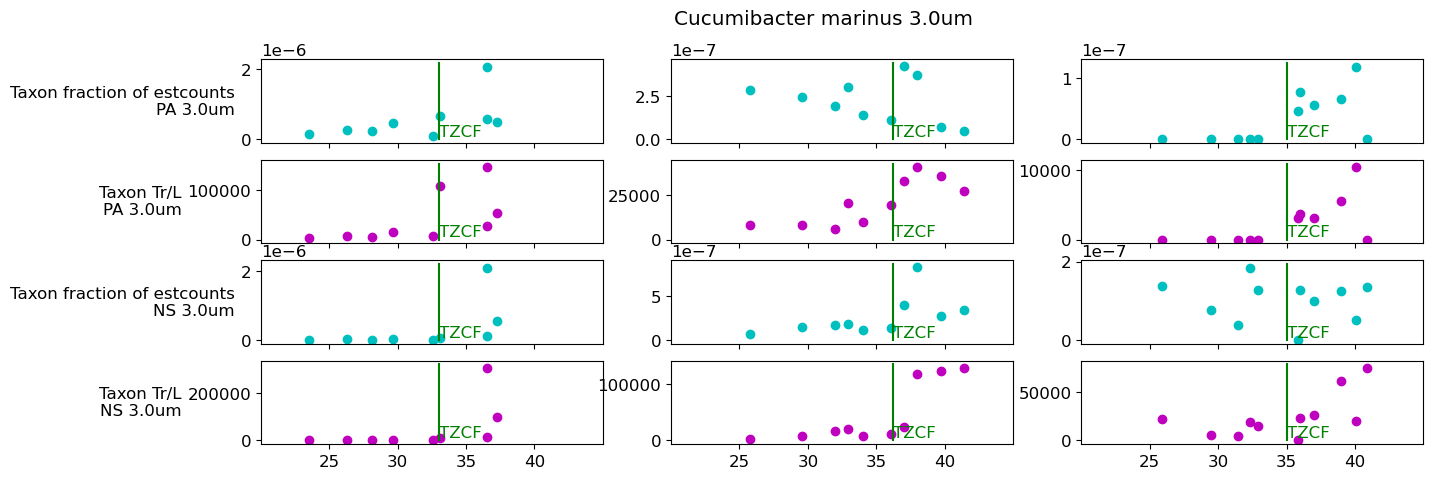

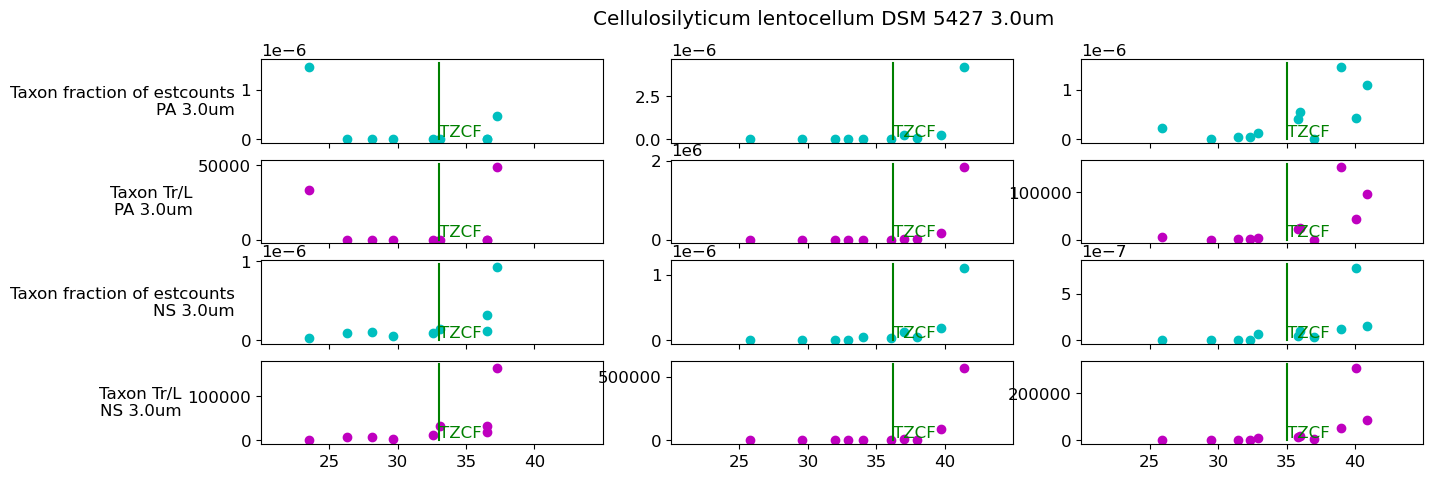

In [122]:
nplots = 3

dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':1,
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 2
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)

dict_size_taxa = dict_udir_size_taxa[udir]
for tsize, taxa in dict_size_taxa.items():
    dict_tax_name = ncbi.get_taxid_translator(taxa)
    for t in np.random.choice(taxa, nplots, replace=False):
        fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))
        tname = dict_tax_name.get(int(t))
        tname = tname if tname else t
        fig.suptitle(f'{tname} {tsize}')
        for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
            for batch, df in dict_batch_df.items():
                df = df.copy()
                row_meta = dict_batch_meta[batch]
                cruise = row_meta['cruise']
                size = row_meta['size']
                if cruise in dict_cruise_j:
                    if size == tsize:
                        j = dict_cruise_j[cruise]
                        sel = row_meta['selection']
                        seli = dict_selsz_i[sel]
                        i = i_ + 2 * seli
                        ax = axes[i,j]
                        lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
                        salf, tzcf = dict_cruise_trans_sal_chl[cruise]
                        if str(t) in df.columns:
                            vals = df[str(t)].values
                            color = dict_vt_color[vt]
                            ax.scatter(lats, vals, color=color)
                        ylims = ax.get_ylim()
                        ax.plot([tzcf]*2, (0,ylims[1]), 'g')
                        ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
                        xticks = np.arange(25,45,5).astype(int)
                        ax.set_xlim(20,45)
                        ax.set_xticks(xticks)
                        xticklab = xticks if i == nrows - 1 else []
                        ax.set_xticklabels(xticklab) 
                        ylab = dict_vt_ylab[vt]
                        if j == 0:
                            ax.set_ylabel(f'{ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
                        # else:
                        #     ax.set_yticklabels([])
        plt.show()

### Which taxa have increased abundance less than the rest of the community in the north?

Tree of taxa

In [102]:
udir = 'frac - S > N, trl - S < N'
dict_size_taxa = dict_udir_size_taxa[udir]
for size, taxa in dict_size_taxa.items():
    print('****',udir,'****')
    print('******', size,'****')
    taxa_trans = []
    if taxa:
        for t in taxa:
            n = ncbi.get_taxid_translator([t]).get(int(t))
            if n:
                tn = ncbi.get_name_translator([n])[n][0]
                taxa_trans.append(tn)
        tree = ncbi.get_topology(taxa_trans)
        print(tree.to_str(props=['sci_name'], compact=True))

**** frac - S > N, trl - S < N ****
****** 0.2um ****
**** frac - S > N, trl - S < N ****
****** 3.0um ****
                                                                                                  ╭╴Alexandrium minutum
                                                                                                  ├╴Alexandrium andersonii
                                                                                    ╭╴Alexandrium╶┼╴Alexandrium margalefii
                                                                    ╭╴Pyrocystaceae╶┤             ├╴Alexandrium monilatum
                                                                    │               │             ╰╴Alexandrium catenella
                                                    ╭╴Gonyaulacales╶┤               ╰╴Gambierdiscus australes
                                                    │               ├╴Crypthecodinium cohnii
                                                    │               ├╴Azadinium

Plot all profiles

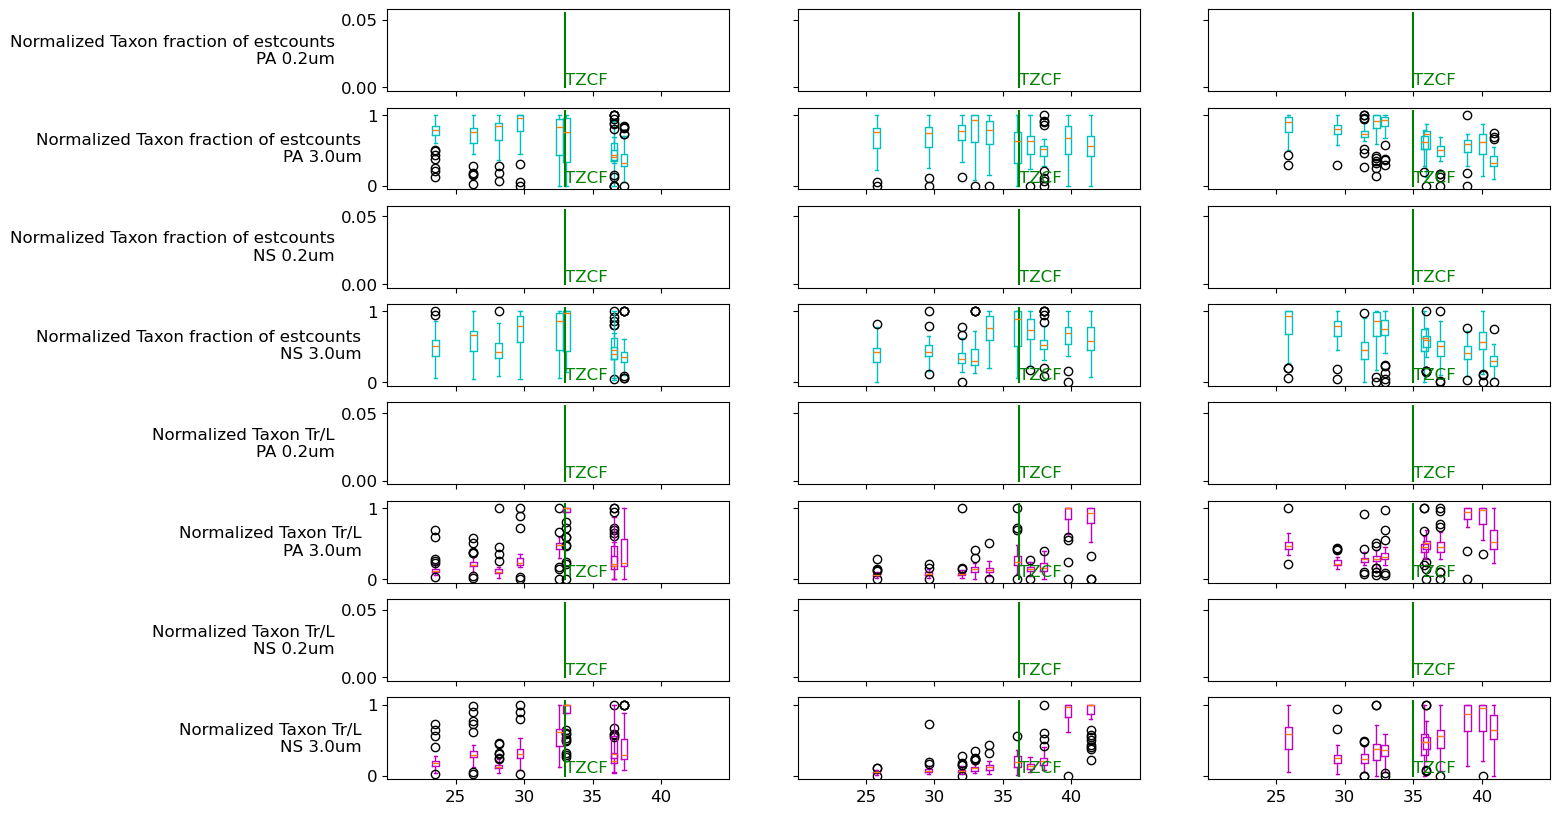

In [103]:
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':2,
    '0.2um':0,
    '3.0um':1
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 4
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,10))

for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
    for batch, df in dict_batch_df.items():
        row_meta = dict_batch_meta[batch]
        cruise = row_meta['cruise']
        df = df.copy()
        if cruise in dict_cruise_j:
            j = dict_cruise_j[cruise]
            sel = row_meta['selection']
            size = row_meta['size']
            seli = dict_selsz_i[sel]
            sizei = dict_selsz_i[size]
            i = i_ * 4 + (seli + sizei)
            ax = axes[i,j]
            lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
            salf, tzcf = dict_cruise_trans_sal_chl[cruise]
            taxa = dict_udir_size_taxa[udir][size]
            bool_tax = df.columns.astype(int).isin(taxa)
            vals = df.loc[:,bool_tax].values
            vals /= np.max(vals, axis=0)
            bp = ax.boxplot(vals.T, positions=lats)
            color = dict_vt_color[vt]
            for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                plt.setp(bp[item], color=color)
            ylims = ax.get_ylim()
            ax.plot([tzcf]*2, (0,ylims[1]), 'g')
            ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
            xticks = np.arange(25,45,5).astype(int)
            ax.set_xlim(20,45)
            ax.set_xticks(xticks)
            xticklab = xticks if i == nrows - 1 else []
            ax.set_xticklabels(xticklab) 
            ylab = dict_vt_ylab[vt]
            if j == 0:
                ax.set_ylabel(f'Normalized {ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
            else:
                ax.set_yticklabels([])

Plot specific profiles

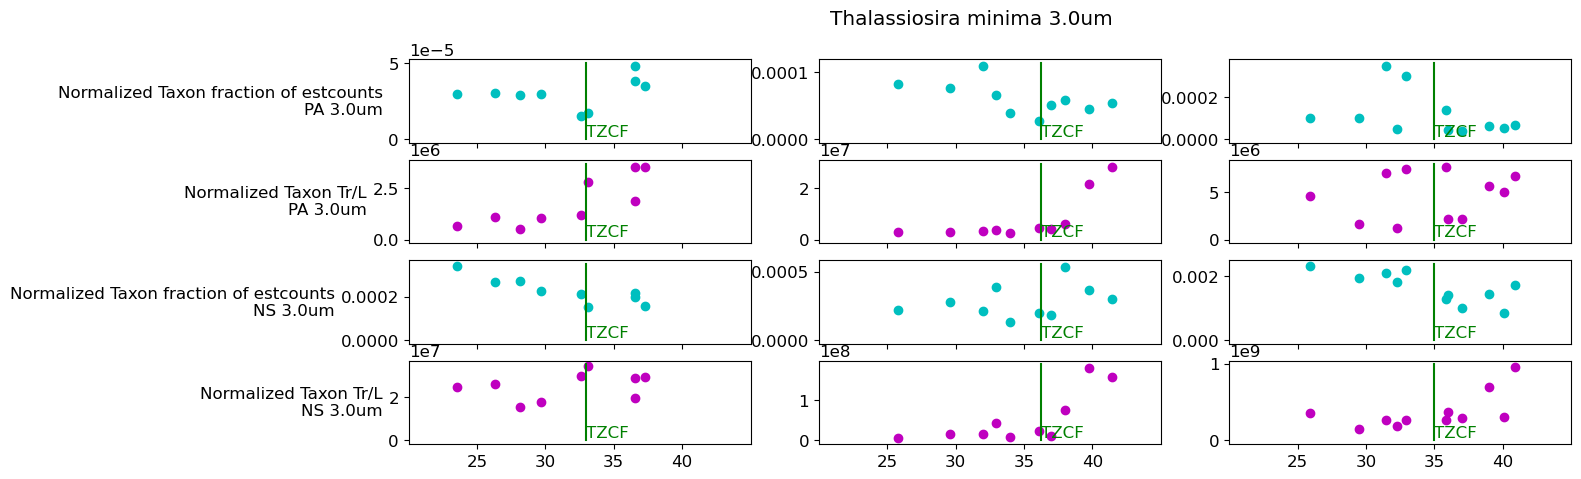

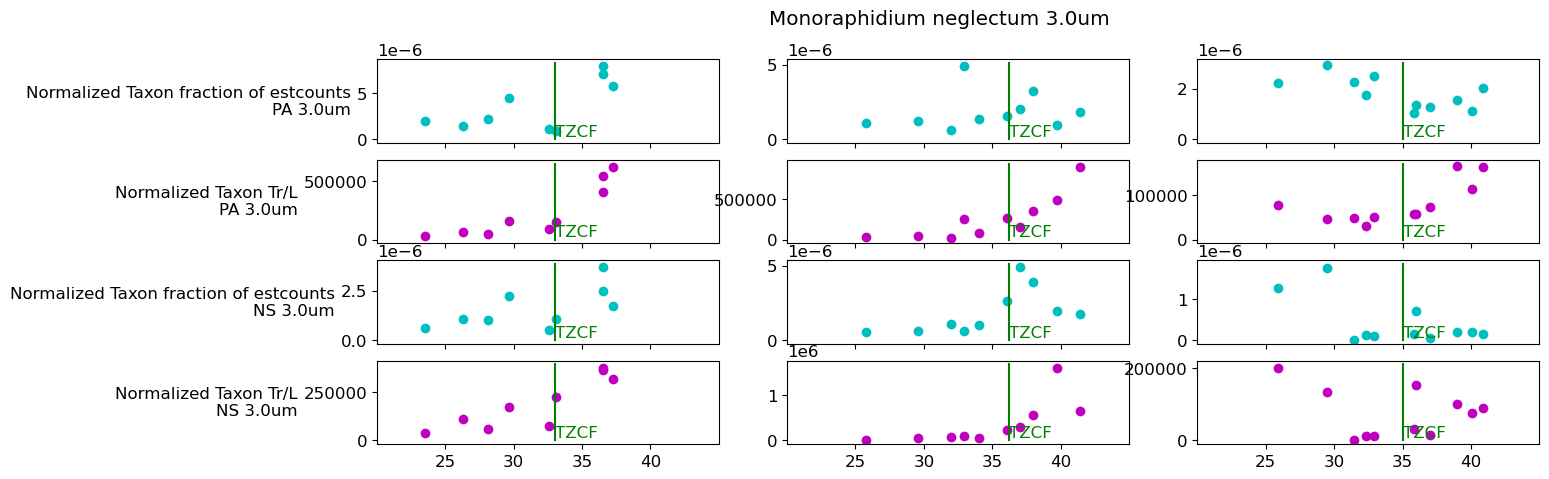

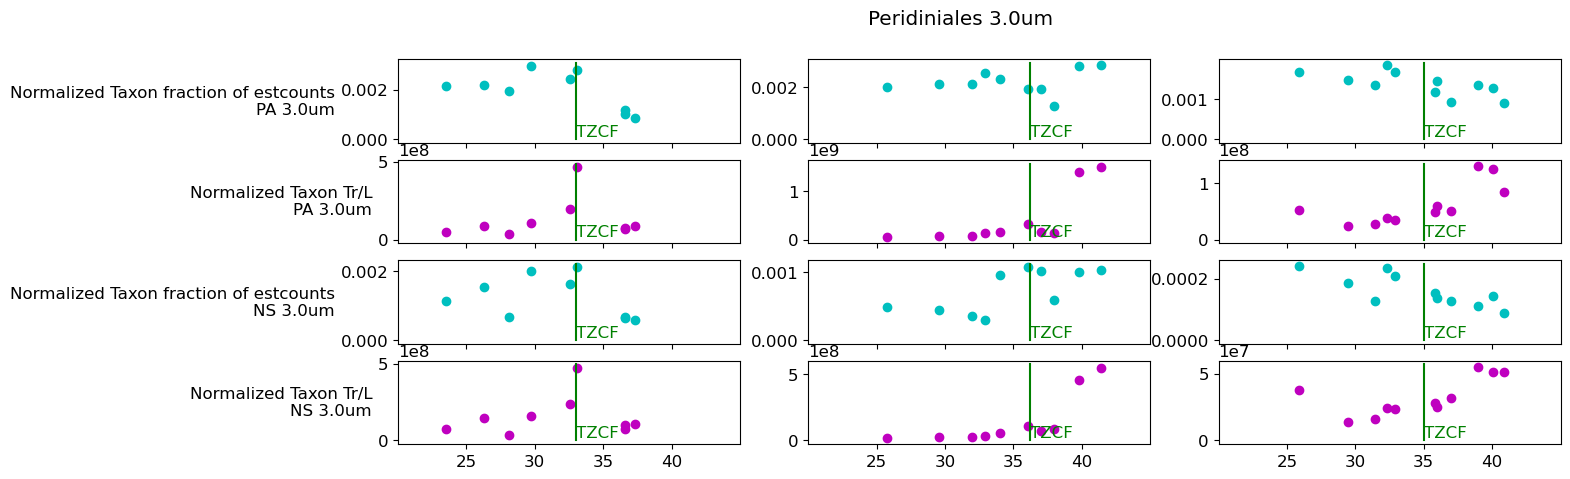

In [105]:
nplots = 3

dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':1,
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 2
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)

dict_size_taxa = dict_udir_size_taxa[udir]
for tsize, taxa in dict_size_taxa.items():
    dict_tax_name = ncbi.get_taxid_translator(taxa)
    if taxa:
        for t in np.random.choice(taxa, nplots, replace=False):
            fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))
            tname = dict_tax_name.get(int(t))
            tname = tname if tname else t
            fig.suptitle(f'{tname} {tsize}')
            for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
                for batch, df in dict_batch_df.items():
                    df = df.copy()
                    row_meta = dict_batch_meta[batch]
                    cruise = row_meta['cruise']
                    size = row_meta['size']
                    if cruise in dict_cruise_j:
                        if size == tsize:
                            j = dict_cruise_j[cruise]
                            sel = row_meta['selection']
                            seli = dict_selsz_i[sel]
                            i = i_ + 2 * seli
                            ax = axes[i,j]
                            lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
                            salf, tzcf = dict_cruise_trans_sal_chl[cruise]
                            if str(t) in df.columns:
                                vals = df[str(t)].values
                                color = dict_vt_color[vt]
                                ax.scatter(lats, vals, color=color)
                            ylims = ax.get_ylim()
                            ax.plot([tzcf]*2, (0,ylims[1]), 'g')
                            ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
                            xticks = np.arange(25,45,5).astype(int)
                            ax.set_xlim(20,45)
                            ax.set_xticks(xticks)
                            xticklab = xticks if i == nrows - 1 else []
                            ax.set_xticklabels(xticklab) 
                            ylab = dict_vt_ylab[vt]
                            if j == 0:
                                ax.set_ylabel(f'Normalized {ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
                            # else:
                            #     ax.set_yticklabels([])
            plt.show()

## Pick specific taxa

taxa

In [126]:
taxa_names = [
    'Thalassiosira aff. antarctica',
    'Thalassiosira bioculata',
    'Thalassiosira minima',
    'Minidiscus sp. RCC4590',
]
dict_name_taxa = ncbi.get_name_translator(taxa_names)
taxa = [dict_name_taxa[n][0] for n in taxa_names]
taxa

[420261, 1048533, 340022, 1960173]

Plot profiles

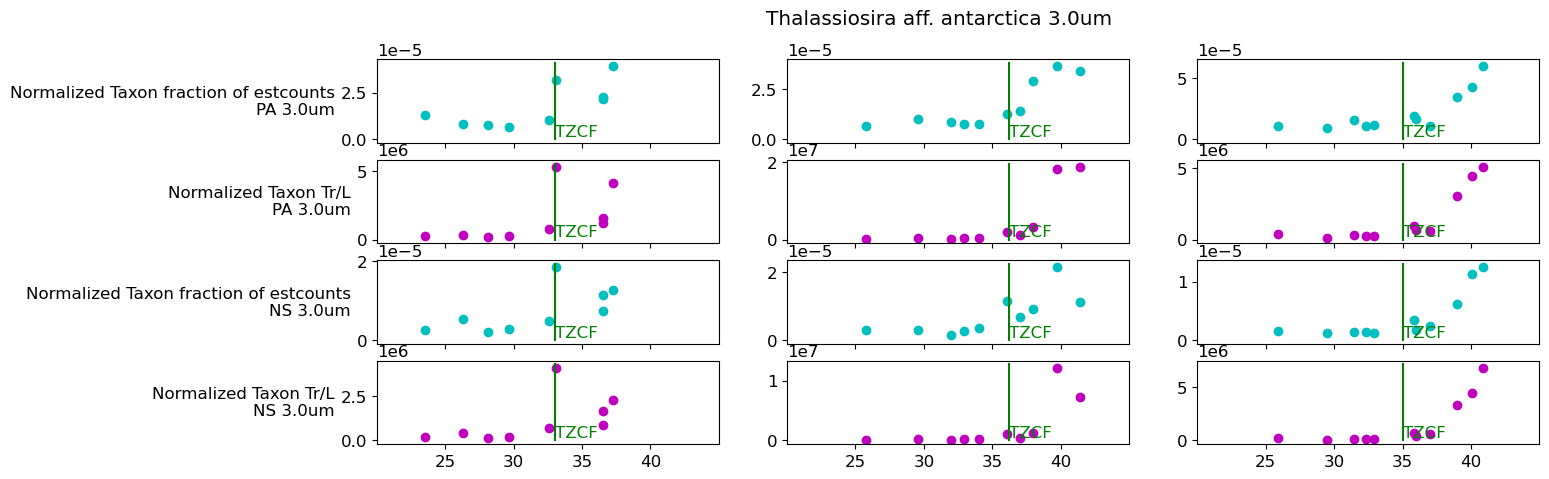

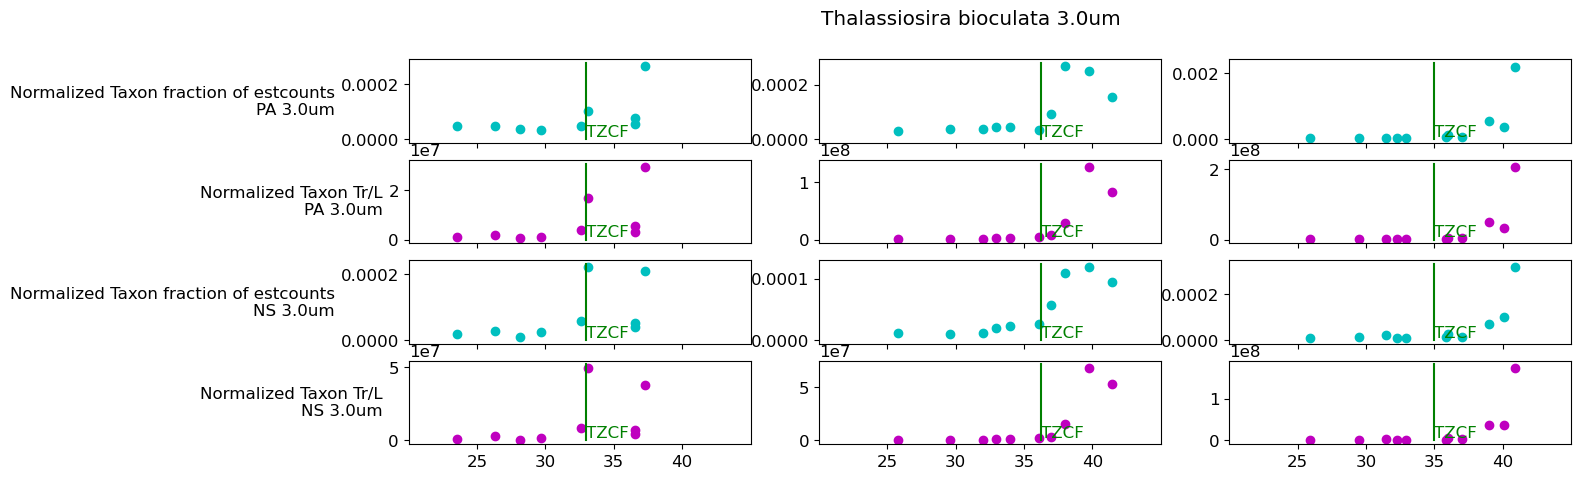

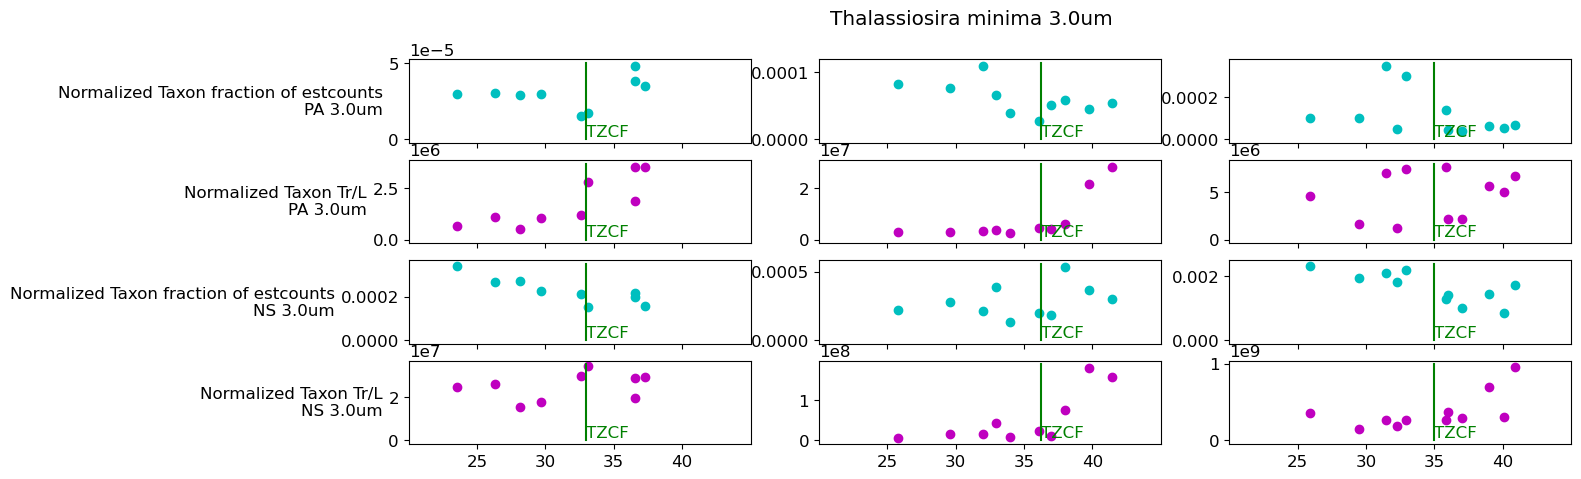

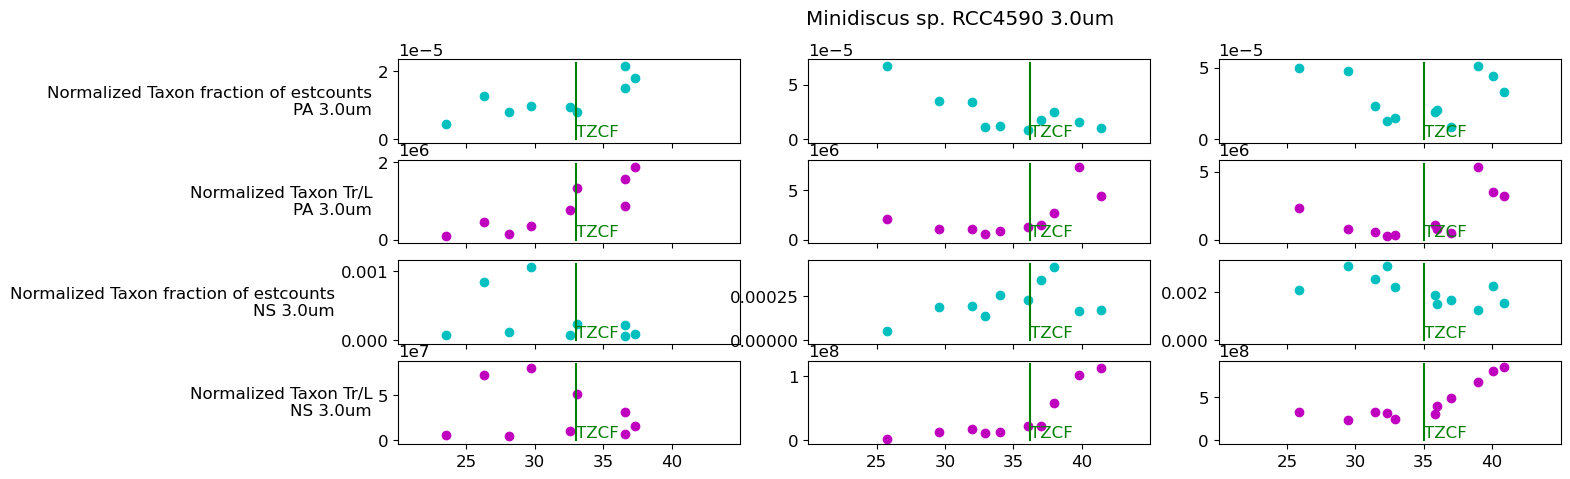

In [127]:
nplots = 3

dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
}
dict_selsz_i = {
    'PA':0,
    'NS':1,
}

dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
dict_vt_color = {
    'frac':'c',
    'trl':'m',
}
nrows = len(dict_valtype_batch_dfs) * 2
ncols = len(dict_cruise_j)
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)

dict_size_taxa = dict_udir_size_taxa[udir]
tsize = '3.0um'
dict_tax_name = ncbi.get_taxid_translator(taxa)
for t in taxa:
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))
    tname = dict_tax_name.get(int(t))
    tname = tname if tname else t
    fig.suptitle(f'{tname} {tsize}')
    for i_, (vt, dict_batch_df) in enumerate(dict_valtype_batch_dfs.items()):
        for batch, df in dict_batch_df.items():
            df = df.copy()
            row_meta = dict_batch_meta[batch]
            cruise = row_meta['cruise']
            size = row_meta['size']
            if cruise in dict_cruise_j:
                if size == tsize:
                    j = dict_cruise_j[cruise]
                    sel = row_meta['selection']
                    seli = dict_selsz_i[sel]
                    i = i_ + 2 * seli
                    ax = axes[i,j]
                    lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
                    salf, tzcf = dict_cruise_trans_sal_chl[cruise]
                    if str(t) in df.columns:
                        vals = df[str(t)].values
                        color = dict_vt_color[vt]
                        ax.scatter(lats, vals, color=color)
                    ylims = ax.get_ylim()
                    ax.plot([tzcf]*2, (0,ylims[1]), 'g')
                    ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
                    xticks = np.arange(25,45,5).astype(int)
                    ax.set_xlim(20,45)
                    ax.set_xticks(xticks)
                    xticklab = xticks if i == nrows - 1 else []
                    ax.set_xticklabels(xticklab) 
                    ylab = dict_vt_ylab[vt]
                    if j == 0:
                        ax.set_ylabel(f'Normalized {ylab}\n{sel} {size}', rotation=0, fontsize=ft0, ha='right', va='center')
                    # else:
                    #     ax.set_yticklabels([])
    plt.show()

In [131]:
math.factorial(10) / (math.factorial(6) * math.factorial(4))


210.0

In [132]:

1/210

0.004761904761904762

In [130]:
fn = '/scratch/bgrodner/adaptation_acclimation/metat_search_results/dicts/tidy_tables/merge_all/thalassiosiraceae_taxids.txt-tidy_all.csv'
taxa = []
with open(fn, 'r') as f:
    _ = next(f)
    for row in f:
        contig,fn_sample_counts,KO,taxon,estcounts = row.split(',')
        taxa.append(taxon)
set(taxa)

{'1048533', '1960173', '340022', '420261'}

## Look at gene expression in clusters

### Load data

Load dict of clusters

In [81]:
fn_clust = '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/dict_batch_clust_taxa-25_05_30.json'
with open(fn_clust, 'r') as f:
    dict_batch_clust_taxa = json.load(f)


Get dict mapping taxid to total estcounts for each 'batch'

In [82]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_batch_taxid_sam = defaultdict(
    lambda: defaultdict(dict)
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
        batch = f'{cruise}_{sel}_{size}'
        dict_batch_taxid_sam[batch][taxid][sam] = float(estcounts)
        # assm_sam = row_meta['assm_sample']
        # norm_factor = row_meta['norm_factor']
        # valtypes = ['frac','trl']
        # vals = [float(frac_total_estcounts), float(estcounts) * norm_factor]
        # Append taxon fraction of counts and transcripts per liter to separate dicts
        # for vt, v in zip(valtypes, vals):
            # dict_valtype_batch_tax_assam_vals[vt][batch][taxid][assm_sam].append(v)




Get dict of cluster to counts in cluster for each sample

In [83]:
dict_batch_clust_sam_ect = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(float)
    )
)
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    for clust, taxa in dict_clust_taxa.items():
        for t in taxa:
            for sam, ec in dict_batch_taxid_sam[batch][t].items():
                dict_batch_clust_sam_ect[batch][clust][sam] += ec



Load dict of iron ko info

In [84]:
fn_tidy_ironko = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_all.csv'

# open read 
dict_taxon_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(float)
    )
)
with open(fn_tidy_ironko, 'r') as fr:
    row = next(fr)
    for row in fr:
        contig, sample, ko, tax, estcounts = row.split(",")
        dict_taxon_ko_sample_estcounts[tax][ko][sample] += float(estcounts)

Get get ko relative abundance profile for each ko in each cluster

In [85]:
dict_batch_clust_ko_sam_frac = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    for clust, taxa in dict_clust_taxa.items():
        for t in taxa:
            dict_ko_sample_estcounts = dict_taxon_ko_sample_estcounts[t]
            for ko, dict_sample_estcounts in dict_ko_sample_estcounts.items():
                for sam, ec in dict_sample_estcounts.items():
                    row_meta = dict_meta[sam]
                    cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
                    batch_ = f'{cruise}_{sel}_{size}'
                    if batch_ == batch:
                        ect = dict_batch_clust_sam_ect[batch][clust][sam]
                        frac = ec / ect if ect > 0 else 0
                        dict_batch_clust_ko_sam_frac[batch][clust][ko][sam] = frac

### Get dict mapping taxid to frac and trl

In [86]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_batch_tax_assam_vals = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
        batch = f'{cruise}_{sel}_{size}'
        assm_sam = row_meta['assm_sample']
        norm_factor = row_meta['norm_factor']
        valtypes = ['frac','trl']
        vals = [float(frac_total_estcounts), float(estcounts) * norm_factor]
        # Append taxon fraction of counts and transcripts per liter to separate dicts
        for vt, v in zip(valtypes, vals):
            dict_valtype_batch_tax_assam_vals[vt][batch][taxid][assm_sam].append(v)




Geometric mean

In [87]:
# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(np.array(vector) + pseudocount))) - pseudocount

Get median value for each sample

In [30]:
dict_valtype_batch_tax_assam_medval = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for vt, dict_batch_tax_assam_vals in dict_valtype_batch_tax_assam_vals.items():
    for batch, dict_tax_assam_vals in dict_batch_tax_assam_vals.items():
        for tax, dict_assam_vals in dict_tax_assam_vals.items():
            for assam, vals in dict_assam_vals.items():
                dict_valtype_batch_tax_assam_medval[vt][batch][tax][assam] = (
                    geometric_mean(vals, pseudocount=1e-15)
                )


Get array of taxon x sample for Tr/l and fraction of taxon estcounts 

In [31]:
dict_valtype_batch_dfs = defaultdict(dict)
for vt, dict_batch_tax_assam_medval in dict_valtype_batch_tax_assam_medval.items():
    for batch, dict_tax_assam_medval in dict_batch_tax_assam_medval.items():
        df = pd.DataFrame(dict_tax_assam_medval).fillna(0)
        dict_valtype_batch_dfs[vt][batch] = df

### Within each cluster, cluster KOs by profile

Get df of sample x ko for each cluster

In [254]:
dict_batch_clust_df = defaultdict(dict)
for batch, dict_clust_ko_sam_frac in dict_batch_clust_ko_sam_frac.items():
    for clust, dict_ko_sam_frac in dict_clust_ko_sam_frac.items():
        dict_ko_assmsam_mfrac = defaultdict(dict)
        for ko, dict_sam_frac in dict_ko_sam_frac.items():
            dict_assmsam_fracs = defaultdict(list)
            for sam, frac in dict_sam_frac.items():
                assm_sam = dict_meta[sam]['assm_sample']
                dict_assmsam_fracs[assm_sam].append(frac)
            for assm_sam, fracs in dict_assmsam_fracs.items():
                dict_ko_assmsam_mfrac[ko][assm_sam] = geometric_mean(
                    fracs, pseudocount=1e-15
                )
        df = pd.DataFrame(dict_ko_assmsam_mfrac)
        dict_batch_clust_df[batch][clust] = df

Get similarity

In [255]:
thresh_clsize = 20

out_fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations'
    + '/{batch}/clusters/{cl}/{batch}_{cl}_ko_spearman_permutation_test_{rp}.npy'
)
dict_batch_clust_rhop = defaultdict(dict)
for batch, dict_clust_df in dict_batch_clust_df.items():
    print(batch)
    for clust, df in dict_clust_df.items():
        taxa = dict_batch_clust_taxa[batch][clust]
        if len(taxa) > thresh_clsize:
            vals = df.values.copy()
            r, p = fc.parallel_spearman_perm_test_low_mem(
                vals, 
                n_resamples=10000,
                batch_size=500,
                early_stop=True, 
                pval_tol=1e-3, 
                check_every=2000,
                threads=50
            )
            dict_batch_clust_rhop[batch][clust] = [r, p]
            for arr, rp in zip([r, p], ['rho','pval']):
                out_fn = out_fmt.format(batch=batch, cl=clust, rp=rp)
                out_dir = os.path.split(out_fn)[0]
                if not os.path.exists(out_dir): os.makedirs(out_dir)
                np.save(out_fn, arr)

/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


D1PA_PA_nan


Permuting:  40%|███████████████████▏                            | 4000/10000 [00:00<00:01, 5930.29it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76589.41it/s]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|███████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8842.85it/s]


G1_NS_0.2um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90814.30it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 92503.73it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83895.73it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90057.25it/s]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2997: RuntimeWarning: invalid value encountered in divide
  return c / c



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 87566.04it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 54102.42it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 79827.14it/s]



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41386.60it/s]


G1_NS_3.0um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 82724.22it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 93417.46it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 76360.73it/s]



Early stopping at 8000 permutations (max pval change: 6.25e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 56711.97it/s]



Early stopping at 8000 permutations (max pval change: 5.00e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 54744.85it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85437.19it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 58667.34it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 38881.19it/s]


G1_PA_0.2um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70788.75it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 82820.59it/s]



Early stopping at 8000 permutations (max pval change: 6.25e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 52240.73it/s]



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90944.76it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 88769.28it/s]



Early stopping at 6000 permutations (max pval change: 2.50e-04)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 83511.12it/s]



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 88896.27it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83168.34it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 54518.74it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19057.06it/s]


G1_PA_3.0um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79747.20it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 57371.34it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75099.11it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 61757.23it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79082.23it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 82681.00it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 84895.49it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 99159.64it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 61444.38it/s]



Early stopping at 10000 permutations (max pval change: 3.75e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 88838.38it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83404.83it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 57914.38it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13093.80it/s]


G2_NS_0.2um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83685.24it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 91606.69it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 87163.42it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86559.47it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 50348.04it/s]



Early stopping at 10000 permutations (max pval change: 9.25e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 51868.04it/s]


G2_NS_3.0um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85833.65it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 87712.54it/s]



Early stopping at 8000 permutations (max pval change: 7.08e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 48752.41it/s]



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 41641.61it/s]



Early stopping at 8000 permutations (max pval change: 5.42e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81073.24it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86550.09it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86168.25it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90124.01it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 84418.34it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 49730.80it/s]



Early stopping at 6000 permutations (max pval change: 5.00e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 84884.75it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 60656.47it/s]


G2_PA_0.2um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 52767.67it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86415.91it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83421.01it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 89100.46it/s]



Early stopping at 8000 permutations (max pval change: 8.33e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86721.44it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 55551.73it/s]



Early stopping at 6000 permutations (max pval change: 1.67e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77575.69it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 56666.61it/s]



Early stopping at 10000 permutations (max pval change: 9.00e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85718.75it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 52647.09it/s]


Early stopping at 10000 permutations (max pval change: 9.25e-04)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 98400.67it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85376.32it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 50913.12it/s]


G2_PA_3.0um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 89297.03it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 61494.42it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 92708.19it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90967.44it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 95282.86it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 88713.89it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80146.06it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75609.15it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 87603.99it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 61428.75it/s]



Early stopping at 6000 permutations (max pval change: 1.67e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86926.33it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 89816.68it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78960.15it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)
G3PA.PM_PA_0.2um


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12394.75it/s]


G3PA.PM_PA_3.0um


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11371.26it/s]


G3PA.diel_PA_0.2um


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 57424.44it/s]



Early stopping at 10000 permutations (max pval change: 7.25e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 17295.43it/s]


G3_NS_0.2um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85338.54it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 91543.71it/s]



Early stopping at 10000 permutations (max pval change: 2.50e-05)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65354.74it/s]



Early stopping at 10000 permutations (max pval change: 2.25e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 94625.61it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 87558.05it/s]



Early stopping at 8000 permutations (max pval change: 6.25e-04)


Permuting:   0%|                                                             | 0/10000 [00:00<?, ?it/s]


Early stopping at 4000 permutations (max pval change: 2.50e-04)


Permuting: 100%|███████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7086.23it/s]


G3_NS_3.0um


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 49491.19it/s]



Early stopping at 6000 permutations (max pval change: 9.17e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 86386.98it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 53681.16it/s]



Early stopping at 8000 permutations (max pval change: 4.17e-05)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 53441.86it/s]



Early stopping at 6000 permutations (max pval change: 1.67e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76194.61it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 49354.91it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 51578.93it/s]



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85906.60it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 92371.31it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)
G3_PA_0.2um


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 56804.52it/s]


Early stopping at 8000 permutations (max pval change: 3.75e-04)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78386.12it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 87747.86it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78949.00it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 51652.40it/s]



Early stopping at 6000 permutations (max pval change: 6.67e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 51574.12it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76041.63it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77135.56it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 17296.85it/s]


G3_PA_3.0um


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 88976.42it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 57248.32it/s]



Early stopping at 10000 permutations (max pval change: 5.00e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 93487.74it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 90848.73it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75069.87it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 54543.20it/s]



Early stopping at 8000 permutations (max pval change: 4.17e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 89693.75it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)


Get similarity matrix based on rho and p value

In [256]:
dict_batch_clust_sim = defaultdict(dict)
for batch, dict_clust_rhop in dict_batch_clust_rhop.items():
    for clust, (r, p) in dict_clust_rhop.items():
        s = fc.signed_spearman_similarity(r, p, method='expit',distance=False)
        dict_batch_clust_sim[batch][clust] = s

### Pick example cluster

Get data

In [459]:
batch = 'G2_NS_0.2um'
dict_clust_taxa = dict_batch_clust_taxa[batch]
dfs = [dict_valtype_batch_dfs[vt][batch] for vt in ['frac','trl']]



Pick a cluster

In [460]:
cl_szs = [len(t) for _, t in dict_clust_taxa.items()]
clsts = list(dict_clust_taxa.keys())
clsts = np.array([int(x) for _, x in sorted(zip(cl_szs, clsts))])
cl_szs = np.array(sorted(cl_szs))

clsts_filt = clsts[cl_szs > thresh_clsize]

ncols = 1
# nclst = np.sum(counts > filt_ntax)
nclst = len(clsts_filt)
nrows = nclst * 2

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclst / len(cmap))
lut = dict(zip(clsts_filt,cmap))

nclst

10

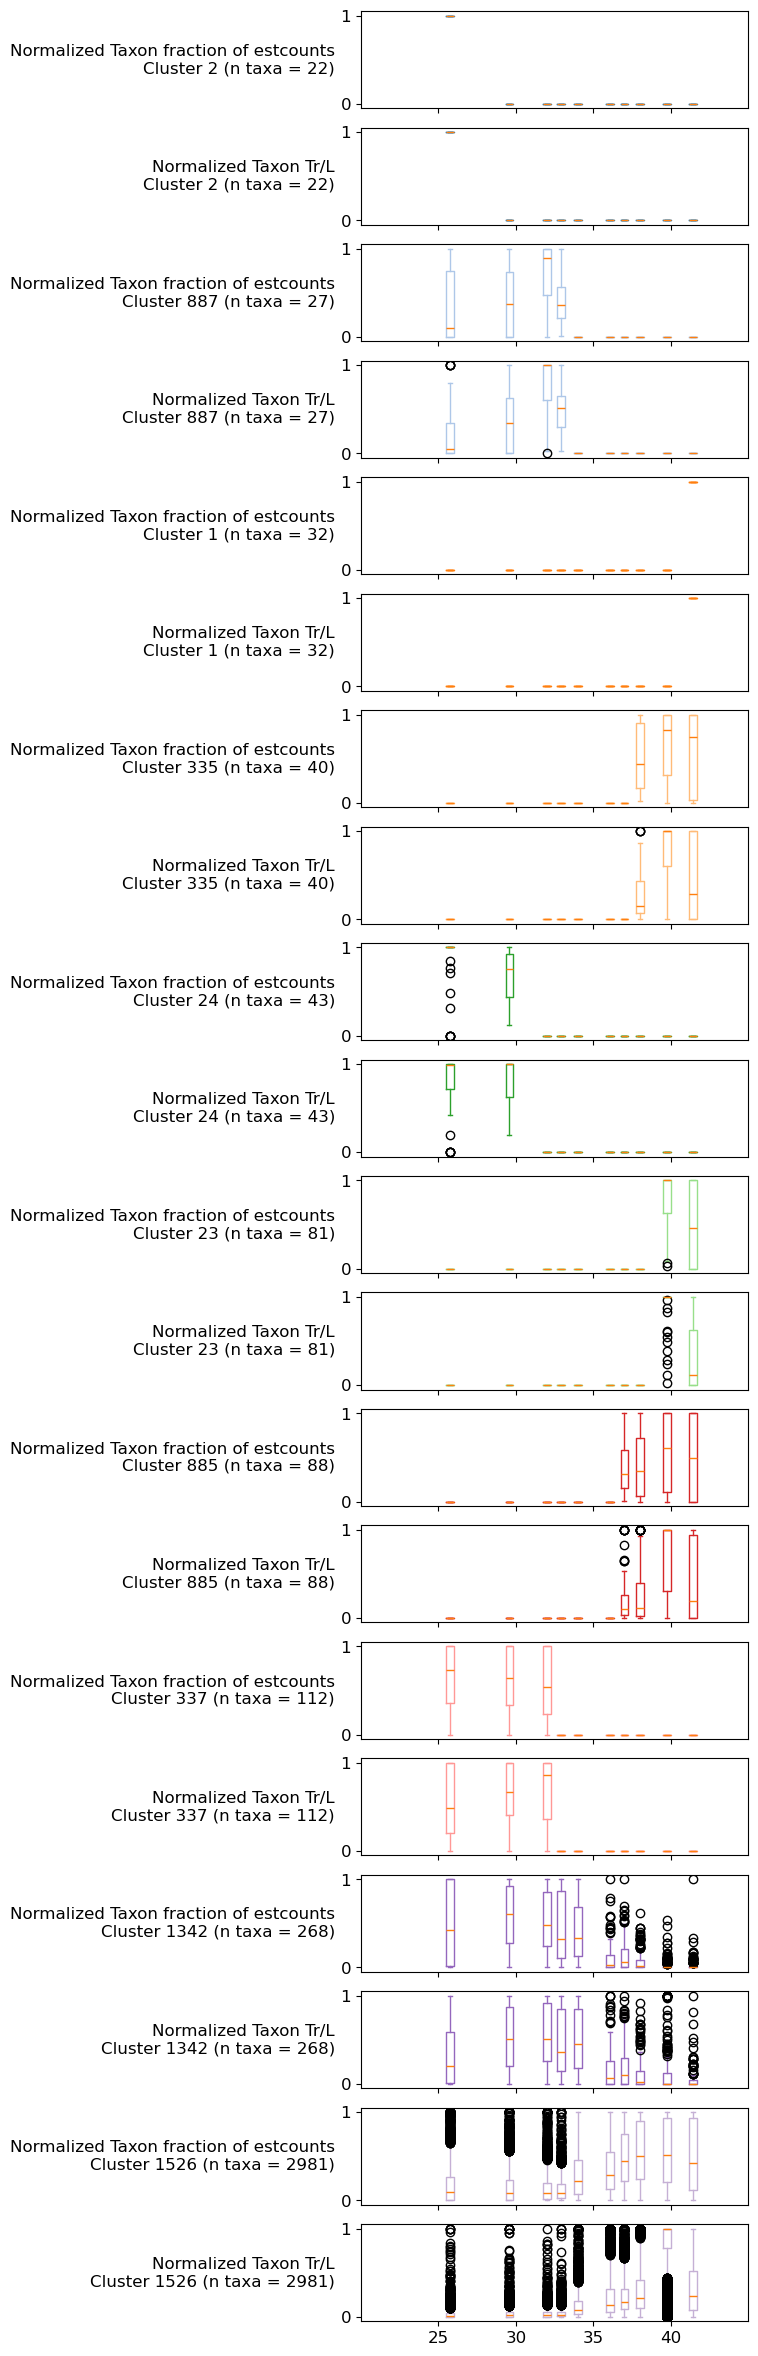

In [461]:


ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))
dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
for i, cl in enumerate(clsts_filt):
    taxa = dict_clust_taxa[str(cl)]
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        df_filt = df.copy()
        # df_filt = df.loc[:,bools_tax]
        df_filt = df_filt[taxa]
        i_ = i*2 + j
        ax = axes[i_]
        if batch == 'G3PA.diel_PA_0.2um':
            datetime = [dict_assam_time[a] for a in df_filt.index]
            date_time = [dt.split('-') for dt in datetime]
            date_time = [[d, t.zfill(5)] for d, t in date_time]
            datetime = [f'{d}-{t}' for d, t in date_time]
            df_filt[['date','time']] = date_time
            df_filt.index = datetime
            df_filt = df_filt.sort_values(by=['date','time'])
            df_filt = df_filt.drop(['date','time'], axis=1)
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        elif batch == 'D1PA_PA_nan':
            df_filt = df_filt.sort_index()
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        else:
            xticks = np.arange(25,45,5).astype(int)
            xticklab = xticks
            ax.set_xlim(20,45)
            lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
            rot = 0
        vals = df_filt.values
        vals /= np.max(vals, axis=0)
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        ax.set_xticks(xticks)
        xticklab = xticklab if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab, rotation=rot)
        ylab = dict_vt_ylab[vt]   
        ntaxa = len(taxa)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')    

In [324]:
cltax = '942'

### Cluster KOs in tax cluster

Get distance matrix

In [325]:
s = dict_batch_clust_sim[batch][cltax]
d = 1 - s
# replace nans
d[np.isnan(d)] = 2


Pick a distance threshold

In [326]:
link = hierarchy.linkage(distance.squareform(d, checks=False))
maxclusts = []
nclusts = []
ts = np.arange(0.001, 0.2, 0.001)
for t in ts:
    clust = hierarchy.fcluster(link, t=t, criterion='distance')
    clsts, counts = np.unique(clust, return_counts=True)
    maxclusts.append(np.max(counts))
    nclusts.append(clsts.shape[0])

In [327]:
dict_batch_cltax_t = {
    'G2_NS_0.2um': {
        '1526': 0.090,
        '1342': 0.1
    },
    'G3_NS_0.2um': {
        '942': 0.1,
    }
    
}

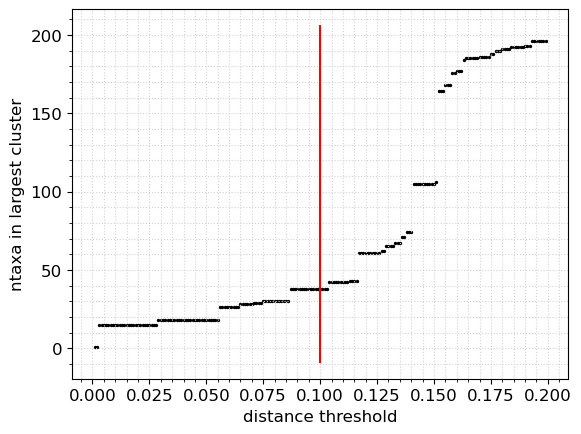

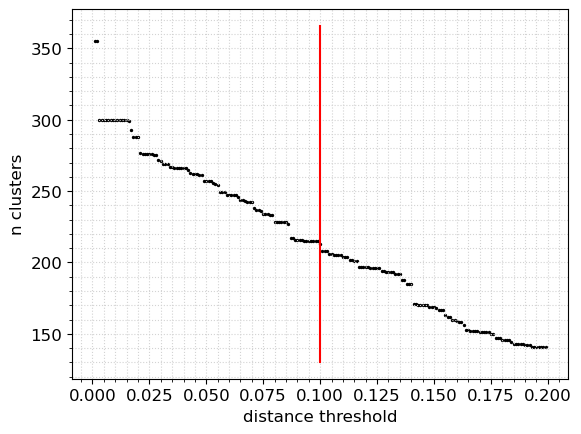

In [328]:
fig, ax = plt.subplots()
ax.scatter(ts, maxclusts, color='k', s=2)
# ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='both', linestyle=':', color='lightgray')
ax.set_ylabel('ntaxa in largest cluster')
ax.set_xlabel('distance threshold')
t = dict_batch_cltax_t[batch][cltax]
ylims = ax.get_ylim()
ax.plot([t,t],ylims,'r')

fig, ax = plt.subplots()
ax.scatter(ts, nclusts, color='k', s=2)
ax.minorticks_on()
ax.grid(which='both', linestyle=':', color='lightgray')
ax.set_ylabel('n clusters')
ax.set_xlabel('distance threshold')
t = dict_batch_cltax_t[batch][cltax]
ylims = ax.get_ylim()
ax.plot([t,t],ylims,'r')
# ax.set_yscale('log')

Show linkages

In [313]:
t = dict_batch_cltax_t[batch][cltax]
clust = hierarchy.fcluster(link, t=t, criterion='distance')

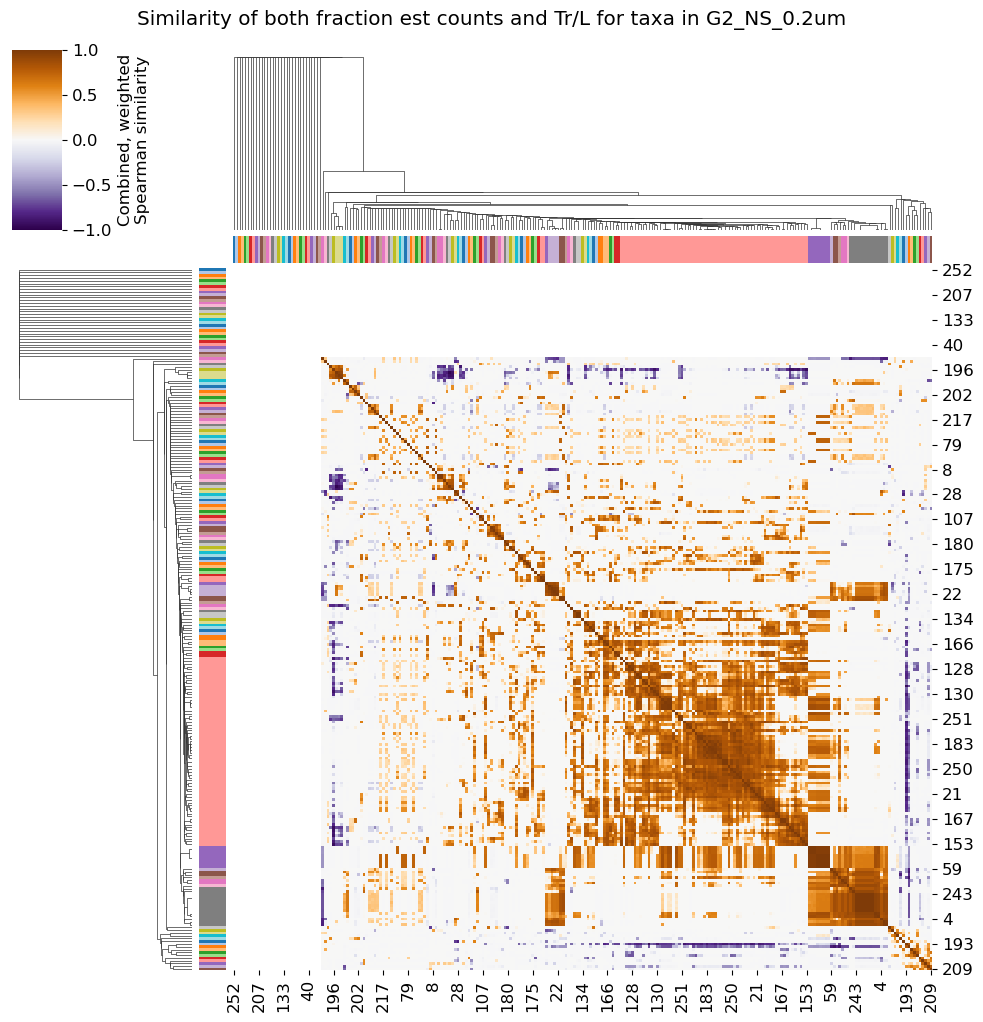

In [314]:
nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    s, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Combined, weighted\nSpearman similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of both fraction est counts and Tr/L for taxa in {batch}", y=1.02); 
plt.show(g)





np.int64(15)

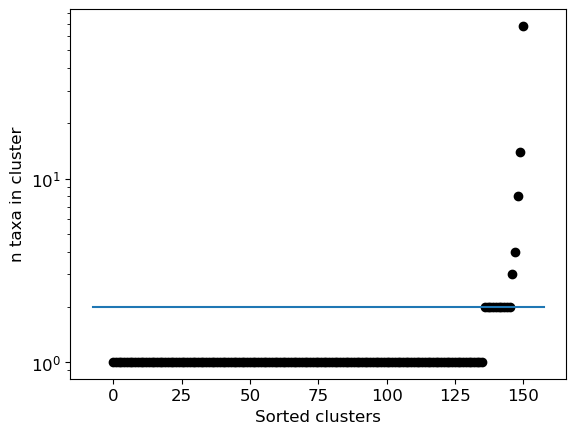

In [315]:
filt_ntax = 2
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted clusters')

sum(counts >= filt_ntax)

Get number of columns with filter

In [316]:
n_nonzero_sam = 3  # How many nonzero samples must the cluster have to be plotted?
bool_nonzero = []
for i, cl in enumerate(clsts):
    bool_cl = clust == cl
    vt = 'frac'
    df = dict_batch_clust_df[batch][cltax]
    df_filt = df.copy()
    # df_filt = df.loc[:,bools_tax]
    df_filt_ = df_filt.loc[:,bool_cl]
    bl = False
    if df_filt_.astype(bool).sum(axis=0).mean() > n_nonzero_sam:
        bl = True
    bool_nonzero.append(bl)

bool_clsz = counts > filt_ntax
clsts_filt = clsts[bool_clsz & bool_nonzero]

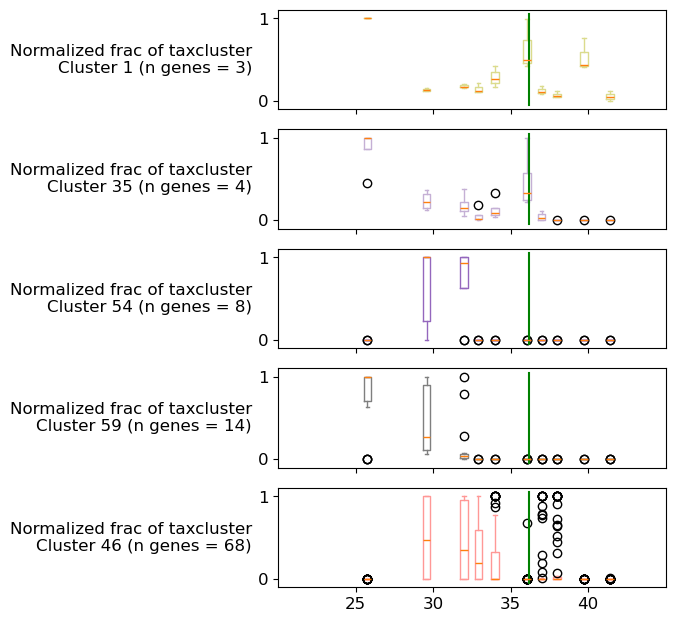

In [320]:

ncols = 1
# nclst = np.sum(counts > filt_ntax)
nclst = len(clsts_filt)
nrows = nclst

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))
dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    df = dict_batch_clust_df[batch][cltax]
    df_filt = df.copy()
    # df_filt = df.loc[:,bools_tax]
    df_filt = df_filt.loc[:,bool_cl]
    i_ = i
    ax = axes[i_]
    if batch == 'G3PA.diel_PA_0.2um':
        datetime = [dict_assam_time[a] for a in df_filt.index]
        date_time = [dt.split('-') for dt in datetime]
        date_time = [[d, t.zfill(5)] for d, t in date_time]
        datetime = [f'{d}-{t}' for d, t in date_time]
        df_filt[['date','time']] = date_time
        df_filt.index = datetime
        df_filt = df_filt.sort_values(by=['date','time'])
        df_filt = df_filt.drop(['date','time'], axis=1)
        xticks = np.arange(df_filt.shape[0])
        lats = xticks
        xticklab = df_filt.index
        rot = 45
    elif batch == 'D1PA_PA_nan':
        df_filt = df_filt.sort_index()
        xticks = np.arange(df_filt.shape[0])
        lats = xticks
        xticklab = df_filt.index
        rot = 45
    else:
        xticks = np.arange(25,45,5).astype(int)
        xticklab = xticks
        ax.set_xlim(20,45)
        lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
        rot = 0
    vals = df_filt.values
    vals /= np.max(vals, axis=0)
    bp = ax.boxplot(vals.T, positions=lats)
    color = lut[cl]
    for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp[item], color=color)
    ax.set_xticks(xticks)
    xticklab = xticklab if i_ == nrows - 1 else []
    ax.set_xticklabels(xticklab, rotation=rot)
    ylab = dict_vt_ylab[vt]   
    ntaxa = sum(bool_cl)
    ax.set_ylabel(f'Normalized frac of taxcluster\nCluster {cl} (n genes = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')
    cruise = dict_batch_meta[batch]['cruise']
    _, tzcf = dict_cruise_trans_sal_chl[cruise]
    ylims = ax.get_ylim()
    ax.plot([tzcf]*2, ylims, 'g')

Get genes in cluster

In [318]:
clgenes = [1, 35, 54, 59, 46]
for clgene in clgenes:
    print('\n\n',clgene)
    df = dict_batch_clust_df[batch][cltax]
    kos_cl = df.columns[clust == clgene]
    for ko in kos_cl:
        print('\t',dict_ko_name[ko])



 1
	 K02696  psaI; photosystem I subunit VIII
	 K02711  psbJ; photosystem II PsbJ protein
	 K02722  psbX; photosystem II PsbX protein


 35
	 K01623  ALDO; fructose-bisphosphate aldolase, class I [EC:4.1.2.13]
	 K04090  E1.2.7.8; indolepyruvate ferredoxin oxidoreductase [EC:1.2.7.8]
	 K11532  glpX-SEBP; fructose-1,6-bisphosphatase II / sedoheptulose-1,7-bisphosphatase [EC:3.1.3.11 3.1.3.37]
	 K04789  mbtE; mycobactin peptide synthetase MbtE


 54
	 K00927  PGK, pgk; phosphoglycerate kinase [EC:2.7.2.3]
	 K04781  mbtI, irp9, ybtS; salicylate synthetase [EC:5.4.4.2 4.2.99.21]
	 K02010  afuC, fbpC; iron(III) transport system ATP-binding protein [EC:7.2.2.7]
	 K07214  fes; iron(III)-enterobactin esterase [EC:3.1.1.108]
	 K14689  SLC30A2, ZNT2; solute carrier family 30 (zinc transporter), member 2
	 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
	 K00360  nasB; assimilatory nitrate reductase electron transfer subunit [EC:1.7.99.-]
	 K04788  m

## Correlate genes with Taxon Tr/L

Correlate pca profile for taxon tr/l with each iron gene

In [334]:
w = 3  # Window size for smoothing
thresh_clsize = 20
out_fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations'
    + '/{batch}/clusters/{cl}'
    + '/{batch}_{cl}-clustprofile_ironko-geom_mean_window_{w}-spearman_permutation_test-{rp}.npy'
)
dict_batch_clust_rhop = defaultdict(dict)
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    # Get sapmle x taxon values for tr/L
    df = dict_valtype_batch_dfs['trl'][batch]
    for clust, taxa in dict_clust_taxa.items():
        if len(taxa) > thresh_clsize:
            if clust in dict_batch_clust_df[batch]:
                # Subset to cluster
                df_clt = df[taxa].copy()
                # Get sample profile for taxa
                pca = decomposition.PCA(n_components=1)
                pca.fit(df_clt.values.T)
                cltax_profile = pca.components_.squeeze()[:,None]
                # Smooth profile with geometric mean
                cltax_profile_sm = fc.moving_geometric_mean(cltax_profile, w)

                # Get sample x gene values for fraction of estcounts
                df_clg = dict_batch_clust_df[batch][clust].copy()
                vals_clg = df_clg.values
                # Smooth the profile 
                vals_clg_sm = fc.moving_geometric_mean(vals_clg, w)

                # correlate 
                r, p = fc.parallel_spearman_perm_test_low_mem_2(
                    vals_clg_sm, 
                    cltax_profile_sm,
                    n_resamples=10000,
                    batch_size=500,
                    early_stop=True, 
                    pval_tol=1e-3, 
                    check_every=2000,
                    threads=50
                )

                dict_batch_clust_rhop[batch][clust] = [r, p]
                for arr, rp in zip([r, p], ['rho','pval']):
                    out_fn = out_fmt.format(batch=batch, cl=clust, w=w, rp=rp)
                    out_dir = os.path.split(out_fn)[0]
                    if not os.path.exists(out_dir): os.makedirs(out_dir)
                    np.save(out_fn, arr)

Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31082.04it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|███████████████████▏                            | 4000/10000 [00:00<00:00, 7390.14it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 76885.64it/s]



Early stopping at 8000 permutations (max pval change: 2.92e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76448.76it/s]



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31615.92it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 67278.68it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71993.35it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81604.82it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76264.58it/s]



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 83529.41it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79578.87it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70795.32it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70899.73it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75729.62it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81009.43it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75907.79it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 82015.15it/s]



Early stopping at 10000 permutations (max pval change: 6.25e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 80288.93it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 8000 permutations (max pval change: 9.58e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 69987.01it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 86747.29it/s]



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 80887.77it/s]



Early stopping at 8000 permutations (max pval change: 4.17e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 80918.16it/s]



Early stopping at 10000 permutations (max pval change: 7.25e-04)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 81277.09it/s]



Early stopping at 6000 permutations (max pval change: 6.67e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81194.48it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 85032.10it/s]



Early stopping at 8000 permutations (max pval change: 4.17e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 87984.02it/s]



Early stopping at 10000 permutations (max pval change: 3.00e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 82454.67it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 10000 permutations (max pval change: 5.00e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 62817.43it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78204.52it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:   0%|                                                             | 0/10000 [00:00<?, ?it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)

Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74926.72it/s]


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 73959.27it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77140.17it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 72119.12it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 75052.64it/s]



Early stopping at 6000 permutations (max pval change: 9.17e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 77007.18it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81397.36it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75092.72it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 83403.67it/s]



Early stopping at 10000 permutations (max pval change: 1.25e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 73110.86it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75946.28it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81549.29it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79847.02it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75738.17it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 79804.10it/s]



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 81011.20it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 8000 permutations (max pval change: 4.17e-05)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75825.46it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 79492.53it/s]



Early stopping at 6000 permutations (max pval change: 8.33e-04)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 83166.96it/s]



Early stopping at 6000 permutations (max pval change: 5.00e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 80764.38it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81173.66it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79645.36it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 79881.16it/s]


Early stopping at 10000 permutations (max pval change: 6.25e-04)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80976.59it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78719.71it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77494.35it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77936.78it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75144.52it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 82016.51it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79241.72it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 77740.25it/s]


Early stopping at 10000 permutations (max pval change: 2.00e-04)



/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70163.50it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78307.46it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 84464.83it/s]



Early stopping at 10000 permutations (max pval change: 2.00e-04)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 60990.32it/s]



Early stopping at 8000 permutations (max pval change: 3.33e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74620.13it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78250.85it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76501.75it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78148.06it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75138.46it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 72208.83it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77618.39it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 63885.22it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75474.79it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30664.76it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 85404.57it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 85794.67it/s]



Early stopping at 10000 permutations (max pval change: 3.25e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31620.93it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75845.68it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80739.27it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79701.74it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80089.82it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70627.53it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 63060.86it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76818.40it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78500.18it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70061.83it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 2.50e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81866.04it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77654.32it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81358.28it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75970.01it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 72316.52it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 81975.24it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 82476.15it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32083.20it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80805.76it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80957.05it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 71637.50it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76988.31it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77529.08it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79383.45it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78125.50it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80982.06it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79153.87it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 84512.49it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70171.43it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 85930.58it/s]



Early stopping at 8000 permutations (max pval change: 7.50e-04)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 59460.86it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 73061.00it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29402.95it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77827.95it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  60%|████████████████████████████▏                  | 6000/10000 [00:00<00:00, 74898.51it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 6000 permutations (max pval change: 4.17e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77627.73it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79541.52it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 72465.83it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74904.30it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29631.19it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74606.19it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 84850.40it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80731.89it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75865.23it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 72729.39it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 67377.02it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74387.87it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79265.31it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 82738.09it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77483.25it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 70676.92it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74090.24it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75637.78it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)



Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 83351.30it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 10000 permutations (max pval change: 7.75e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75633.69it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75028.92it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 73149.87it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75812.78it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 79570.95it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 54056.58it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 77779.96it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31411.96it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78832.89it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 74224.63it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30703.37it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80018.01it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 75210.21it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 78372.20it/s]



Early stopping at 4000 permutations (max pval change: 7.50e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 80073.77it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 71072.13it/s]



Early stopping at 4000 permutations (max pval change: 0.00e+00)


Permuting:  80%|█████████████████████████████████████▌         | 8000/10000 [00:00<00:00, 78118.95it/s]
/scratch/bgrodner/iron_ko_contigs/../repo-armbrust-metat-search/functions/fn_correlation.py:33: RuntimeWarning: invalid value encountered in log
  moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))



Early stopping at 8000 permutations (max pval change: 7.08e-04)


Permuting:  40%|██████████████████▊                            | 4000/10000 [00:00<00:00, 76528.62it/s]


Early stopping at 4000 permutations (max pval change: 0.00e+00)


Get test correlation

In [462]:
batch = 'G2_NS_0.2um'
cltax = '1526'
r, p = dict_batch_clust_rhop[batch][cltax]

Get profile

In [463]:
df = dict_valtype_batch_dfs['trl'][batch].copy()
taxa = dict_batch_clust_taxa[batch][cltax]
df_clt = df[taxa]
# Get sample profile for taxa
pca = decomposition.PCA(n_components=1)
pca.fit(df_clt.values.T)
cltax_profile = pca.components_.squeeze()[:,None]


Plot r and p values

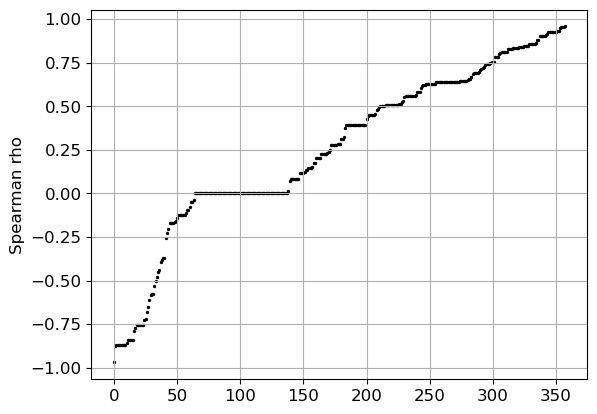

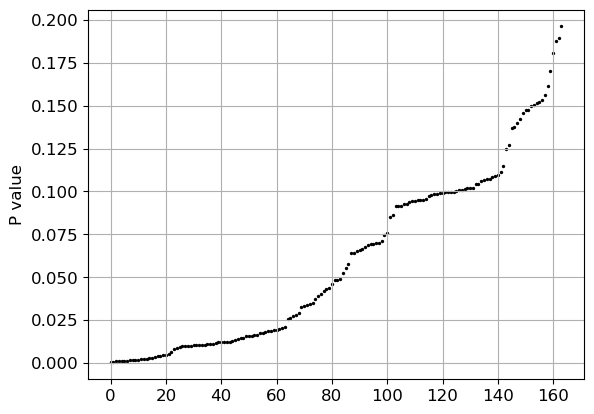

In [464]:
fig, ax = plt.subplots()
y = np.sort(r.squeeze())
# y = y[y > 0]
x = np.arange(y.shape[0])
ax.scatter(x, y, color='k', s=2)
ax.set_ylabel('Spearman rho')
ax.grid(which='both')

fig, ax = plt.subplots()
y = np.sort(p.squeeze())
y = y[y < 0.2]
x = np.arange(y.shape[0])
ax.scatter(x, y, color='k', s=2)
ax.set_ylabel('P value')
ax.grid(which='both')


In [466]:
thresh_p = 0.05
thresh_r = 0.65

Plot correlated genes

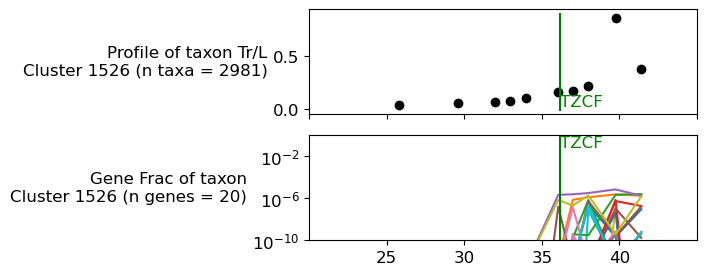

In [476]:
df = dict_batch_clust_df[batch][cltax].copy()
bool_p = p < thresh_p
bool_r = r > thresh_r
df_filt = df.iloc[:,bool_p & bool_r]
# Get sample profile for taxa
pcag = decomposition.PCA(n_components=2)
pcag.fit(df_filt.values.T)
clg_profile = pcag.components_.squeeze()[1,:]

xticks = np.arange(25,45,5).astype(int)
xticklab = xticks
lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
rot = 0

fig, axes = plt.subplots(2, 1,figsize=(5,3))

# Taxon profile
ax = axes[0]
ax.scatter(lats, cltax_profile, color='k')
# vals = df_clt.values
# vals /= np.max(vals, axis=0)
# bp = ax.boxplot(vals.T, positions=lats)

ax.set_xlim(20,45)
ax.set_xticklabels([])
ax.set_ylabel(f'Profile of taxon Tr/L\nCluster {cl} (n taxa = {df_clt.shape[1]})', rotation=0, fontsize=ft0, ha='right', va='center')    
cruise = dict_batch_meta[batch]['cruise']
_, tzcf = dict_cruise_trans_sal_chl[cruise]
ylims = ax.get_ylim()
ax.plot([tzcf]*2, ylims, 'g')
ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')

# Gene profiles
ax = axes[1]
# ax.scatter(lats, clg_profile, color='k')
ngenestoplot = 20
idxs = np.random.choice(np.arange(df_filt.shape[1]), ngenestoplot, replace=False)
for idx in idxs:
    vals = df_filt.values[:, idx]
    # vals /= np.max(vals)
    vals_sort = [x for _, x in sorted(zip(lats, vals))]
    lats_sort = sorted(lats)
    ax.plot(lats_sort, vals_sort)
# vals = df_filt.values
# vals /= np.mean(vals, axis=0)
# bp = ax.boxplot(vals.T, positions=lats)

ax.set_xlim(20,45)
ax.set_xticks(xticks)
xticklab = xticklab if i_ == nrows - 1 else []
ax.set_xticklabels(xticklab, rotation=rot)
ylab = dict_vt_ylab[vt]   
ntaxa = len(taxa)
ax.set_ylabel(f'Gene Frac of taxon\nCluster {cl} (n genes = {ngenestoplot})', rotation=0, fontsize=ft0, ha='right', va='center')    
# ax.set_ylabel(f'Normalized Gene Frac of taxon\nCluster {cl} (n genes = {df_filt.shape[1]})', rotation=0, fontsize=ft0, ha='right', va='center')    
cruise = dict_batch_meta[batch]['cruise']
_, tzcf = dict_cruise_trans_sal_chl[cruise]
ax.set_yscale('log')
# ylims = ax.get_ylim()
ylims = (1e-10,1)
ax.set_ylim(ylims)
ax.plot([tzcf]*2, ylims, 'g')
ax.text(tzcf, ylims[0], 'TZCF', color='g', ha='left', va='bottom');

Names of correlated genes

In [477]:
kos_cl = df_filt.columns
for ko in kos_cl:
    print(dict_ko_name[ko])

K00174  korA, oorA, oforA; 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit alpha [EC:1.2.7.3 1.2.7.11]
K00204  fwdH; 4Fe-4S ferredoxin
K00367  narB; ferredoxin-nitrate reductase [EC:1.7.7.2]
K00368  nirK; nitrite reductase (NO-forming) [EC:1.7.2.1]
K00528  fpr; ferredoxin/flavodoxin---NADP+ reductase [EC:1.18.1.2 1.19.1.1]
K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]
K01673  cynT, can; carbonic anhydrase [EC:4.2.1.1]
K01726  GAMMACA; gamma-carbonic anhydrase [EC:4.2.1.-]
K02013  ABC.FEV.A; iron complex transport system ATP-binding protein [EC:7.2.2.-]
K02361  entC; isochorismate synthase [EC:5.4.4.2]
K02363  entE, dhbE, vibE, mxcE; 2,3-dihydroxybenzoate---[aryl-carrier protein] ligase [EC:6.3.2.14 6.2.1.71]
K02573  napG; ferredoxin-type protein NapG
K02598  nirC; nitrite transporter
K03832  tonB; periplasmic protein TonB
K03863  vanB; vanillate monooxygenase ferredoxin subunit
K04017  nrfF; formate-dependent nitrite reductase complex subunit NrfF
K04783  irp5, ybtE; 

Plot anticorrelated genes

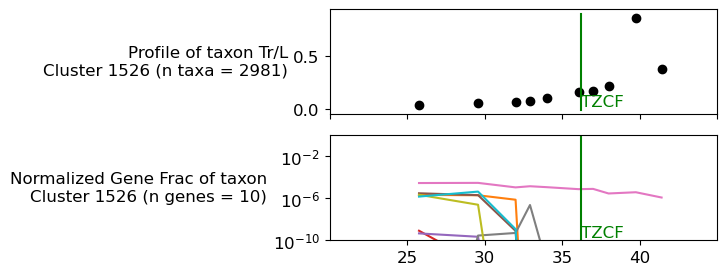

In [478]:
df = dict_batch_clust_df[batch][cltax].copy()
bool_p = p < thresh_p
bool_r = r < -thresh_r
df_filt = df.iloc[:,bool_p & bool_r]
# Get sample profile for taxa
pcag = decomposition.PCA(n_components=2)
pcag.fit(df_filt.values.T)
clg_profile = pcag.components_.squeeze()[1,:]

xticks = np.arange(25,45,5).astype(int)
xticklab = xticks
lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
rot = 0

fig, axes = plt.subplots(2, 1,figsize=(5,3))

# Taxon profile
ax = axes[0]
ax.scatter(lats, cltax_profile, color='k')
# vals = df_clt.values
# vals /= np.max(vals, axis=0)
# bp = ax.boxplot(vals.T, positions=lats)

ax.set_xlim(20,45)
ax.set_xticklabels([])
ax.set_ylabel(f'Profile of taxon Tr/L\nCluster {cl} (n taxa = {df_clt.shape[1]})', rotation=0, fontsize=ft0, ha='right', va='center')    
cruise = dict_batch_meta[batch]['cruise']
_, tzcf = dict_cruise_trans_sal_chl[cruise]
ylims = ax.get_ylim()
ax.plot([tzcf]*2, ylims, 'g')
ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')

# Gene profiles
ax = axes[1]
# ax.scatter(lats, clg_profile, color='k')
ngenestoplot = 10
idxs = np.random.choice(np.arange(df_filt.shape[1]), ngenestoplot, replace=False)
for idx in idxs:
    vals = df_filt.values[:, idx]
    # vals /= np.max(vals)
    vals_sort = [x for _, x in sorted(zip(lats, vals))]
    lats_sort = sorted(lats)
    ax.plot(lats_sort, vals_sort)
# vals = df_filt.values
# vals /= np.mean(vals, axis=0)
# bp = ax.boxplot(vals.T, positions=lats)

ax.set_xlim(20,45)
ax.set_xticks(xticks)
xticklab = xticklab if i_ == nrows - 1 else []
ax.set_xticklabels(xticklab, rotation=rot)
ylab = dict_vt_ylab[vt]   
ntaxa = len(taxa)
ax.set_ylabel(f'Normalized Gene Frac of taxon\nCluster {cl} (n genes = {ngenestoplot})', rotation=0, fontsize=ft0, ha='right', va='center')    
# ax.set_ylabel(f'Normalized Gene Frac of taxon\nCluster {cl} (n genes = {df_filt.shape[1]})', rotation=0, fontsize=ft0, ha='right', va='center')    
cruise = dict_batch_meta[batch]['cruise']
_, tzcf = dict_cruise_trans_sal_chl[cruise]
ax.set_yscale('log')
ylims = ax.get_ylim()
ylims = (1e-10,1)
ax.set_ylim(ylims)
ax.plot([tzcf]*2, ylims, 'g')
ax.text(tzcf, ylims[0], 'TZCF', color='g', ha='left', va='bottom');

Names of anticorrelated genes

In [479]:
kos_cl = df_filt.columns
for ko in kos_cl:
    print(dict_ko_name[ko])

K00171  porD; pyruvate ferredoxin oxidoreductase delta subunit [EC:1.2.7.1]
K01743  E4.2.1.1; carbonic anhydrase [EC:4.2.1.1]
K04641  bop; bacteriorhodopsin
K07684  narL; two-component system, NarL family, nitrate/nitrite response regulator NarL
K11107  yfaE; ferredoxin
K11606  sitD; manganese/iron transport system permease protein
K18248  andAb; anthranilate 1,2-dioxygenase ferredoxin component
K23184  fecE; ferric citrate transport system ATP-binding protein [EC:7.2.2.18]
K25130  fecE, cbrD; iron-siderophore transport system ATP-binding protein [EC:7.2.2.-]
K25290  fhuA, ftsA, siuA; ferric hydroxamate/heme transport system ATP-binding protein [EC:7.2.2.16]
K00371  narH, narY, nxrB; nitrate reductase / nitrite oxidoreductase, beta subunit [EC:1.7.5.1 1.7.99.-]
K00374  narI, narV; nitrate reductase gamma subunit [EC:1.7.5.1 1.7.99.-]
K02446  glpX; fructose-1,6-bisphosphatase II [EC:3.1.3.11]
K11532  glpX-SEBP; fructose-1,6-bisphosphatase II / sedoheptulose-1,7-bisphosphatase [EC:3.1.3.

## Get overlap in Northern genes in Northern taxa between cruises

Get set of genes for each batch

In [505]:
list(dict_batch_clust_kospos[batch].keys())

['1554',
 '1561',
 '1591',
 '1595',
 '1599',
 '1618',
 '1624',
 '26',
 '283',
 '284',
 '285',
 '401',
 '402',
 '846']

In [501]:
thresh_p = 0.05
thresh_r = 0.5

dict_batch_clust_kospos = defaultdict(dict)
for batch, dict_clust_rhop in dict_batch_clust_rhop.items():
    for clust, (r, p) in dict_clust_rhop.items():
        df = dict_batch_clust_df[batch][clust].copy()
        kos = df.columns.values
        bool_p = (p < thresh_p).squeeze()
        bool_r = (r > thresh_r).squeeze()
        kos_filt = kos[bool_p & bool_r]
        dict_batch_clust_kospos[batch][clust] = kos_filt.tolist()


Get taxon clusters with the same pattern

In [38]:
bp[]

TypeError: 'builtin_function_or_method' object is not iterable

In [58]:
np.sort(df_filt.index.copy())

array(['G3PA-UW25-25.87deg-4_11_19-5:45-7.0m-3.0um',
       'G3PA-UW29-29.46deg-4_12_19-5:50-7.0m-3.0um',
       'G3PA-UW31#2-31.43deg-4_27_19-5:53-7.0m-3.0um',
       'G3PA-UW32#3-32.93deg-4_22_19-5:56-7.0m-3.0um',
       'G3PA-UW32-32.3deg-4_13_19-5:47-7.0m-3.0um',
       'G3PA-UW35#2-35.83deg-4_26_19-5:55-7.0m-3.0um',
       'G3PA-UW35-35.96deg-4_14_19-5:53-7.0m-3.0um',
       'G3PA-UW37-37.0deg-4_19_19-18:47-7.0m-3.0um',
       'G3PA-UW38-38.97deg-4_15_19-5:37-7.0m-3.0um',
       'G3PA-UW40#2-40.09deg-4_25_19-6:01-7.0m-3.0um',
       'G3PA-UW40-40.88deg-4_24_19-5:57-7.0m-3.0um'], dtype=object)

G3_NS_0.2um


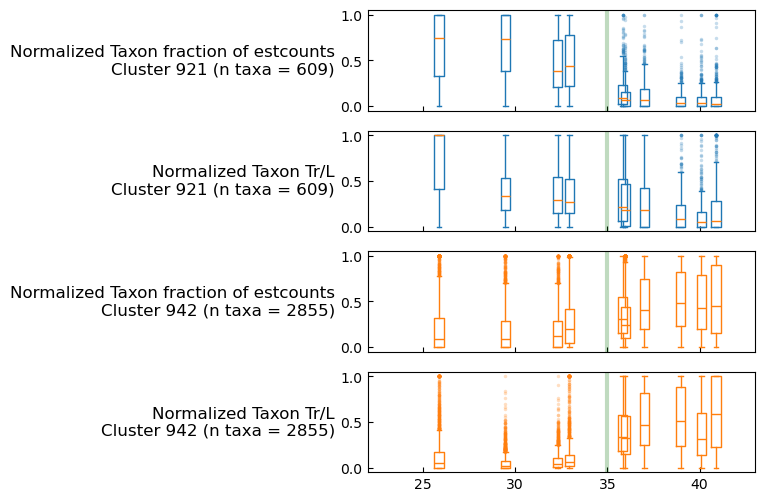

G3_NS_3.0um


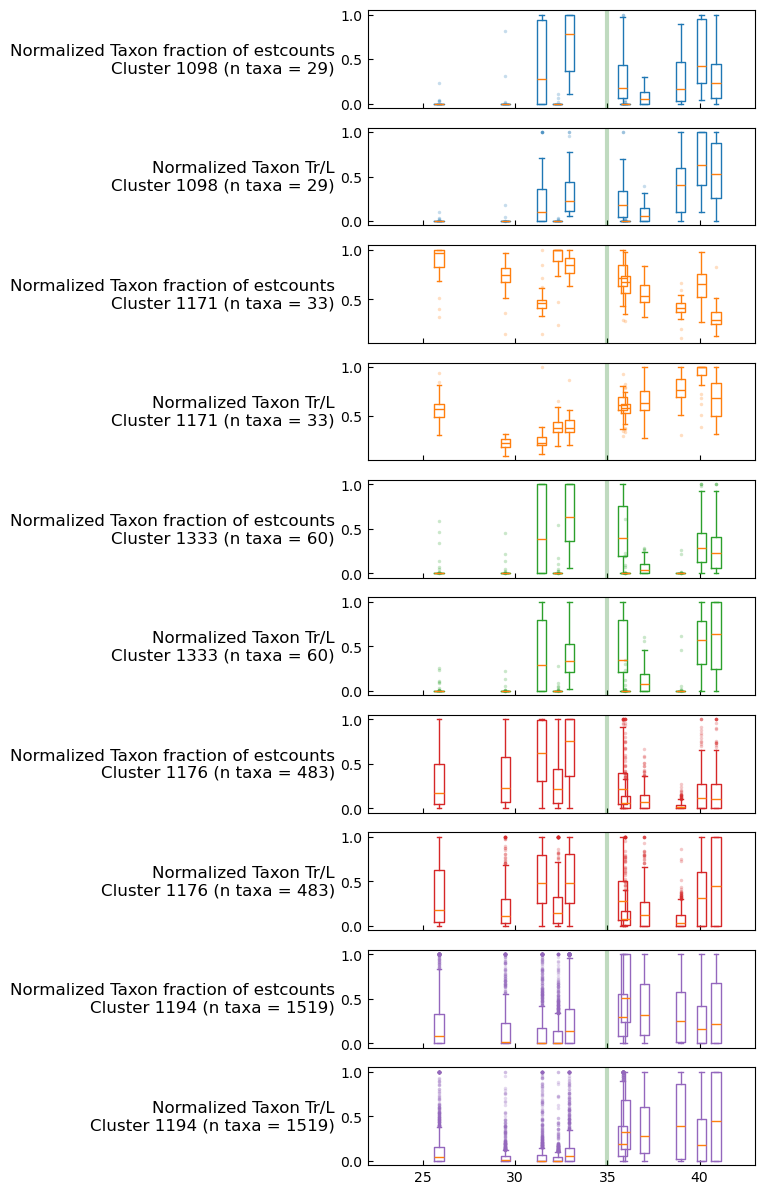

G3_PA_0.2um


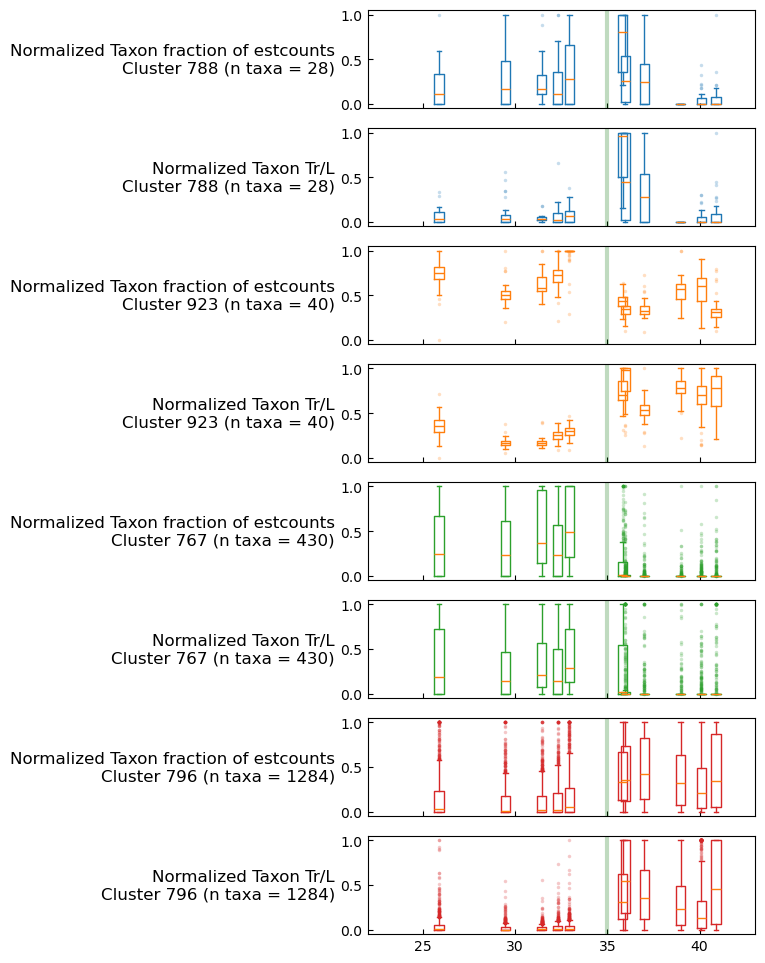

G3_PA_3.0um


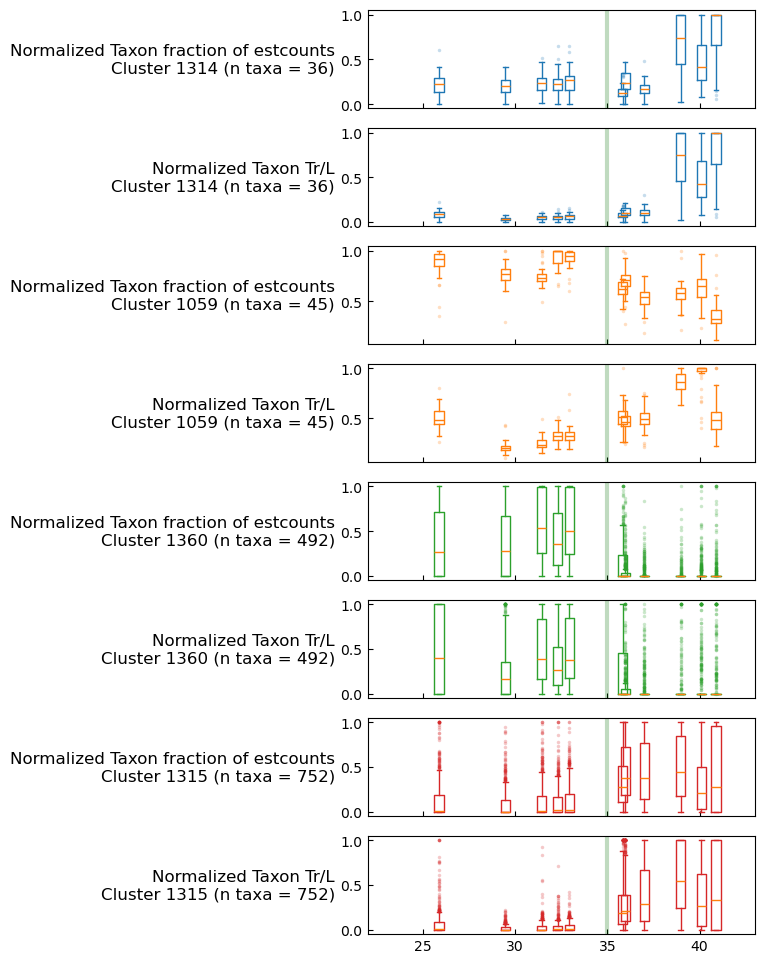

In [79]:
thresh_clsize = 25

thresh_ngt0 = 5

for k, (batch, dict_clust_taxa) in enumerate(dict_batch_clust_taxa.items()):
    cruise = dict_batch_meta[batch]['cruise']
    if cruise == 'G3':
        print(batch)
        cl_szs = [len(t) for _, t in dict_clust_taxa.items()]
        clsts = list(dict_clust_taxa.keys())
        clsts = np.array([int(x) for _, x in sorted(zip(cl_szs, clsts))])
        cl_szs = np.array(sorted(cl_szs))
        clsts_filt_ = clsts[cl_szs > thresh_clsize]

        clsts_filt = []
        for i, cl in enumerate(clsts_filt_):
            taxa = dict_clust_taxa[str(cl)]
            df = dict_valtype_batch_dfs['frac'][batch]
            df_filt = df.copy()
            # df_filt = df.loc[:,bools_tax]
            df_filt = df_filt[taxa]
            ngt0 = df_filt.astype(bool).sum(axis=0).mean()
            if ngt0 > thresh_ngt0:
                clsts_filt.append(cl)

        ncols = 1
        # nclst = np.sum(counts > filt_ntax)
        nclst = len(clsts_filt)
        nrows = nclst * 2

        cmap = list(plt.get_cmap('tab10').colors)
        cmap *= math.ceil(nclst / len(cmap))
        lut = dict(zip(clsts_filt,cmap))



        ft0=12

        dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))
        dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))

        # initialize plot
        fig, axes = plt.subplots(
            nrows=nrows, 
            ncols=ncols, 
            figsize=(ncols*5,nrows*1.5)
        )
        dict_vt_ylab = {
            'frac': 'Taxon fraction of estcounts',
            'trl': 'Taxon Tr/L',
        }
        for i, cl in enumerate(clsts_filt):
            taxa = dict_clust_taxa[str(cl)]
            for j, vt in enumerate(['frac','trl']):
                df = dict_valtype_batch_dfs[vt][batch]
                df_filt = df.copy()
                # df_filt = df.loc[:,bools_tax]
                df_filt = df_filt[taxa]

                i_ = i*2 + j
                ax = axes[i_]

                tzcf = 0
                cruise = dict_batch_meta[batch]['cruise']

                if batch == 'G3PA.diel_PA_0.2um':
                    datetime = [dict_assam_time[a] for a in df_filt.index]
                    date_time = [dt.split('-') for dt in datetime]
                    date_time = [[d, t.zfill(5)] for d, t in date_time]
                    datetime = [f'{d}-{t}' for d, t in date_time]
                    df_filt[['date','time']] = date_time
                    df_filt.index = datetime
                    df_filt = df_filt.sort_values(by=['date','time'])
                    df_filt = df_filt.drop(['date','time'], axis=1)
                    xticks = np.arange(df_filt.shape[0])
                    lats = xticks
                    xticklab = df_filt.index
                    rot = 45
                elif batch == 'D1PA_PA_nan':
                    df_filt = df_filt.sort_index()
                    xticks = np.arange(df_filt.shape[0])
                    lats = xticks
                    xticklab = df_filt.index
                    rot = 45
                else:
                    xticks = np.arange(25,45,5).astype(int)
                    xticklab = xticks
                    ax.set_xlim(22,43)
                    lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
                    rot = 0
                    _, tzcf = dict_cruise_trans_sal_chl[cruise]
                vals = df_filt.values
                vals /= np.max(vals, axis=0)
                color = lut[cl]
                flierprops = dict(marker='.', markerfacecolor=color, markersize=5,
                    linestyle='none', markeredgecolor='none', alpha=0.25)
                bp = ax.boxplot(vals.T, positions=lats, flierprops=flierprops)
                for item in ['boxes', 'whiskers','caps']:
                    plt.setp(bp[item], color=color)
                ax.set_xticks(xticks)
                xticklab = xticklab if i_ == nrows - 1 else []
                ax.set_xticklabels(xticklab, rotation=rot)
                ylab = dict_vt_ylab[vt]   
                ntaxa = len(taxa)
                ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')  
                ax.tick_params(direction="in")  
                if tzcf:
                    ylims = ax.get_ylim()
                    ax.set_ylim(ylims)
                    ax.plot([tzcf]*2, ylims, color=(0,111/256,1/256), lw=3, alpha=0.25)
                    # ax.text(tzcf, ylims[1]-0.01, 'TZCF', color='g', ha='left', va='top');
        plt.show()


Create a dict for mapping clusters together

In [88]:
dict_batch_clust_cltype = {
    'G1_NS_0.2um':{
        1624: 'frac_N-trl_N',
        1618: 'frac_S-trl_S',
        1595: 'frac_S-trl_S',
        1561: 'frac_~CF-trl_~CF',
    },
    'G1_NS_3.0um': {
        1470: 'frac_N-trl_N',
        1434: 'frac_S-trl_S',
        1442: 'frac_S-trl_S',
        1306: 'frac_~CF-trl_~CF',
        1278: 'frac_~CF-trl_~CF',
        1345: 'frac_~CF-trl_~CF',
    },
    'G1_PA_0.2um': {
        637: 'frac_S-trl_S',
        604: 'frac_N-trl_N',
        596: 'frac_N-trl_N',
        636: 'frac_-trl_N',
        656: 'frac_S-trl_N',
        630: 'frac_S-trl_N',
        537: 'frac_~CF-trl_~CF',
    },
    'G1_PA_3.0um': {
        906: 'frac_~CF-trl_~CF',
        1074: 'frac_~CF-trl_~CF',
        1083: 'frac_~CF-trl_~CF',
        947: 'frac_CF-trl_CF',
        918: 'frac_S-trl_CF',
        941: 'frac_S-trl_S',
        941: 'frac_N-trl_N',
    },
    'G2_NS_0.2um': {
        1342: 'frac_S-trl_S',
        1526: 'frac_N-trl_N',
    },
    'G2_NS_3.0um': {
        1392: 'frac_CF-trl_CF',
        1525: 'frac_-trl_~CF',
        1547: 'frac_~CF-trl_~CF',
        1481: 'frac_~CF-trl_~CF',
        1541: 'frac_~CF-trl_~CF',
        1545: 'frac_~CF-trl_~CF',
        1549: 'frac_S-trl_S',
        1531: 'frac_N-trl_N',
    },
    'G2_PA_0.2um': {
        1180: 'frac_N-trl_N',
        1027: 'frac_-trl_N',
        1372: 'frac_~CF-trl_~CF',
        1290: 'frac_CF-trl_CF',
        1481: 'frac_S-trl_S',
        1313: 'frac_N-trl_N',
    },
    'G2_PA_3.0um': {
        1796: 'frac_-trl_N',
        1567: 'frac_S-trl_S',
        1566: 'frac_S-trl_S',
        1417: 'frac_N-trl_N',
    },
    'G3_NS_0.2um': {
        921: 'frac_S-trl_S',
        942: 'frac_N-trl_N',
    },
    'G3_NS_3.0um': {
        1282: 'frac_S-trl_N',
        1171: 'frac_S-trl_N',
        1176: 'frac_S-trl_S',
        1194: 'frac_N-trl_N',
    },
    'G3_PA_0.2um': {
        788: 'frac_S-trl_CF',
        923: 'frac_-trl_N',
        767: 'frac_S-trl_S',
        796: 'frac_N-trl_N',
    },
    'G3_PA_3.0um': {
        1314: 'frac_N-trl_N',
        1059: 'frac_S-trl_N',
        1360: 'frac_S-trl_S',
        1315: 'frac_N-trl_N',
    },
}

    # 'G3PA.PM_PA_0.2um': {
    #     104: 'frac_-trl_N',
    #     48: 'frac_N-trl_N',
    #     112: 'frac_-trl_N',
    # },
    # 'G3PA.PM_PA_0.2um': {
    #     87: 'frac_N-trl_N',
    #     44: 'frac_CF-trl_CF',
    #     326: 'frac_-trl_N',
    # },


In [89]:
dict_cltype_batch_clusts = defaultdict(lambda: defaultdict(list))
for batch, dict_clust_cltype in dict_batch_clust_cltype.items():
    for clust, cltype in dict_clust_cltype.items():
        dict_cltype_batch_clusts[cltype][batch].append(clust)
dict_cltype_batch_clusts

defaultdict(<function __main__.<lambda>()>,
            {'frac_N-trl_N': defaultdict(list,
                         {'G1_NS_0.2um': [1624],
                          'G1_NS_3.0um': [1470],
                          'G1_PA_0.2um': [604, 596],
                          'G1_PA_3.0um': [941],
                          'G2_NS_0.2um': [1526],
                          'G2_NS_3.0um': [1531],
                          'G2_PA_0.2um': [1180, 1313],
                          'G2_PA_3.0um': [1417],
                          'G3_NS_0.2um': [942],
                          'G3_NS_3.0um': [1194],
                          'G3_PA_0.2um': [796],
                          'G3_PA_3.0um': [1314, 1315]}),
             'frac_S-trl_S': defaultdict(list,
                         {'G1_NS_0.2um': [1618, 1595],
                          'G1_NS_3.0um': [1434, 1442],
                          'G1_PA_0.2um': [637],
                          'G2_NS_0.2um': [1342],
                          'G2_NS_3.0um': [1549],
   

Get dict of cltype to gene names within each cruise

In [90]:
# list(dict_batch_clust_kospos[batch].keys()), list(dict_batch_clust_rhop[batch].keys()), list(dict_batch_clust_df[batch].keys())
# for t in dict_batch_clust_taxa[batch].get('906'):
#     dict_ko_sample_estcounts = dict_taxon_ko_sample_estcounts[t]
#     for ko, dict_sample_estcounts in dict_ko_sample_estcounts.items():
#         for sam, ec in dict_sample_estcounts.items():
#             row_meta = dict_meta[sam]
#             cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
#             batch_ = f'{cruise}_{sel}_{size}'
#             if batch == batch_:
#                 print(batch)



In [91]:
dict_cltype_cruise_kospos = defaultdict(lambda: defaultdict(list))
for batch, dict_clust_cltype in dict_batch_clust_cltype.items():
    for clust, cltype in dict_clust_cltype.items():
        kos = dict_batch_clust_kospos[batch].get(str(clust))
        if kos:
            cruise = dict_batch_meta[batch]['cruise']
            dict_cltype_cruise_kospos[cltype][cruise] += kos
        

NameError: name 'dict_batch_clust_kospos' is not defined

Get intersection of kos across cruise for a given cltype

In [535]:
dict_cltype_kospos = {}
for cltype, dict_cruise_kos in dict_cltype_cruise_kospos.items():
    kos_clt = {}
    for cruise, kos in dict_cruise_kos.items():
        kos_clt = kos_clt & set(kos) if kos_clt else set(kos)
    dict_cltype_kospos[cltype] = list(kos_clt)

In [536]:
for clt, kos in dict_cltype_kospos.items():
    print(clt)
    for ko in kos:
        print('\t',dict_ko_name[ko])

frac_N-trl_N
	 K16074  zntB; zinc transporter
	 K14695  SLC30A8, ZNT8; solute carrier family 30 (zinc transporter), member 8
	 K05710  hcaC; 3-phenylpropionate/trans-cinnamate dioxygenase ferredoxin component
	 K04786  irp1, HMWP1; yersiniabactin nonribosomal peptide/polyketide synthase
	 K03839  fldA, nifF, isiB; flavodoxin I
	 K02013  ABC.FEV.A; iron complex transport system ATP-binding protein [EC:7.2.2.-]
	 K22736  VIT; vacuolar iron transporter family protein
	 K18495  FTMT; ferritin, mitochondrial [EC:1.16.3.1]
	 K14332  psaO; photosystem I subunit PsaO
	 K04755  fdx; ferredoxin, 2Fe-2S
	 K08905  psaG; photosystem I subunit V
	 K08225  entS; MFS transporter, ENTS family, enterobactin (siderophore) exporter
	 K01783  rpe, RPE; ribulose-phosphate 3-epimerase [EC:5.1.3.1]
	 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
	 K25287  desE; iron-desferrioxamine transport system substrate-binding protein
frac_S-trl_S
	 K21567  fnr; ferredoxin

Plot genes 

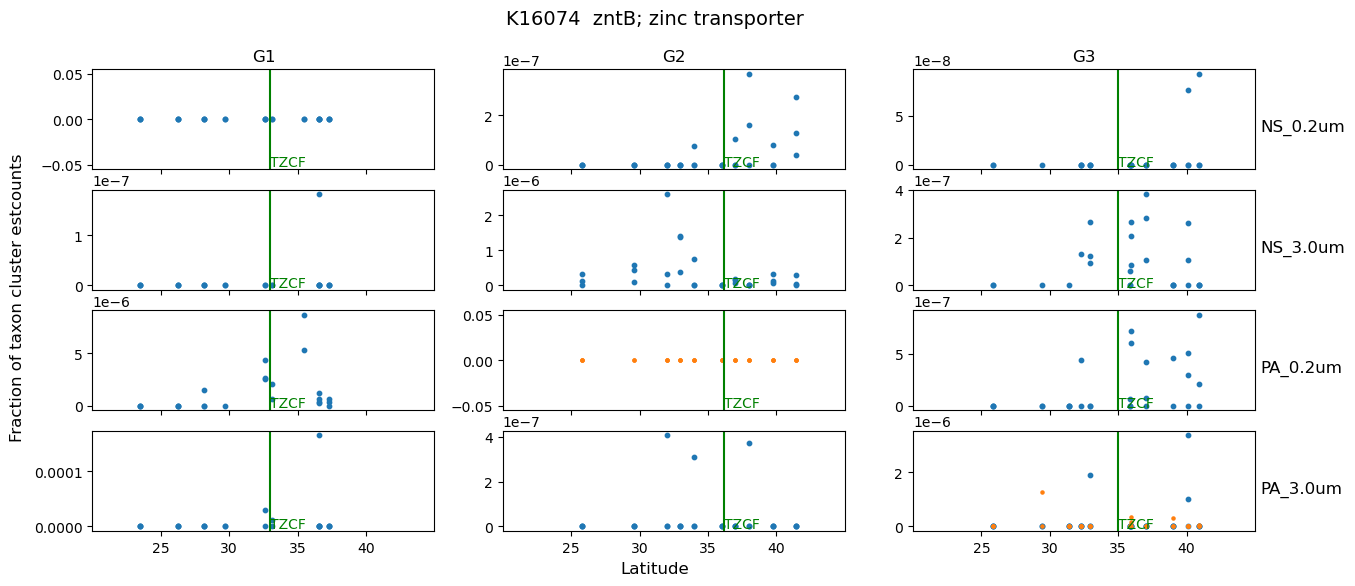

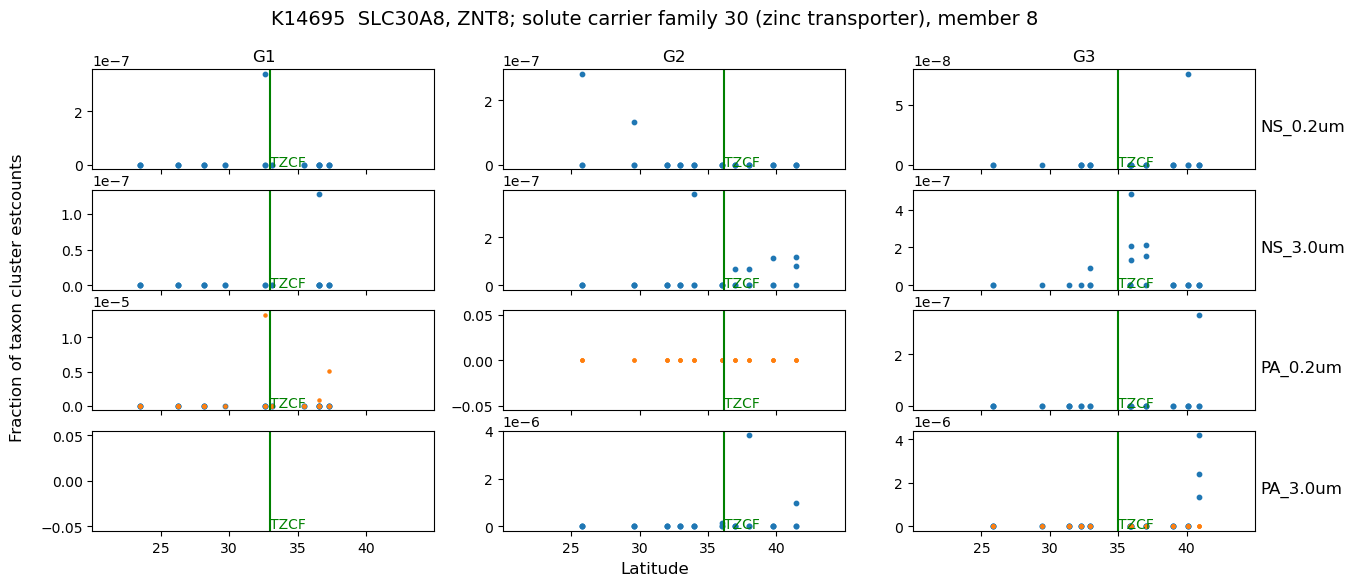

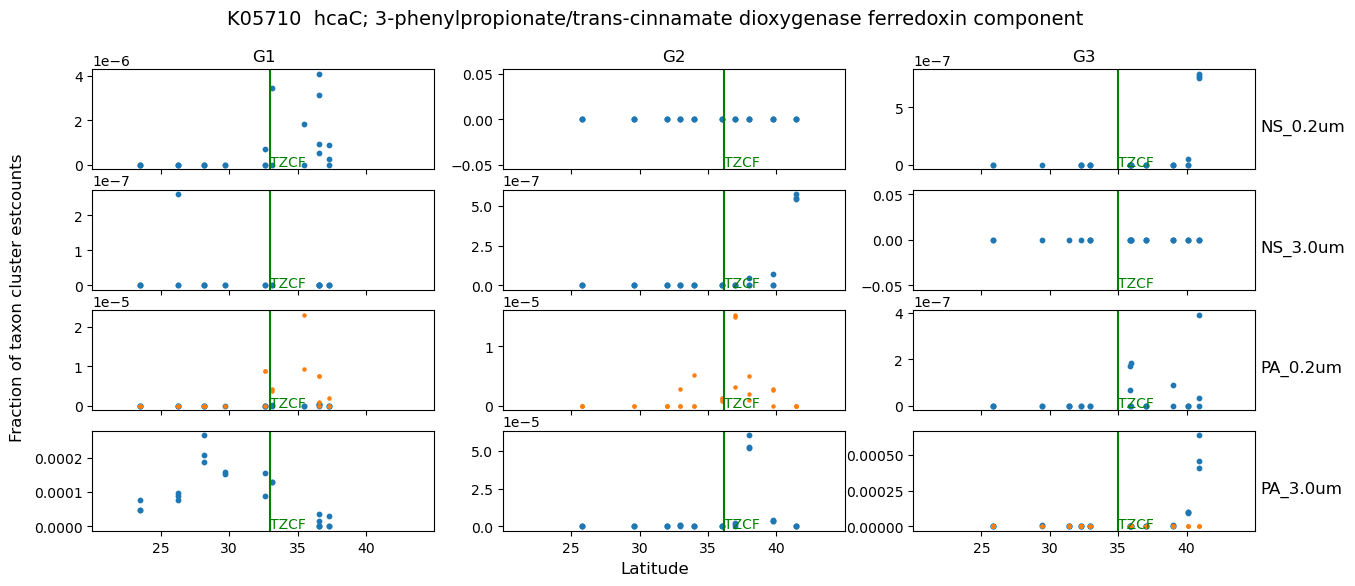

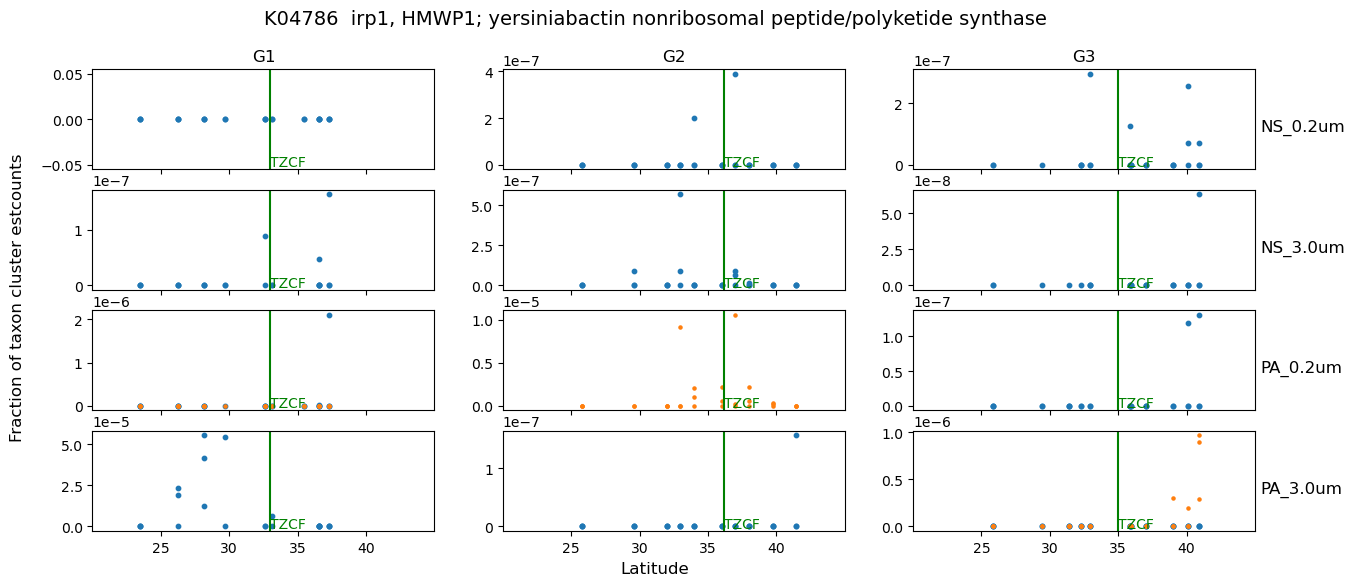

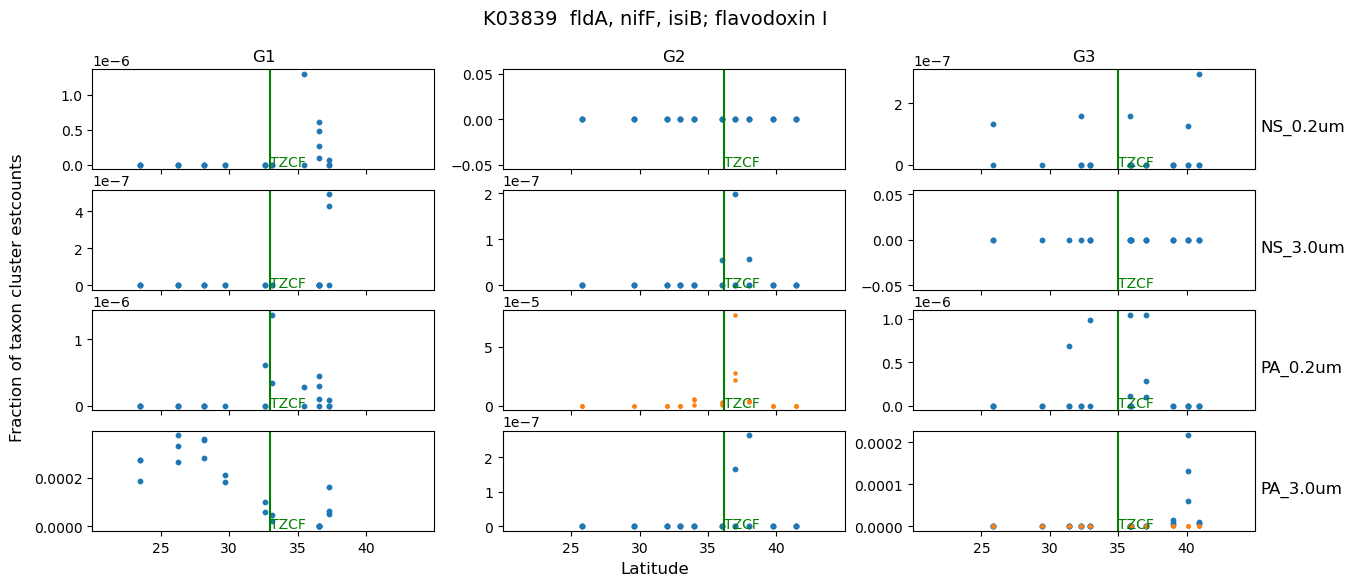

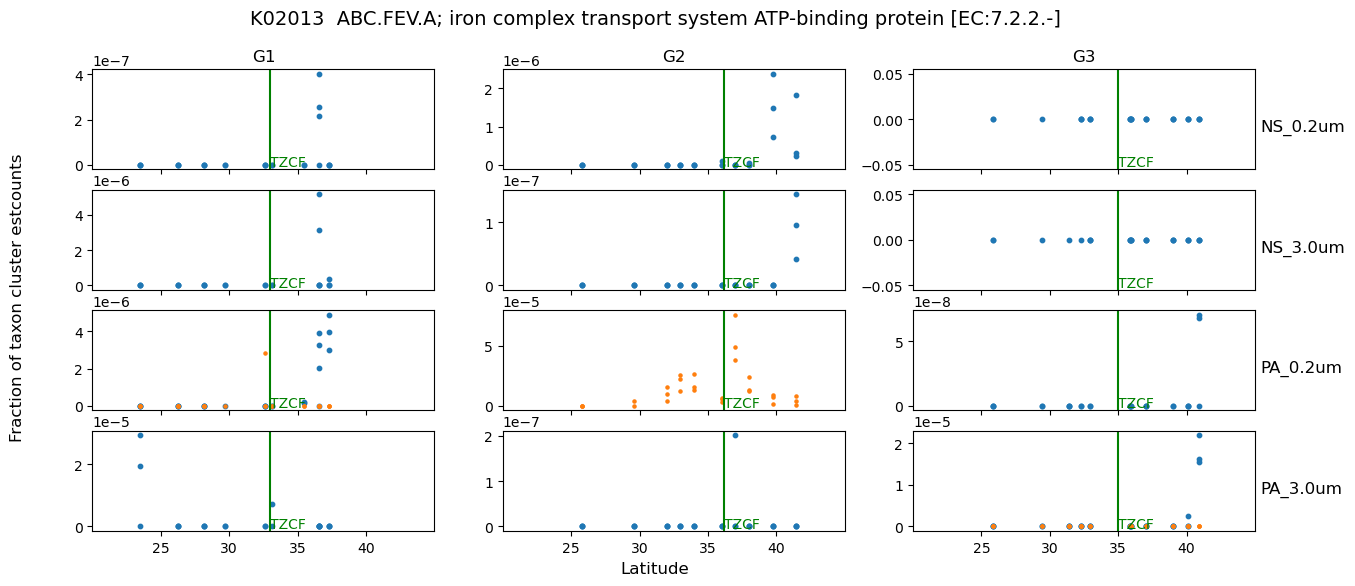

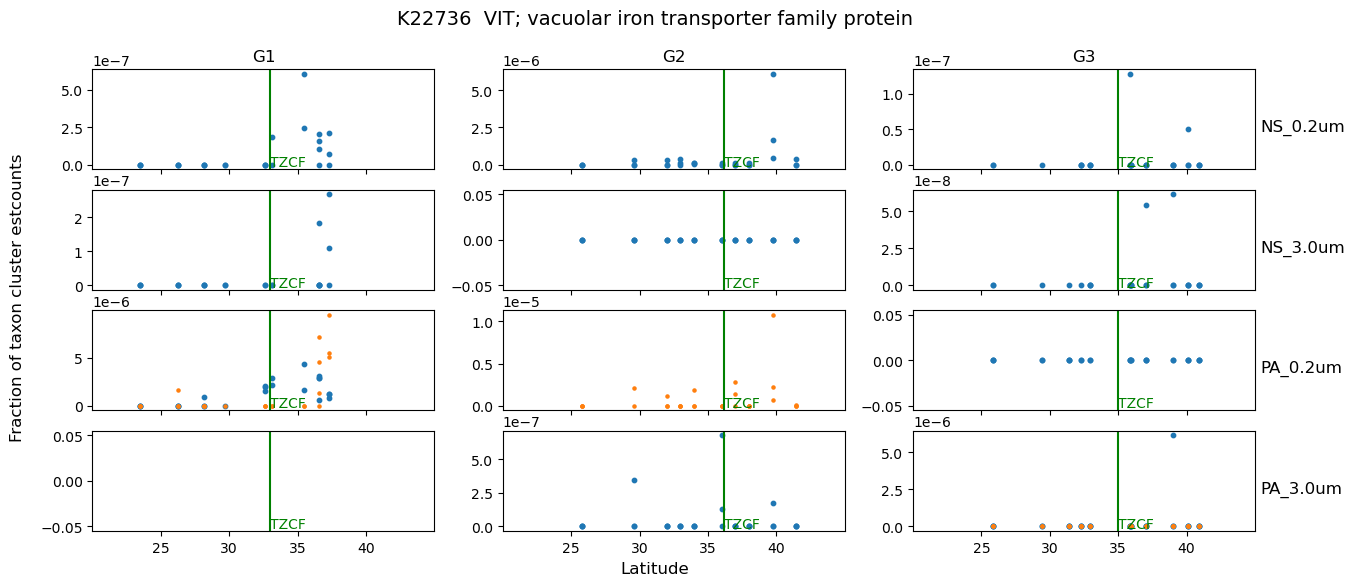

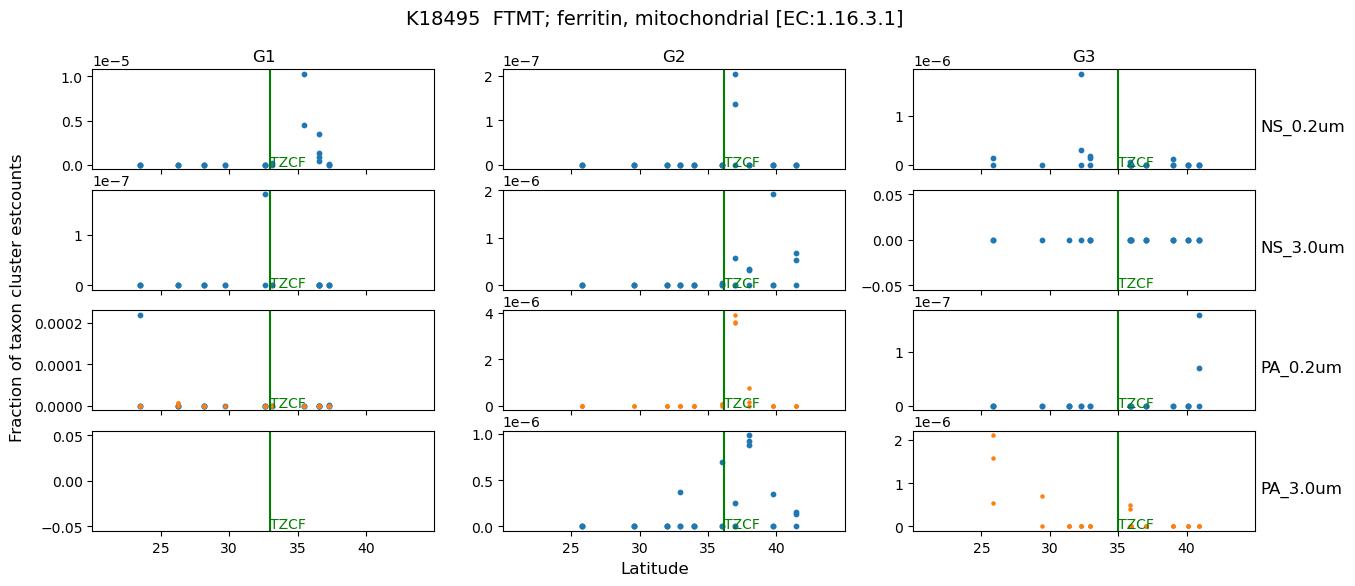

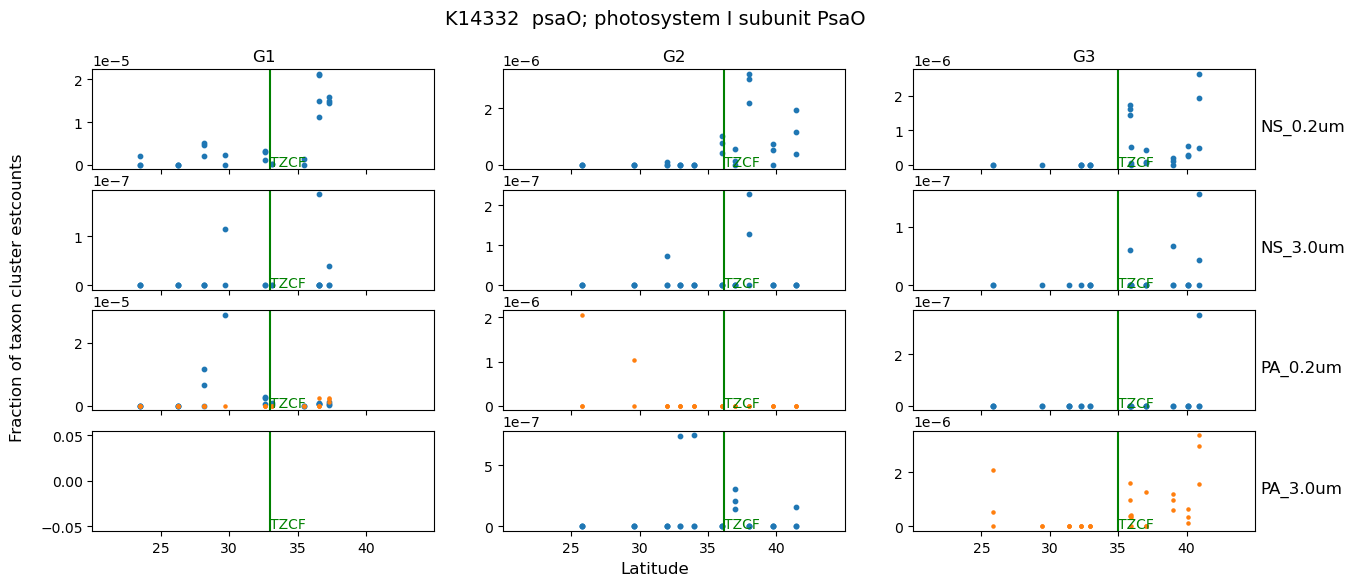

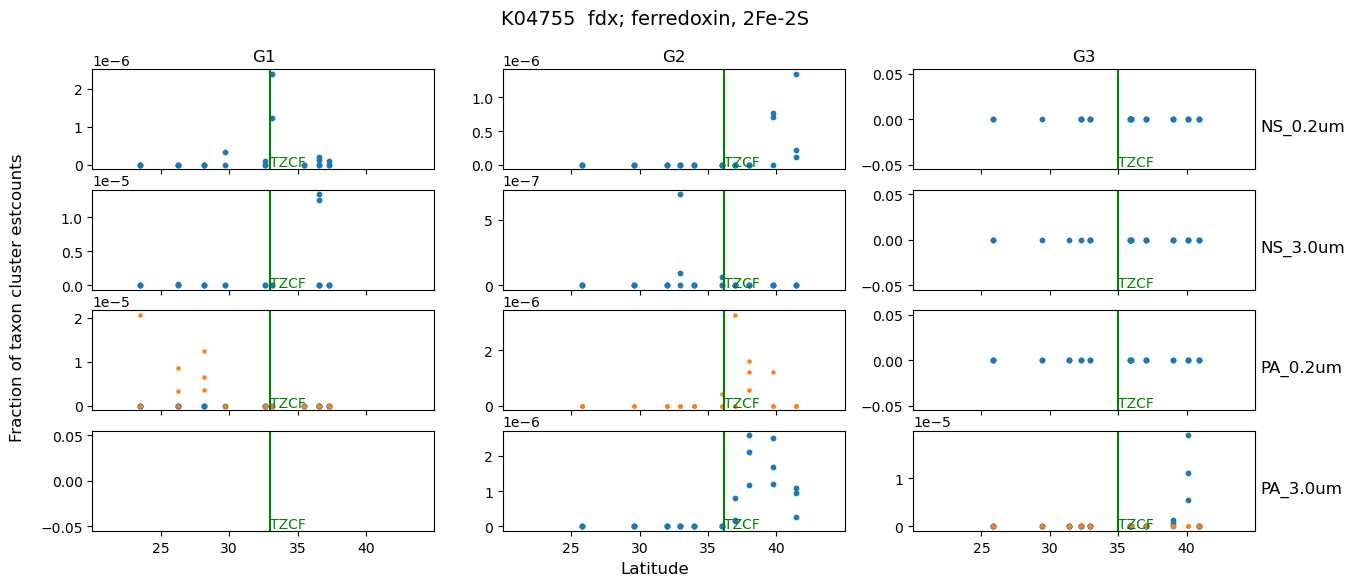

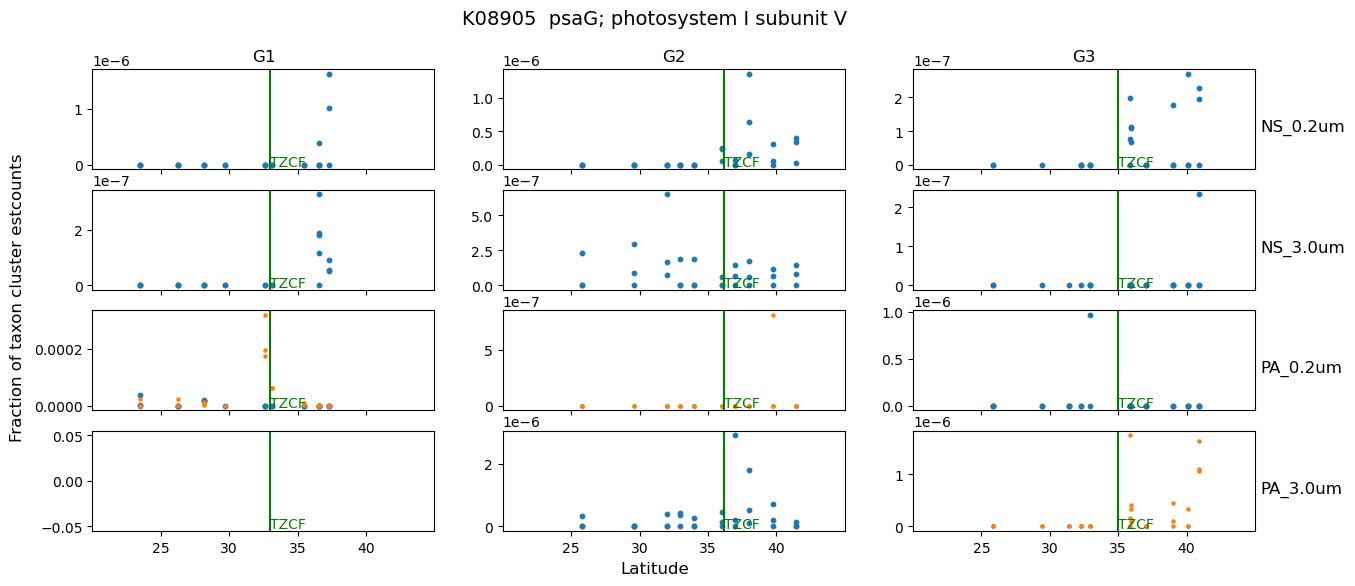

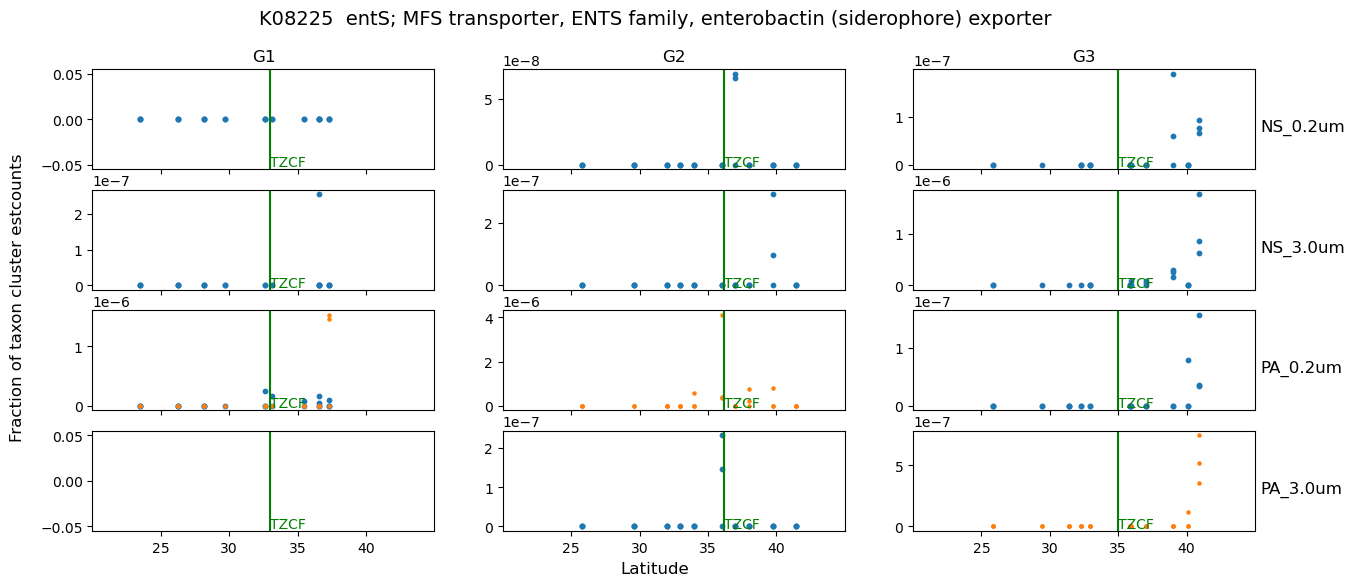

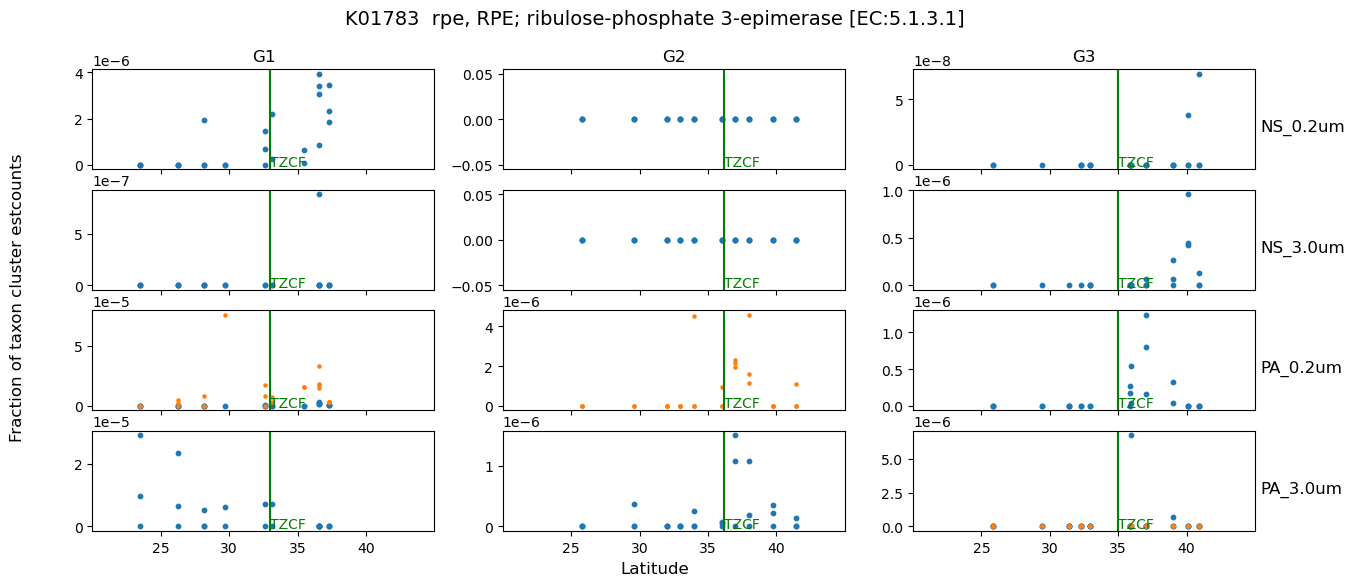

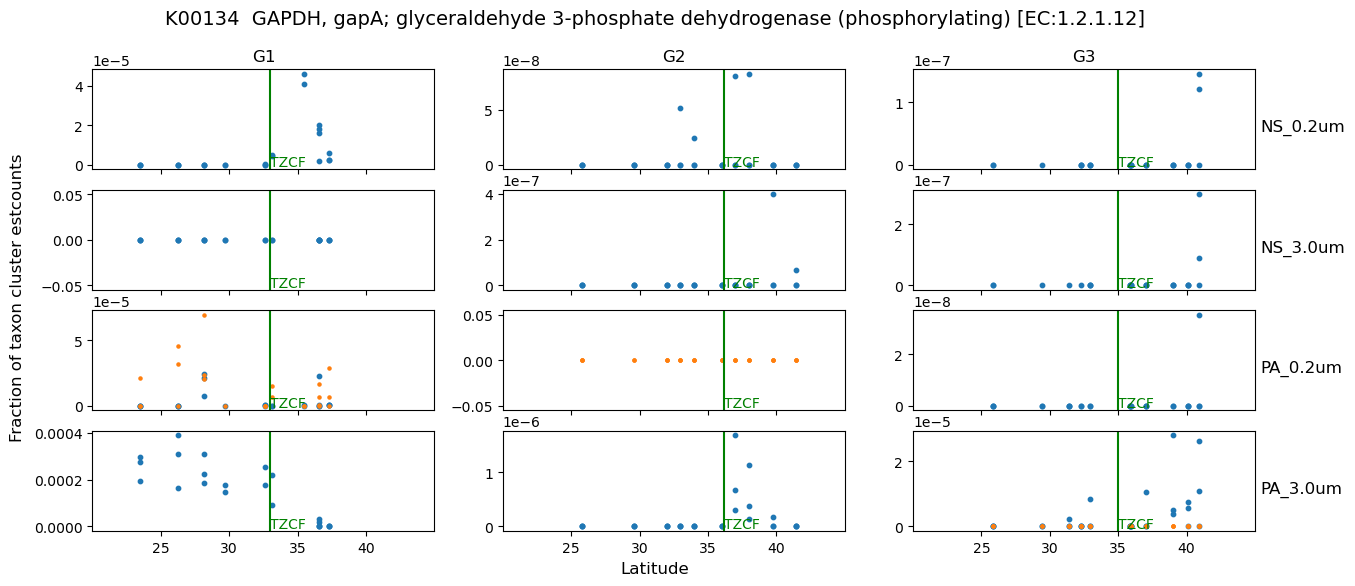

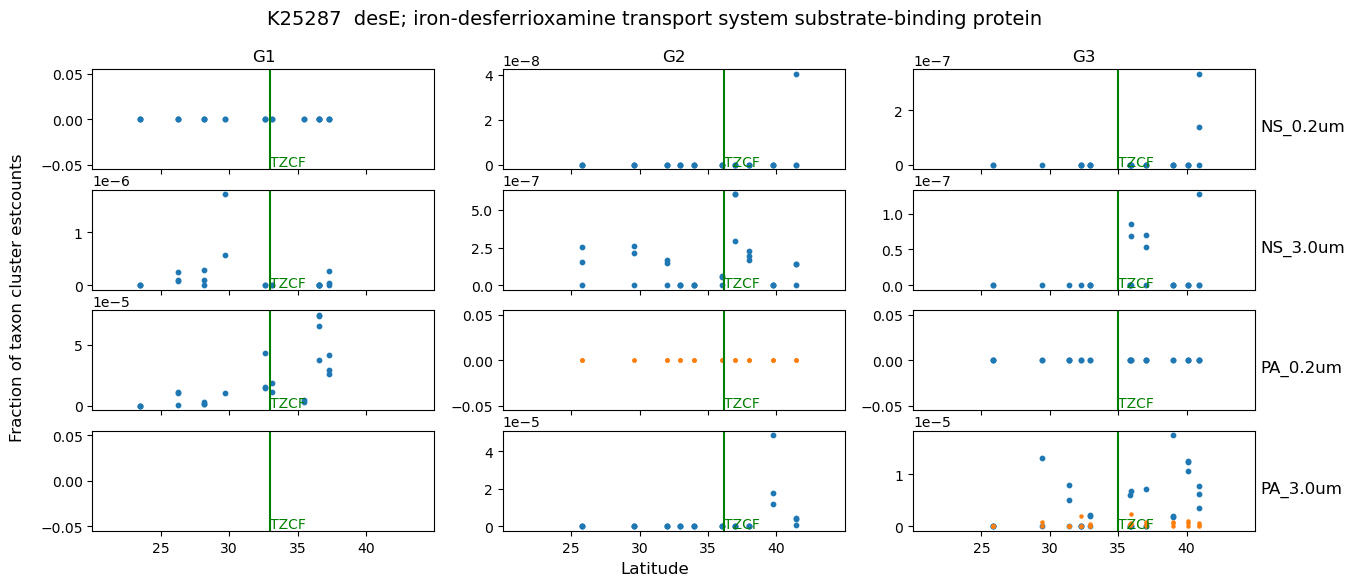

In [603]:
cltype = 'frac_N-trl_N'
# spatial plots
ft0 = 12
ft1 = 10
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'G3PA.PM': 0,
    'G3PA.diel': 1,
    'D1PA': 2,
    'G5': 3,
}
ncols = 3
nrows = 4
# dict_selsz_i = {
#     'NS-3.0um':0,
#     'NS-0.2um':1,
#     'PA-3.0um':2,
#     'PA-0.2um':3,
# }

slszs = [
    'NS_0.2um',
    'NS_3.0um',
    'PA_0.2um',
    'PA_3.0um',
]

colors = plt.get_cmap('tab10').colors

ss = [10,5,3,2,1]

xticks = np.arange(25,45,5).astype(int)


mf = 1
for ko in dict_cltype_kospos[cltype]:
# for ko in ['K07214','K22736','K19611']:
    # initialize plot
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(ncols*5,nrows*1.5)
    )
    fig.suptitle(dict_ko_name[ko], fontsize=ft0+2)
    fig.text(0.5, 0.04, 'Latitude', ha='center', fontsize=ft0)
    fig.text(0.07, 0.5, 'Fraction of taxon cluster estcounts', va='center', rotation='vertical', fontsize=ft0)

    # Separate out g1-3
    for j, cruise in enumerate(['G1','G2','G3']):
        for i, sel in enumerate(slszs):
            ax = axes[i,j]
            batch = cruise + '_' +  sel
            clusts = dict_cltype_batch_clusts[cltype][batch]
            cruise = dict_batch_meta[batch]['cruise']
            _, tzcf = dict_cruise_trans_sal_chl[cruise]
            for cl, color, s in zip(clusts, colors, ss):
                lats = []
                fracs = []
                dict_sam_frac = dict_batch_clust_ko_sam_frac[batch][str(cl)][ko]
                for sam, frac in dict_sam_frac.items():
                    lat = float(dict_meta[sam]['latitude'].strip('deg'))
                    lats.append(lat)
                    fracs.append(frac**(1/1))
                    mf = min(frac, mf) if frac else mf
                ax.scatter(lats, fracs, color=color, s=s)
                # if fracs:
                #     ax.set_ylim(1e-8, 1e-2)
                #     ax.set_yscale('log')
            ax.set_xlim(20,45)
            ax.set_xticks(xticks)
            xticklab = xticks if i == nrows - 1 else []
            ax.set_xticklabels(xticklab)
            if j == (ncols-1):
                ax.set_ylabel(f'{sel}', rotation=0, fontsize=ft0, ha='left')
                ax.yaxis.set_label_position("right")
            # write the column info
            if i == 0:
                ax.set_title(cruise)
            # TZcF
            ylims = ax.get_ylim()
            ax.set_ylim(ylims)
            ax.plot([tzcf]*2, ylims, 'g')
            ax.text(tzcf, ylims[0], 'TZCF', color='g', ha='left', va='bottom')
    plt.show()
    plt.close()

### Get genes unique to N vs S

In [593]:
dict_cruise_kosdiff = {}
for cruise in ['G1','G2','G3']:
    kos_N = set(dict_cltype_cruise_kospos['frac_N-trl_N'][cruise])
    kos_S = set(dict_cltype_cruise_kospos['frac_S-trl_S'][cruise])
    kos_N_diff = kos_N.difference(kos_S)
    kos_S_diff = kos_S.difference(kos_N)
    kos_same = kos_N & kos_S
    dict_cruise_kosdiff[cruise] = [kos_N_diff, kos_S_diff]
    print(cruise)
    print('\tNorth unique genes')
    for ko in sorted(kos_N_diff):
        print('\t\t', dict_ko_name[ko])
    print('\tSouth unique genes')
    for ko in sorted(kos_S_diff):
        print('\t\t', dict_ko_name[ko])
    print('\tShared N/S genes')
    for ko in sorted(kos_same):
        print('\t\t', dict_ko_name[ko])


G1
	North unique genes
		 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
		 K00171  porD; pyruvate ferredoxin oxidoreductase delta subunit [EC:1.2.7.1]
		 K00175  korB, oorB, oforB; 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit beta [EC:1.2.7.3 1.2.7.11]
		 K00205  fwdF, fmdF; 4Fe-4S ferredoxin
		 K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
		 K00284  GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
		 K00360  nasB; assimilatory nitrate reductase electron transfer subunit [EC:1.7.99.-]
		 K00362  nirB; nitrite reductase (NADH) large subunit [EC:1.7.1.15]
		 K00366  nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
		 K00368  nirK; nitrite reductase (NO-forming) [EC:1.7.2.1]
		 K00374  narI, narV; nitrate reductase gamma subunit [EC:1.7.5.1 1.7.99.-]
		 K00528  fpr; ferredoxin/flavodoxin---NADP+ reductase [EC:1.18.1.2 1.19.1.1]
		 K00529  hcaD; 3-phenylpropionate/trans-cinnamate dioxygenase ferredoxi

## What are the taxon trees for the different clusters?


In [607]:
taxa[:3]

['72548', '1501138', '2759']

In [615]:
root_tid in lin

False

In [94]:
cltypes = ['frac_S-trl_N']

root = 'Bacteria'
root_tid = ncbi.get_name_translator([root])[root][0]

batches = ['G2_NS_0.2um', 'G2_NS_3.0um']

# for batch in batches:
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    dict_clust_taxa = dict_batch_clust_taxa[batch]
    print(batch)
    for cltype in cltypes:
        print('\t', cltype)
        clusts = dict_cltype_batch_clusts[cltype][batch]
        for cl in clusts:
            print('\t\t',cl)
            taxa = dict_clust_taxa[str(cl)]
            taxa_trans = []
            dict_tn_frac = {}
            if taxa:
                for t in taxa:
                    n = ncbi.get_taxid_translator([t]).get(int(t))
                    if n:
                        tn = ncbi.get_name_translator([n])[n][0]
                        lin = ncbi.get_lineage(tn)
                        if root_tid in lin:
                            taxa_trans.append(tn)
                            dict_assam_vals = dict_valtype_batch_tax_assam_vals['frac'][batch][t]
                            vals = [x for xs in dict_assam_vals.values() for x in xs]
                            vals = np.array(vals)
                            # mfrac = np.mean(vals)
                            mfrac = np.mean(vals[vals > 0])
                            dict_tn_frac[tn] = mfrac
                if taxa_trans:
                    tree = ncbi.get_topology(taxa_trans)
                    for n in tree.traverse():
                        mfrac_sum = 0
                        desc = list(n.descendants())
                        # mfrac = round(dict_tn_frac[int(n.name)], 10)
                        # print(n.name, [n_.name for n_ in desc])
                        if desc:
                            for n_ in desc:
                                if int(n_.name) in taxa_trans:
                                    f = dict_tn_frac.get(int(n_.name))
                                    mfrac_sum += f if f else 0
                                    
                        else:
                            mfrac_sum = mfrac        
                        mfrac_sum = round(mfrac_sum, 10)
                        n.add_props(mfrac_sum=mfrac_sum)
                        if int(n.name) in taxa_trans:
                            n.add_props(present='***')

                    print(tree.to_str(props=['sci_name', 'mfrac_sum'], compact=True))

D1PA_PA_nan
	 frac_S-trl_N
G1_NS_0.2um
	 frac_S-trl_N
G1_NS_3.0um
	 frac_S-trl_N
G1_PA_0.2um
	 frac_S-trl_N
		 656
                                                                                ╭╴Rhodobacterales,1.00589e-05╶┬╴Rhodobacterales bacterium HTCC2255,1.025e-07
                                                   ╭╴Pseudomonadota,1.15333e-05╶┤                             ╰╴Polymorphum gilvum SL003B-26A1,1.025e-07
                                                   │                            ├╴Agarilytica rhodophyticola,1.025e-07
                                                   │                            ╰╴Limnobacter sp. MED105,1.025e-07
                      ╭╴Pseudomonadati,3.33565e-05╶┼╴PVC group,1.9023e-06╶┬╴Verrucomicrobia bacterium SCGC AAA300-K03,1.025e-07
                      │                            │                      ╰╴Candidatus Rubidus massiliensis,1.025e-07
                      │                            ├╴Myxococcota,5.5333e-06╶╌╴Polyangia,2.8607e

## Difference in bacterial kos between size fractions

Subset cluster so genes from bacteria

In [809]:
root = 'Bacteria'
root_tid = ncbi.get_name_translator([root])[root][0]

dict_cltype_batch_bactkos = defaultdict(lambda: defaultdict(list))
for batch, dict_clust_cltype in dict_batch_clust_cltype.items():
    if 'NS' in batch:
        for clust, cltype in dict_clust_cltype.items():
            kospos = dict_batch_clust_kospos[batch][str(clust)]
            if kospos:
                kospos_ = kospos[0] if len(kospos) == 1 else kospos
                kospos_ = set(kospos_)
                taxa = dict_batch_clust_taxa[batch][str(clust)]
                for t in taxa:
                    if int(t):
                        lin = ncbi.get_lineage(t)
                        if root_tid in lin:
                            kos_t = set(dict_taxon_ko_sample_estcounts[t].keys())
                            ko_union = list(kospos_ & kos_t)
                            dict_cltype_batch_bactkos[cltype][batch] += ko_union

/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1457154 was translated into 2954382
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 62928 was translated into 418699
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1453999 was translated into 2954383
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1449126 was translated into 1712410
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1217705 was translated into 1776740
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1118061 was translated into 2585118
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 65497 

Difference between size fractions

In [810]:
cltype = 'frac_N-trl_N'

for cruise in ['G1','G2','G3']:
    print(cruise)
    szs = ['0.2um','3.0um']
    batches = [f'{cruise}_NS_{sz}' for sz in szs]
    szs_kos = [dict_cltype_batch_bactkos[cltype][batch] for batch in batches]
    for i, sz in enumerate(szs):
        print(f'\tUnique in {sz}')
        kossz = set(szs_kos[i])
        kosother = set(szs_kos[i-1])
        kosunq = kossz.difference(kosother)
        for ko in sorted(kosunq):
            print('\t\t', dict_ko_name[ko])
    print('\tIn both')
    kosboth = set(szs_kos[0]) & set(szs_kos[1])
    for ko in sorted(kosboth):
        print('\t\t', dict_ko_name[ko])

G1
	Unique in 0.2um
		 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
		 K00171  porD; pyruvate ferredoxin oxidoreductase delta subunit [EC:1.2.7.1]
		 K00179  iorA; indolepyruvate ferredoxin oxidoreductase, alpha subunit [EC:1.2.7.8]
		 K00186  vorA; 2-oxoisovalerate ferredoxin oxidoreductase alpha subunit [EC:1.2.7.7]
		 K00187  vorB; 2-oxoisovalerate ferredoxin oxidoreductase beta subunit [EC:1.2.7.7]
		 K00205  fwdF, fmdF; 4Fe-4S ferredoxin
		 K00264  GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
		 K00284  GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
		 K00362  nirB; nitrite reductase (NADH) large subunit [EC:1.7.1.15]
		 K00366  nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
		 K00368  nirK; nitrite reductase (NO-forming) [EC:1.7.2.1]
		 K00370  narG, narZ, nxrA; nitrate reductase / nitrite oxidoreductase, alpha subunit [EC:1.7.5.1 1.7.99.-]
		 K00374  narI, narV; nitrate reductase gamma subunit [EC:1.7.5.1 1.7.99.-]
		 K

### Are there any cases where the fraction in the 3um is greater than the 2um?

Get Trees

In [92]:
cltypes = ['frac_N-trl_N']

root = 'Bacteria'
root_tid = ncbi.get_name_translator([root])[root][0]

batches = ['G2_NS_0.2um', 'G2_NS_3.0um']
trees = []
for batch in batches:
    dict_clust_taxa = dict_batch_clust_taxa[batch]

# for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    print(batch)
    for cltype in cltypes:
        print('\t', cltype)
        clusts = dict_cltype_batch_clusts[cltype][batch]
        for cl in clusts:
            print('\t\t',cl)
            taxa = dict_clust_taxa[str(cl)]
            taxa_trans = []
            dict_tn_frac = {}
            if taxa:
                for t in taxa:
                    n = ncbi.get_taxid_translator([t]).get(int(t))
                    if n:
                        tn = ncbi.get_name_translator([n])[n][0]
                        lin = ncbi.get_lineage(tn)
                        if root_tid in lin:
                            taxa_trans.append(tn)
                            dict_assam_vals = dict_valtype_batch_tax_assam_vals['frac'][batch][t]
                            vals = [x for xs in dict_assam_vals.values() for x in xs]
                            vals = np.array(vals)
                            # mfrac = np.mean(vals)
                            mfrac = np.mean(vals[vals > 0])
                            dict_tn_frac[tn] = mfrac
                if taxa_trans:
                    tree = ncbi.get_topology(taxa_trans)
                    for n in tree.traverse():
                        mfrac_sum = 0
                        desc = list(n.descendants())
                        # mfrac = round(dict_tn_frac[int(n.name)], 10)
                        # print(n.name, [n_.name for n_ in desc])
                        if desc:
                            for n_ in desc:
                                if int(n_.name) in taxa_trans:
                                    f = dict_tn_frac.get(int(n_.name))
                                    mfrac_sum += f if f else 0
                                    
                        else:
                            mfrac_sum = mfrac        
                        mfrac_sum = round(mfrac_sum, 10)
                        n.add_props(mfrac_sum=mfrac_sum)
                        if int(n.name) in taxa_trans:
                            n.add_props(present='***')
                trees.append(tree)

                    # print(tree.to_str(props=['sci_name', 'mfrac_sum'], compact=True))

G2_NS_0.2um
	 frac_N-trl_N
		 1526
G2_NS_3.0um
	 frac_N-trl_N
		 1531


Get differences in fraction between 0.2 and 3um fraction

In [808]:
diffs = []
diffs_taxids = []
for n30 in trees[1].traverse():
    if n30.name in trees[0]:
        n02 = trees[0][n30.name]
        f30 = n30.props['mfrac_sum']
        f02 = n02.props['mfrac_sum']
        diffs.append(f30 - f02)
        diffs_taxids.append(n30.name)
    else:
        f = n30.props['mfrac_sum']
        if f > 1e-6:
            t = n30.name
            n = ncbi.get_taxid_translator([t])[int(t)]
            print(n, f)

Nitrospinaceae 4.22313e-05
Legionellales 5.6192e-06
Kangiella 1.14216e-05
Ignavibacteriales 1.4861e-06
Sphaerochaetaceae 2.643e-06
Lachnospirales 2.2633e-06
Pleurocapsales 4.6181e-06
unclassified Candidatus Accumulibacter 3.2346e-06
Coxiellaceae 1.1543e-06
Prochlorococcaceae 1.26225e-05
Hyellaceae 2.8189e-06
Octadecabacter 1.48711e-05
Citromicrobium 2.2092e-06
Nocardioides 1.6196e-06
Pontibacillus 1.02392e-05
unclassified Citromicrobium 2.0963e-06


Plot zscores of differences

(-0.01, 0.01)

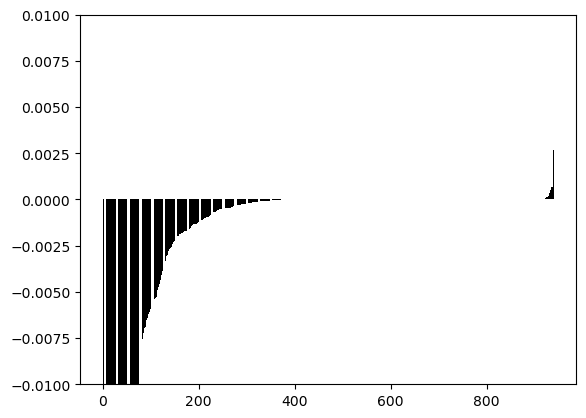

In [803]:
ev = np.median(diffs)
std = np.std(diffs)
zs = [(d - ev) / std for d in diffs]
dict_tax_name = ncbi.get_taxid_translator(diffs_taxids)
dt_sort = [x for _, x in sorted(zip(zs, diffs_taxids))]
xticklab = [dict_tax_name[int(t)] for t in dt_sort]
zs_sort = sorted(zs)

fig, ax = plt.subplots()
x = np.arange(len(zs_sort))
ax.bar(x, zs_sort, color='k')
# ax.set_xticks(x)
# ax.set_xticklabels(xticklab, rotation=90, ha='center',va='top')
ax.set_ylim(-0.01,0.01)
# ax.set_xlim(0,10)

What are the taxa with higher than expected fraction in 3um?

In [804]:
srs = pd.Series(zs_sort, index=xticklab)
srs[srs > 0]

canis group                                   0.000003
Algoriphagus vanfongensis                     0.000007
Stappia                                       0.000007
Streptosporangiales                           0.000008
Weissella                                     0.000012
unclassified Serratia (in: enterobacteria)    0.000012
Geotalea                                      0.000020
Pantoea                                       0.000020
Thermaceae                                    0.000021
unclassified Bacillus (in: firmicutes)        0.000022
Grimontia                                     0.000027
Thermus                                       0.000039
Frankia                                       0.000059
Sphaerotilaceae                               0.000069
Achromobacter                                 0.000069
Shewanella                                    0.000094
Parachlamydiales                              0.000106
Roseiflexus                                   0.000116
Mollicutes

## Get taxa consistent across cruises

Get intersection of sets of taxa within selection-size groups

In [ ]:
dict_cltype_selsz_taxa = defaultdict(lambda: defaultdict(list))
for cltype, dict_batch_clusts in dict_cltype_batch_clusts.items():
    for batch, clusts in dict_batch_clusts.items():
        row_meta = dict_batch_meta[batch]
        sel, sz = [row_meta[c] for c in ['selection','size']]
        selsz = f'{sel}_{sz}'
        taxa_ = []
        for cl in clusts:
            t = dict_batch_clust_taxa[batch][str(cl)]
            taxa_ += (t)
        taxa = dict_cltype_selsz_taxa[cltype][selsz]
        taxa = list(set(taxa) & set(taxa_))
        dict_cltype_selsz_taxa[cltype][selsz] = taxa


print taxa

In [842]:
for cltype, dict_selsz_taxa in dict_cltype_selsz_taxa.items():
    print(cltype)
    for selsz, taxa in dict_selsz_taxa.items():
        dict_tax_name = ncbi.get_taxid_translator(taxa)
        print(f'\t{selsz}')
        for t in taxa:
            n = dict_tax_name[int(t)]
            print(f'\t\t{n}')

frac_N-trl_N
	NS_0.2um
	NS_3.0um
	PA_0.2um
	PA_3.0um
frac_S-trl_S
	NS_0.2um
	NS_3.0um
	PA_0.2um
	PA_3.0um
frac_~CF-trl_~CF
	NS_0.2um
	NS_3.0um
	PA_0.2um
	PA_3.0um
frac_-trl_N
	PA_0.2um
	PA_3.0um
frac_S-trl_N
	PA_0.2um
	NS_3.0um
	PA_3.0um
frac_CF-trl_CF
	PA_3.0um
	NS_3.0um
	PA_0.2um
frac_S-trl_CF
	PA_3.0um
	PA_0.2um
frac_-trl_~CF
	NS_3.0um


## Plot 

In [ ]:
cltypes = ['frac_S-trl_S']

root = 'Bacteria'
root_tid = ncbi.get_name_translator([root])[root][0]

batches = ['G2_NS_0.2um', 'G2_NS_3.0um']

# for batch in batches:
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    dict_clust_taxa = dict_batch_clust_taxa[batch]
    for cltype in cltypes:
        print('\t', cltype)
        clusts = dict_cltype_batch_clusts[cltype][batch]
        for cl in clusts:
            print('\t\t',cl)
            taxa = dict_clust_taxa[str(cl)]
            taxa_trans = []
            dict_tn_frac = {}
            if taxa:
                for t in taxa:
                    n = ncbi.get_taxid_translator([t]).get(int(t))
                    if n:
                        tn = ncbi.get_name_translator([n])[n][0]
                        lin = ncbi.get_lineage(tn)
                        if root_tid in lin:
                            taxa_trans.append(tn)
                            dict_assam_vals = dict_valtype_batch_tax_assam_vals['frac'][batch][t]
                            vals = [x for xs in dict_assam_vals.values() for x in xs]
                            vals = np.array(vals)
                            # mfrac = np.mean(vals)
                            mfrac = np.mean(vals[vals > 0])
                            dict_tn_frac[tn] = mfrac
                if taxa_trans:
                    tree = ncbi.get_topology(taxa_trans)
                    for n in tree.traverse():
                        mfrac_sum = 0
                        desc = list(n.descendants())
                        # mfrac = round(dict_tn_frac[int(n.name)], 10)
                        # print(n.name, [n_.name for n_ in desc])
                        if desc:
                            for n_ in desc:
                                if int(n_.name) in taxa_trans:
                                    f = dict_tn_frac.get(int(n_.name))
                                    mfrac_sum += f if f else 0
                                    
                        else:
                            mfrac_sum = mfrac        
                        mfrac_sum = round(mfrac_sum, 10)
                        n.add_props(mfrac_sum=mfrac_sum)
                        if int(n.name) in taxa_trans:
                            n.add_props(present='***')

                    print(tree.to_str(props=['sci_name', 'mfrac_sum'], compact=True))

D1PA_PA_nan
	 frac_S-trl_S


NameError: name 'dict_cltype_batch_clusts' is not defined